# Paired Path Browser

Interactive tool for exploring individual CRN-paired simulation paths.
Select a configuration and filter for interesting paths to compare **insured vs. uninsured**
trajectories for the same underlying random draws.

**Filters:**
- **Catastrophic** - Paths with >$2M single-year losses
- **Near-Ruin** - Bottom 1% of surviving simulations by final assets
- **Median** - Paths closest to the median final outcome
- **Best** - Top 1% by final assets
- **Worst Surviving** - Bottom 5% of survivors
- **Ruined** - Paths that went insolvent

**Note:** This browser loads pickle files on-demand from the results directory.
The first load for each configuration may be slow (~5-10s for 250K sim files).

**Prerequisites:** Run `1. process_vol_sim_results.ipynb` first to build `cache/dashboard_cache.pkl`.

In [1]:
import pickle
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, HTML
from pathlib import Path

In [2]:
# Configuration - adjust this path to point to your simulation results
RESULTS_DIR = Path(r"D:\2026-01-31 Vol")

# Load dashboard cache
cache_path = Path("cache/dashboard_cache.pkl")
with open(cache_path, "rb") as f:
    cache = pickle.load(f)

configs = cache["configs"]
crn_pairs = cache["crn_pairs"]
param_values = cache["param_values"]

# Override results dir if cache has a different path
if not RESULTS_DIR.exists() and "results_dir" in cache:
    RESULTS_DIR = Path(cache["results_dir"])

print(f"Results dir: {RESULTS_DIR}")
print(f"Loaded {len(configs)} configs, {len(crn_pairs)} CRN pairs")

Results dir: D:\2026-01-31 Vol
Loaded 42 configs, 24 CRN pairs


In [3]:
# Pickle file cache - avoid re-loading the same file repeatedly
_pkl_cache = {}


def load_sim_results(config_key):
    """Load simulation results from pickle, with in-memory caching."""
    if config_key in _pkl_cache:
        return _pkl_cache[config_key]

    pkl_path = RESULTS_DIR / f"{config_key}.pkl"
    if not pkl_path.exists():
        # Try with whitespace variations in the filename
        candidates = list(RESULTS_DIR.glob(f"{config_key[:30]}*.pkl"))
        if candidates:
            pkl_path = candidates[0]
        else:
            raise FileNotFoundError(f"No pickle file found for: {config_key}")

    with open(pkl_path, "rb") as f:
        data = pickle.load(f)

    # Keep at most 4 loaded configs in memory (~2GB each)
    if len(_pkl_cache) >= 4:
        oldest = next(iter(_pkl_cache))
        del _pkl_cache[oldest]

    _pkl_cache[config_key] = data
    return data


def find_config_key(cap, atr, ded):
    """Find the config key matching the given insured parameters."""
    for key, cfg in configs.items():
        if (cfg.get("Cap") == cap
            and cfg.get("ATR") == atr
            and cfg.get("Ded") == ded
            and not cfg.get("NOINS")):
            return key
    return None


def find_noins_key(cap, atr):
    """Find the NOINS config key matching the given Cap and ATR."""
    for key, cfg in configs.items():
        if (cfg.get("Cap") == cap
            and cfg.get("ATR") == atr
            and cfg.get("NOINS")):
            return key
    return None


def fmt_amount(n):
    if n >= 1e9: return f"${n/1e9:.0f}B"
    if n >= 1e6: return f"${n/1e6:.0f}M"
    if n >= 1e3: return f"${n/1e3:.0f}K"
    return f"${n:.0f}"

In [4]:
# Color scheme
INS_COLOR = "rgb(31,119,180)"
NI_COLOR = "rgb(255,127,14)"
LOSS_COLOR = "rgb(214,39,40)"
RECOVERY_COLOR = "rgb(44,160,44)"

# Create widgets
cap_dropdown = widgets.Dropdown(
    options=[(fmt_amount(v), v) for v in param_values["Cap"]],
    value=param_values["Cap"][0],
    description="Cap:",
    style={"description_width": "auto"},
)
atr_dropdown = widgets.Dropdown(
    options=[(str(v), v) for v in param_values["ATR"]],
    value=param_values["ATR"][1] if len(param_values["ATR"]) > 1 else param_values["ATR"][0],
    description="ATR:",
    style={"description_width": "auto"},
)
ded_dropdown = widgets.Dropdown(
    options=[(fmt_amount(v), v) for v in param_values["Ded"]],
    value=param_values["Ded"][1] if len(param_values["Ded"]) > 1 else param_values["Ded"][0],
    description="Deductible:",
    style={"description_width": "auto"},
)
filter_dropdown = widgets.Dropdown(
    options=["catastrophic", "near_ruin", "median", "best", "worst_surviving", "ruined"],
    value="catastrophic",
    description="Path filter:",
    style={"description_width": "auto"},
)
sim_id_dropdown = widgets.Dropdown(
    options=[],
    description="Sim ID:",
    style={"description_width": "auto"},
)

status_label = widgets.HTML(value="")
output_area = widgets.Output()

In [5]:
def update_sim_ids(change=None):
    """Update the sim_id dropdown based on current config and filter."""
    cap = cap_dropdown.value
    atr = atr_dropdown.value
    ded = ded_dropdown.value
    filt = filter_dropdown.value

    ins_key = find_config_key(cap, atr, ded)
    if ins_key is None:
        sim_id_dropdown.options = []
        status_label.value = "<span style='color:red'>No config found</span>"
        return

    cfg = configs[ins_key]
    interesting = cfg.get("interesting_sims", {})
    sim_ids = interesting.get(filt, [])

    if not sim_ids:
        sim_id_dropdown.options = [("(none available)", -1)]
        status_label.value = f"<span style='color:orange'>No {filt} paths for this config</span>"
    else:
        sim_id_dropdown.options = [(f"#{sid} (final=${cfg['final_assets_qs'][int(sid / cfg['n_sims'] * 1000)] if sid < cfg['n_sims'] else 0:,.0f})", sid)
                                   if sid < len(cfg.get('final_assets_qs', [])) * cfg.get('n_sims', 1) / 1000
                                   else (f"#{sid}", sid)
                                   for sid in sim_ids[:50]]
        status_label.value = f"<span style='color:green'>{len(sim_ids)} {filt} paths available</span>"


def update_path_display(change=None):
    """Load and display the selected simulation path."""
    cap = cap_dropdown.value
    atr = atr_dropdown.value
    ded = ded_dropdown.value
    sim_id = sim_id_dropdown.value

    if sim_id is None or sim_id < 0:
        return

    ins_key = find_config_key(cap, atr, ded)
    noins_key = find_noins_key(cap, atr)

    if ins_key is None:
        with output_area:
            output_area.clear_output(wait=True)
            print("No insured config found.")
        return

    try:
        status_label.value = "<span style='color:blue'>Loading pickle files...</span>"
        ins_data = load_sim_results(ins_key)
        noins_data = load_sim_results(noins_key) if noins_key else None
        status_label.value = "<span style='color:green'>Data loaded</span>"
    except Exception as ex:
        with output_area:
            output_area.clear_output(wait=True)
            print(f"Error loading data: {ex}")
        status_label.value = f"<span style='color:red'>Load error: {ex}</span>"
        return

    n_years = ins_data.config.n_years
    years = np.arange(1, n_years + 1)
    cfg = configs[ins_key]
    initial_assets = cfg["initial_assets"]

    # Extract data for this sim_id
    ins_losses = ins_data.annual_losses[sim_id]
    ins_recoveries = ins_data.insurance_recoveries[sim_id]
    ins_retained = ins_data.retained_losses[sim_id]
    ins_final = ins_data.final_assets[sim_id]
    ins_growth = ins_data.growth_rates[sim_id]

    if noins_data is not None:
        ni_losses = noins_data.annual_losses[sim_id]
        ni_retained = noins_data.retained_losses[sim_id]
        ni_final = noins_data.final_assets[sim_id]
        ni_growth = noins_data.growth_rates[sim_id]
    else:
        ni_losses = ni_retained = None
        ni_final = ni_growth = None

    # Build visualization
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=[
            "Annual Ground-Up Losses",
            "Insurance Recoveries vs Retained Losses",
            "Cumulative Retained Losses",
            "Approximate Wealth Trajectories",
            "Annual Loss Decomposition (Insured)",
            "Loss Severity Comparison",
        ],
        vertical_spacing=0.10,
        horizontal_spacing=0.08,
    )

    # ===== Panel 1: Annual Ground-Up Losses =====
    fig.add_trace(go.Bar(
        x=years, y=ins_losses,
        name="Insured Losses", marker_color=INS_COLOR, opacity=0.7,
    ), row=1, col=1)

    if ni_losses is not None:
        fig.add_trace(go.Bar(
            x=years, y=ni_losses,
            name="Uninsured Losses", marker_color=NI_COLOR, opacity=0.7,
        ), row=1, col=1)

    fig.update_xaxes(title_text="Year", row=1, col=1)
    fig.update_yaxes(title_text="Ground-Up Loss ($)", row=1, col=1)

    # ===== Panel 2: Recoveries vs Retained (insured path) =====
    fig.add_trace(go.Bar(
        x=years, y=ins_retained,
        name="Retained (Insured)", marker_color=LOSS_COLOR, opacity=0.7,
    ), row=1, col=2)
    fig.add_trace(go.Bar(
        x=years, y=ins_recoveries,
        name="Insurance Recovery", marker_color=RECOVERY_COLOR, opacity=0.7,
    ), row=1, col=2)

    fig.update_xaxes(title_text="Year", row=1, col=2)
    fig.update_yaxes(title_text="Amount ($)", row=1, col=2)
    fig.update_layout(barmode="group")

    # ===== Panel 3: Cumulative Retained Losses =====
    cum_ins_retained = np.cumsum(ins_retained)
    fig.add_trace(go.Scatter(
        x=years, y=cum_ins_retained,
        line=dict(color=INS_COLOR, width=2.5),
        name="Cum. Retained (Insured)",
    ), row=2, col=1)

    if ni_retained is not None:
        cum_ni_retained = np.cumsum(ni_retained)
        fig.add_trace(go.Scatter(
            x=years, y=cum_ni_retained,
            line=dict(color=NI_COLOR, width=2.5, dash="dash"),
            name="Cum. Retained (Uninsured)",
        ), row=2, col=1)

        # Savings
        savings = cum_ni_retained - cum_ins_retained
        fig.add_trace(go.Scatter(
            x=years, y=savings,
            line=dict(color=RECOVERY_COLOR, width=1.5, dash="dot"),
            name="Cumulative Savings",
            fill="tozeroy", fillcolor="rgba(44,160,44,0.1)",
        ), row=2, col=1)

    fig.update_xaxes(title_text="Year", row=2, col=1)
    fig.update_yaxes(title_text="Cumulative Retained Loss ($)", row=2, col=1)

    # ===== Panel 4: Approximate Wealth Trajectories =====
    # Exponential interpolation from growth rate
    full_years = np.arange(n_years + 1)
    ins_wealth = initial_assets * np.exp(ins_growth * full_years)
    fig.add_trace(go.Scatter(
        x=full_years, y=ins_wealth,
        line=dict(color=INS_COLOR, width=2.5),
        name="Insured Wealth (approx)",
    ), row=2, col=2)

    if ni_growth is not None:
        ni_wealth = initial_assets * np.exp(ni_growth * full_years)
        fig.add_trace(go.Scatter(
            x=full_years, y=ni_wealth,
            line=dict(color=NI_COLOR, width=2.5, dash="dash"),
            name="Uninsured Wealth (approx)",
        ), row=2, col=2)

    fig.add_hline(y=10_000, line_dash="dot", line_color="red",
                  annotation_text="Ruin", row=2, col=2)
    fig.update_yaxes(type="log", title_text="Assets ($)", row=2, col=2)
    fig.update_xaxes(title_text="Year", row=2, col=2)

    # ===== Panel 5: Loss Decomposition (stacked bar) =====
    fig.add_trace(go.Bar(
        x=years, y=ins_retained,
        name="Retained by Company", marker_color=LOSS_COLOR, opacity=0.8,
    ), row=3, col=1)
    fig.add_trace(go.Bar(
        x=years, y=ins_recoveries,
        name="Paid by Insurer", marker_color=RECOVERY_COLOR, opacity=0.8,
    ), row=3, col=1)

    fig.update_xaxes(title_text="Year", row=3, col=1)
    fig.update_yaxes(title_text="Loss Amount ($)", row=3, col=1)

    # ===== Panel 6: Loss Severity Comparison =====
    # Compare years where large losses occurred
    large_loss_mask = ins_losses > np.percentile(ins_losses[ins_losses > 0], 75) if (ins_losses > 0).sum() > 4 else ins_losses > 0
    large_years = years[large_loss_mask]

    if len(large_years) > 0:
        fig.add_trace(go.Scatter(
            x=large_years, y=ins_losses[large_loss_mask],
            mode="markers", marker=dict(size=10, color=INS_COLOR),
            name="Large Losses (Insured)",
        ), row=3, col=2)
        fig.add_trace(go.Scatter(
            x=large_years, y=ins_retained[large_loss_mask],
            mode="markers", marker=dict(size=10, color=LOSS_COLOR, symbol="diamond"),
            name="Retained Portion",
        ), row=3, col=2)
        fig.add_trace(go.Scatter(
            x=large_years, y=ins_recoveries[large_loss_mask],
            mode="markers", marker=dict(size=10, color=RECOVERY_COLOR, symbol="triangle-up"),
            name="Insurance Recovery",
        ), row=3, col=2)

    fig.update_xaxes(title_text="Year", row=3, col=2)
    fig.update_yaxes(title_text="Amount ($)", row=3, col=2)

    # Layout
    title = (f"Sim #{sim_id} | Cap={fmt_amount(cap)} | ATR={atr} | Ded={fmt_amount(ded)}")
    fig.update_layout(
        height=1100, width=1300,
        title_text=f"Paired Path Browser: {title}",
        title_font_size=16,
        showlegend=True,
        legend=dict(font=dict(size=9), orientation="h", yanchor="bottom", y=-0.08),
        margin=dict(t=80, b=80),
    )

    # Summary metrics table
    rows_html = []
    metrics = [
        ("Growth Rate", f"{ins_growth:.5f}", f"{ni_growth:.5f}" if ni_growth is not None else "-"),
        ("Final Assets", fmt_amount(ins_final), fmt_amount(ni_final) if ni_final is not None else "-"),
        ("Total Losses", fmt_amount(ins_losses.sum()), fmt_amount(ni_losses.sum()) if ni_losses is not None else "-"),
        ("Total Retained", fmt_amount(ins_retained.sum()), fmt_amount(ni_retained.sum()) if ni_retained is not None else "-"),
        ("Total Recoveries", fmt_amount(ins_recoveries.sum()), "-"),
        ("Max Single-Year Loss", fmt_amount(ins_losses.max()), fmt_amount(ni_losses.max()) if ni_losses is not None else "-"),
        ("Years With Losses", str((ins_losses > 0).sum()), str((ni_losses > 0).sum()) if ni_losses is not None else "-"),
        ("Wealth Multiple (50yr)", f"{ins_final / initial_assets:.2f}x",
         f"{ni_final / initial_assets:.2f}x" if ni_final is not None else "-"),
    ]

    for label, v_ins, v_ni in metrics:
        rows_html.append(
            f"<tr><td style='padding:3px 10px'><b>{label}</b></td>"
            f"<td style='padding:3px 10px; text-align:right'>{v_ins}</td>"
            f"<td style='padding:3px 10px; text-align:right'>{v_ni}</td></tr>"
        )

    table_html = (
        "<table style='border-collapse:collapse; font-family:monospace; font-size:12px; margin-top:10px'>"
        "<tr style='border-bottom:2px solid #333'>"
        "<th style='padding:3px 10px; text-align:left'>Metric</th>"
        "<th style='padding:3px 10px; text-align:right; color:#1f77b4'>Insured</th>"
        "<th style='padding:3px 10px; text-align:right; color:#ff7f0e'>Uninsured</th></tr>"
        + "\n".join(rows_html)
        + "</table>"
    )

    with output_area:
        output_area.clear_output(wait=True)
        fig.show()
        display(HTML(table_html))

In [6]:
# Wire up callbacks
# Config/filter changes -> update sim_id list
cap_dropdown.observe(update_sim_ids, names="value")
atr_dropdown.observe(update_sim_ids, names="value")
ded_dropdown.observe(update_sim_ids, names="value")
filter_dropdown.observe(update_sim_ids, names="value")

# Sim ID change -> update path display
sim_id_dropdown.observe(update_path_display, names="value")

# Layout
config_row = widgets.HBox(
    [cap_dropdown, atr_dropdown, ded_dropdown],
    layout=widgets.Layout(gap="15px"),
)
filter_row = widgets.HBox(
    [filter_dropdown, sim_id_dropdown, status_label],
    layout=widgets.Layout(gap="15px"),
)

display(config_row)
display(filter_row)
display(output_area)

# Initialize
update_sim_ids()

Output()

## Multi-Path Overlay

Compare multiple paths from the same filter category overlaid on a single chart.
Useful for identifying patterns in catastrophic loss paths or near-ruin scenarios.

In [7]:
def show_multi_path_overlay(n_paths=10):
    """Overlay multiple filtered paths for pattern recognition."""
    cap = cap_dropdown.value
    atr = atr_dropdown.value
    ded = ded_dropdown.value
    filt = filter_dropdown.value

    ins_key = find_config_key(cap, atr, ded)
    noins_key = find_noins_key(cap, atr)

    if ins_key is None:
        print("No config found.")
        return

    cfg = configs[ins_key]
    sim_ids = cfg.get("interesting_sims", {}).get(filt, [])
    if not sim_ids:
        print(f"No {filt} paths available.")
        return

    sim_ids = sim_ids[:n_paths]

    try:
        ins_data = load_sim_results(ins_key)
        noins_data = load_sim_results(noins_key) if noins_key else None
    except Exception as ex:
        print(f"Error loading: {ex}")
        return

    n_years = ins_data.config.n_years
    years = np.arange(1, n_years + 1)

    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=[
            f"Cumulative Retained Losses ({filt}, {len(sim_ids)} paths)",
            f"Annual Losses ({filt})",
        ],
    )

    for i, sid in enumerate(sim_ids):
        alpha = 0.5
        show_legend = (i == 0)

        # Insured cumulative retained
        cum_ret = np.cumsum(ins_data.retained_losses[sid])
        fig.add_trace(go.Scatter(
            x=years, y=cum_ret,
            line=dict(color=INS_COLOR, width=1),
            opacity=alpha,
            name="Insured" if show_legend else None,
            showlegend=show_legend,
            legendgroup="ins",
        ), row=1, col=1)

        if noins_data is not None:
            cum_ret_ni = np.cumsum(noins_data.retained_losses[sid])
            fig.add_trace(go.Scatter(
                x=years, y=cum_ret_ni,
                line=dict(color=NI_COLOR, width=1, dash="dash"),
                opacity=alpha,
                name="Uninsured" if show_legend else None,
                showlegend=show_legend,
                legendgroup="noins",
            ), row=1, col=1)

        # Annual losses
        fig.add_trace(go.Scatter(
            x=years, y=ins_data.annual_losses[sid],
            line=dict(color=INS_COLOR, width=1),
            opacity=alpha, showlegend=False, legendgroup="ins",
        ), row=1, col=2)

    fig.update_xaxes(title_text="Year", row=1, col=1)
    fig.update_xaxes(title_text="Year", row=1, col=2)
    fig.update_yaxes(title_text="Cumulative Retained Loss ($)", row=1, col=1)
    fig.update_yaxes(title_text="Annual Loss ($)", row=1, col=2)

    fig.update_layout(
        height=450, width=1300,
        title_text=f"Multi-Path Overlay: {filt} | Cap={fmt_amount(cap)} | ATR={atr} | Ded={fmt_amount(ded)}",
        title_font_size=14,
    )
    fig.show()

    # Summary stats for these paths
    finals = ins_data.final_assets[sim_ids]
    growths = ins_data.growth_rates[sim_ids]
    print(f"\n{filt.title()} Paths Summary ({len(sim_ids)} paths):")
    print(f"  Growth rate: mean={growths.mean():.5f}, std={growths.std():.5f}")
    print(f"  Final assets: mean={fmt_amount(finals.mean())}, median={fmt_amount(np.median(finals))}")
    print(f"  Max single-year loss: {fmt_amount(ins_data.annual_losses[sim_ids].max())}")


show_multi_path_overlay()


Catastrophic Paths Summary (10 paths):
  Growth rate: mean=0.01707, std=0.00170
  Final assets: mean=$12M, median=$12M
  Max single-year loss: $14M


In [8]:
import os
os.chdir(r"C:\Users\alexf\OneDrive\Documents\Projects\Ergodic Insurance Limits\ergodic_insurance\notebooks\results_vol_sim")
print("Working directory:", os.getcwd())

Working directory: C:\Users\alexf\OneDrive\Documents\Projects\Ergodic Insurance Limits\ergodic_insurance\notebooks\results_vol_sim


In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import numpy as np
import pickle
from pathlib import Path

# Publication rcParams (see VISUAL_SPECIFICATION.md)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['CMU Serif', 'Computer Modern', 'Times New Roman', 'DejaVu Serif'],
    'font.size': 10, 'axes.titlesize': 11, 'axes.labelsize': 10,
    'xtick.labelsize': 9, 'ytick.labelsize': 9, 'legend.fontsize': 9,
    'legend.framealpha': 0.9, 'legend.edgecolor': '#CCCCCC',
    'figure.dpi': 150, 'savefig.dpi': 300,
    'savefig.bbox': 'tight', 'savefig.pad_inches': 0.1,
    'axes.spines.top': False, 'axes.spines.right': False,
    'axes.grid': True, 'axes.axisbelow': True,
    'grid.alpha': 0.3, 'grid.linestyle': '--', 'grid.linewidth': 0.5,
    'text.usetex': False, 'mathtext.fontset': 'cm',
})

# Okabe-Ito colorblind-safe palette
PAL = {
    'blue': '#0072B2', 'orange': '#E69F00', 'green': '#009E73',
    'vermillion': '#D55E00', 'purple': '#CC79A7', 'sky': '#56B4E9',
    'yellow': '#F0E442', 'gray': '#999999', 'dark': '#333333',
}
DED_COLORS = {0: PAL['blue'], 100_000: PAL['sky'], 250_000: PAL['orange'], 500_000: PAL['vermillion']}
DED_LABELS = {0: '$0', 100_000: '$100K', 250_000: '$250K', 500_000: '$500K'}

# Line widths
LW_EM, LW_STD, LW_REF, LW_THIN = 2.5, 1.5, 1.0, 0.3

OUTPUT = Path('output/publication')
OUTPUT.mkdir(parents=True, exist_ok=True)

def fmt(n):
    if abs(n) >= 1e9: return f'${n/1e9:.0f}B'
    if abs(n) >= 1e6: return f'${n/1e6:.0f}M'
    if abs(n) >= 1e3: return f'${n/1e3:.0f}K'
    return f'${n:.0f}'

def save(fig, name):
    p = OUTPUT / f'{name}.png'
    fig.savefig(p, dpi=300, facecolor='white')
    print(f'Saved: {p}')

print("Setup complete.")

Setup complete.


In [10]:
# Load dashboard cache
with open('cache/dashboard_cache.pkl', 'rb') as f:
    cache = pickle.load(f)
configs = cache['configs']
crn_pairs = cache['crn_pairs']
param_values = cache['param_values']
RESULTS_DIR = Path(cache['results_dir'])

print(f"Cache loaded: {len(configs)} configs")
print(f"Results dir: {RESULTS_DIR}")
print(f"Param values: {param_values}")

def find_key(cap, atr, ded=None, noins=False):
    for k, c in configs.items():
        if c['Cap'] == cap and c['ATR'] == atr:
            if noins and c.get('NOINS'): return k
            if not noins and not c.get('NOINS') and c.get('Ded') == ded: return k
    return None

def ruin_val(cfg, yr):
    rp = cfg['ruin_probability']
    for k, v in rp.items():
        if int(k) == yr: return v
    return None

# Load growth_rates and final_assets from pickles
sim = {}  # key -> {'gr': array, 'fa': array}
def load_sim(key):
    if key in sim: return sim[key]
    path = RESULTS_DIR / f'{key}.pkl'
    with open(path, 'rb') as f:
        data = pickle.load(f)
    sim[key] = {'gr': data.growth_rates.copy(), 'fa': data.final_assets.copy()}
    del data
    return sim[key]

# Preload key configs
print('\nLoading simulation arrays...')
for cap in param_values['Cap']:
    for atr in param_values['ATR']:
        k = find_key(cap, atr, noins=True)
        if k:
            load_sim(k)
            print(f'  NOINS Cap={cap/1e6:.0f}M ATR={atr}')
        for ded in param_values['Ded']:
            k = find_key(cap, atr, ded=ded)
            if k:
                load_sim(k)
                print(f'  Ins   Cap={cap/1e6:.0f}M ATR={atr} Ded={ded/1e3:.0f}K')
print(f'\nLoaded {len(sim)} configs')

Cache loaded: 42 configs
Results dir: D:\2026-01-31 Vol
Param values: {'Cap': [5000000, 10000000, 25000000], 'ATR': [0.8, 1, 1.2], 'Ded': [0, 100000, 250000, 500000]}

Loading simulation arrays...
  NOINS Cap=5M ATR=0.8
  Ins   Cap=5M ATR=0.8 Ded=0K
  Ins   Cap=5M ATR=0.8 Ded=100K
  Ins   Cap=5M ATR=0.8 Ded=250K
  Ins   Cap=5M ATR=0.8 Ded=500K
  NOINS Cap=5M ATR=1
  Ins   Cap=5M ATR=1 Ded=0K
  Ins   Cap=5M ATR=1 Ded=100K
  Ins   Cap=5M ATR=1 Ded=250K
  Ins   Cap=5M ATR=1 Ded=500K
  NOINS Cap=5M ATR=1.2
  Ins   Cap=5M ATR=1.2 Ded=0K
  Ins   Cap=5M ATR=1.2 Ded=100K
  Ins   Cap=5M ATR=1.2 Ded=250K
  Ins   Cap=5M ATR=1.2 Ded=500K
  NOINS Cap=10M ATR=0.8
  Ins   Cap=10M ATR=0.8 Ded=0K
  Ins   Cap=10M ATR=0.8 Ded=100K
  Ins   Cap=10M ATR=0.8 Ded=250K
  Ins   Cap=10M ATR=0.8 Ded=500K
  NOINS Cap=10M ATR=1
  Ins   Cap=10M ATR=1 Ded=0K
  Ins   Cap=10M ATR=1 Ded=100K
  Ins   Cap=10M ATR=1 Ded=250K
  Ins   Cap=10M ATR=1 Ded=500K
  NOINS Cap=10M ATR=1.2
  Ins   Cap=10M ATR=1.2 Ded=0K
  Ins   Cap=1

Saved: output\publication\ensemble_vs_time_average.png


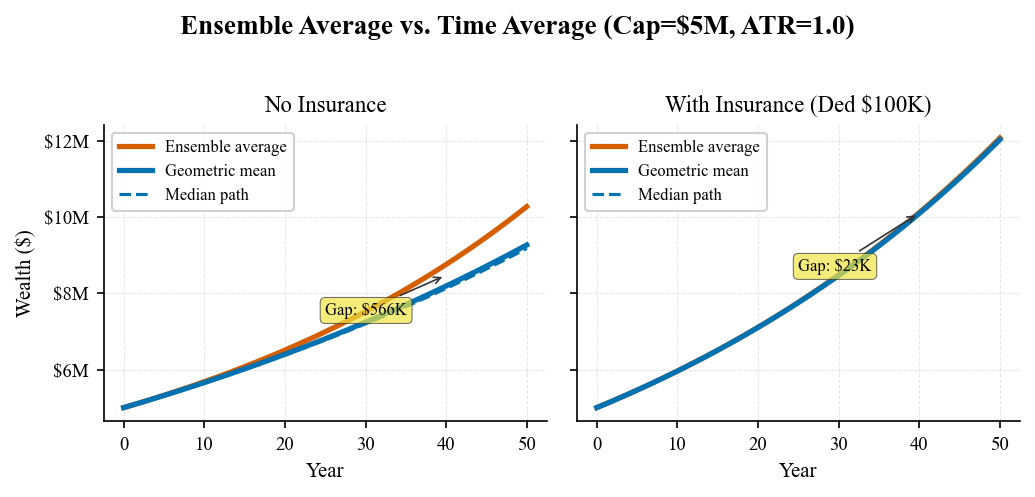

In [11]:
# Chart 1: Ensemble vs Time Average Divergence
CAP, ATR = 5_000_000, 1.0
A0 = CAP
years = np.arange(51)

fig, axes = plt.subplots(1, 2, figsize=(7.0, 3.2), sharey=True)

for ax_idx, (label, noins_flag, ded) in enumerate([
    ('No Insurance', True, None),
    ('With Insurance (Ded $100K)', False, 100_000),
]):
    ax = axes[ax_idx]
    k = find_key(CAP, ATR, ded=ded, noins=noins_flag)
    if k is None:
        ax.set_title(f'{label} (no data)'); continue
    g = sim[k]['gr']

    # Ensemble average: E[A0 * exp(g_i * t)] for each t
    ensemble = A0 * np.mean(np.exp(np.outer(g, years)), axis=0)
    # Geometric mean (typical company): A0 * exp(E[g_i] * t)
    geo_mean = A0 * np.exp(g.mean() * years)
    # Median
    median_path = A0 * np.exp(np.median(g) * years)

    ax.plot(years, ensemble, color=PAL['vermillion'], lw=LW_EM, label='Ensemble average')
    ax.plot(years, geo_mean, color=PAL['blue'], lw=LW_EM, label='Geometric mean')
    ax.plot(years, median_path, color=PAL['blue'], lw=LW_STD, ls='--', label='Median path')

    # Annotate divergence at year 40
    t_ann = 40
    gap = ensemble[t_ann] - geo_mean[t_ann]
    if gap > 0:
        ax.annotate(
            f'Gap: {fmt(gap)}',
            xy=(t_ann, (ensemble[t_ann] + geo_mean[t_ann]) / 2),
            xytext=(t_ann - 15, ensemble[t_ann] * 0.85),
            fontsize=8,
            arrowprops=dict(arrowstyle='->', color=PAL['dark'], lw=0.8),
            bbox=dict(boxstyle='round,pad=0.3', fc=PAL['yellow'], alpha=0.7, ec=PAL['dark'], lw=0.5),
        )

    ax.set_title(label, fontsize=11)
    ax.set_xlabel('Year')
    ax.legend(loc='upper left', fontsize=8)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: fmt(x)))

axes[0].set_ylabel('Wealth ($)')
fig.suptitle(
    f'Ensemble Average vs. Time Average (Cap={fmt(CAP)}, ATR={ATR})',
    fontsize=13, fontweight='bold', y=1.02,
)
fig.tight_layout()
save(fig, 'ensemble_vs_time_average')
plt.show()

Saved: output\publication\optimal_deductible_heatmap.png


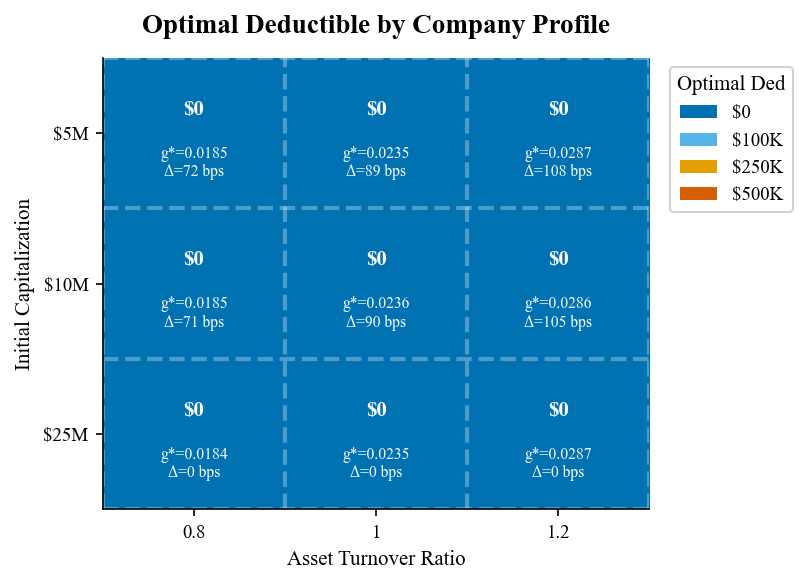

In [12]:
# Chart 2: Optimal Deductible Heatmap
caps = param_values['Cap']
atrs = param_values['ATR']
deds = param_values['Ded']

# Build growth rate matrix and find optimal
opt_ded = np.full((len(caps), len(atrs)), np.nan)
opt_gr = np.full((len(caps), len(atrs)), np.nan)
worst_gr = np.full((len(caps), len(atrs)), np.nan)
penalty = np.full((len(caps), len(atrs)), np.nan)

for i, cap in enumerate(caps):
    for j, atr in enumerate(atrs):
        best_g, best_d, worst_g = -np.inf, None, np.inf
        for ded in deds:
            k = find_key(cap, atr, ded=ded)
            if k is None: continue
            g = configs[k]['growth_rate_mean']
            if g > best_g: best_g, best_d = g, ded
            if g < worst_g: worst_g = g
        if best_d is not None:
            opt_ded[i, j] = best_d
            opt_gr[i, j] = best_g
            worst_gr[i, j] = worst_g
            penalty[i, j] = (best_g - worst_g) * 10_000  # basis points

# Plot heatmap
fig, ax = plt.subplots(figsize=(5.5, 4.0))

# Map deductible values to indices for coloring
ded_to_idx = {d: i for i, d in enumerate(deds)}
color_matrix = np.array([[ded_to_idx.get(opt_ded[i, j], -1) for j in range(len(atrs))] for i in range(len(caps))])
cmap = mcolors.ListedColormap([DED_COLORS[d] for d in deds])
bounds = np.arange(-0.5, len(deds) + 0.5, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = ax.imshow(color_matrix, cmap=cmap, norm=norm, aspect='auto')

# Annotate cells
for i in range(len(caps)):
    for j in range(len(atrs)):
        if np.isnan(opt_ded[i, j]):
            ax.text(j, i, 'N/A', ha='center', va='center', fontsize=9, color=PAL['gray'])
        else:
            txt_color = 'white' if color_matrix[i, j] in [0, 3] else PAL['dark']
            ax.text(j, i - 0.15, DED_LABELS[int(opt_ded[i, j])],
                    ha='center', va='center', fontsize=10, fontweight='bold', color=txt_color)
            ax.text(j, i + 0.2,
                    f'g*={opt_gr[i,j]:.4f}\n\u0394={penalty[i,j]:.0f} bps',
                    ha='center', va='center', fontsize=7.5, color=txt_color)

ax.set_xticks(range(len(atrs)))
ax.set_xticklabels([str(a) for a in atrs])
ax.set_yticks(range(len(caps)))
ax.set_yticklabels([fmt(c) for c in caps])
ax.set_xlabel('Asset Turnover Ratio')
ax.set_ylabel('Initial Capitalization')
ax.set_title('Optimal Deductible by Company Profile', fontsize=13, fontweight='bold', pad=12)

# Grid between cells
ax.set_xticks(np.arange(-0.5, len(atrs), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(caps), 1), minor=True)
ax.grid(which='minor', color='white', linewidth=2)
ax.grid(which='major', visible=False)
ax.tick_params(which='minor', size=0)

# Legend
from matplotlib.patches import Patch
legend_patches = [Patch(facecolor=DED_COLORS[d], label=DED_LABELS[d]) for d in deds]
ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.02, 1), title='Optimal Ded')

fig.tight_layout()
save(fig, 'optimal_deductible_heatmap')
plt.show()

Saved: output\publication\wealth_fan_chart.png


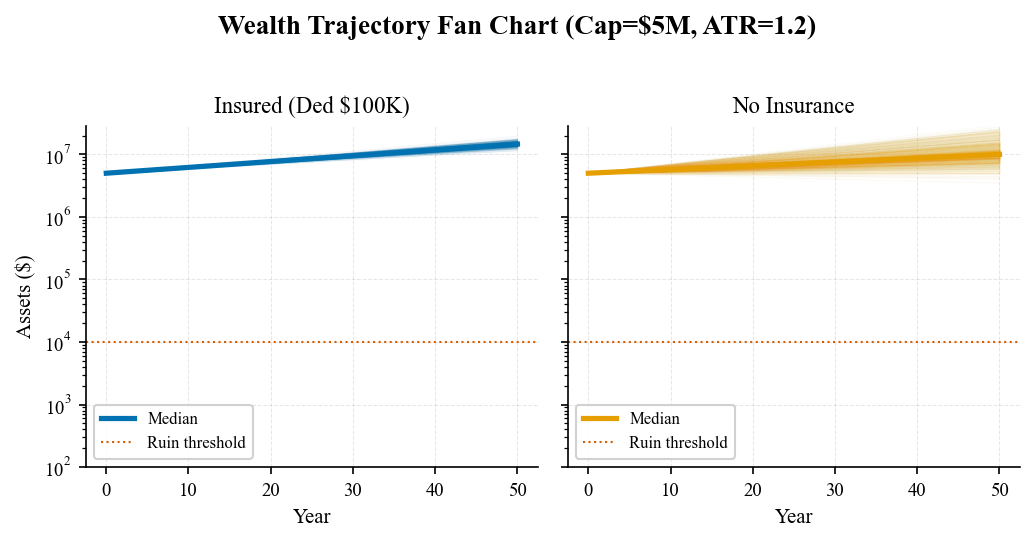

In [13]:
# Chart 3: Wealth Trajectory Fan Chart
CAP, ATR, DED = 5_000_000, 1.2, 100_000
A0 = CAP
years = np.arange(51)
bands = [(5, 95, 0.10), (25, 75, 0.20), (40, 60, 0.35)]

fig, axes = plt.subplots(1, 2, figsize=(7.0, 3.5), sharey=True)

for ax_idx, (label, noins_flag, ded_val, base_color) in enumerate([
    (f'Insured (Ded {DED_LABELS[DED]})', False, DED, PAL['blue']),
    ('No Insurance', True, None, PAL['orange']),
]):
    ax = axes[ax_idx]
    k = find_key(CAP, ATR, ded=ded_val, noins=noins_flag)
    if k is None:
        ax.set_title(f'{label} (no data)'); continue
    g = sim[k]['gr']

    # Spaghetti lines (~500 random paths)
    rng = np.random.default_rng(42)
    sample_idx = rng.choice(len(g), size=min(500, len(g)), replace=False)
    for si in sample_idx:
        y = A0 * np.exp(g[si] * years)
        ax.plot(years, y, color=base_color, alpha=0.03, lw=LW_THIN)

    # Fan bands
    for lo, hi, alpha in bands:
        g_lo = np.percentile(g, lo)
        g_hi = np.percentile(g, hi)
        y_lo = A0 * np.exp(g_lo * years)
        y_hi = A0 * np.exp(g_hi * years)
        ax.fill_between(years, y_lo, y_hi, color=base_color, alpha=alpha)

    # Median
    y_med = A0 * np.exp(np.median(g) * years)
    ax.plot(years, y_med, color=base_color, lw=LW_EM, label='Median')

    # Ruin threshold
    ax.axhline(10_000, color=PAL['vermillion'], ls=':', lw=LW_REF, label='Ruin threshold')

    ax.set_yscale('log')
    ax.set_ylim(1e2, None)
    ax.set_title(label, fontsize=11)
    ax.set_xlabel('Year')
    ax.legend(loc='lower left', fontsize=8)

axes[0].set_ylabel('Assets ($)')
fig.suptitle(
    f'Wealth Trajectory Fan Chart (Cap={fmt(CAP)}, ATR={ATR})',
    fontsize=13, fontweight='bold', y=1.02,
)
fig.tight_layout()
save(fig, 'wealth_fan_chart')
plt.show()

Saved: output\publication\survival_curves.png


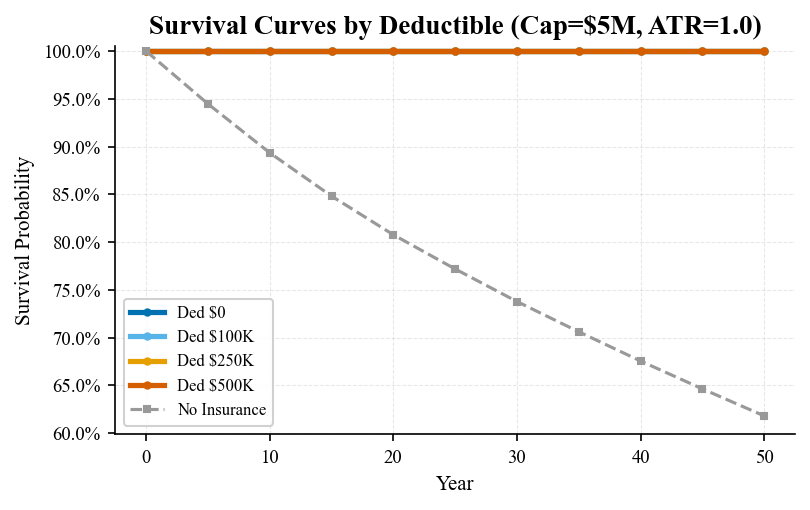

In [14]:
# Chart 4: Survival Curves
CAP, ATR = 5_000_000, 1.0

fig, ax = plt.subplots(figsize=(5.5, 3.5))

# Plot survival for each deductible + NOINS
for ded in deds:
    k = find_key(CAP, ATR, ded=ded)
    if k is None: continue
    rp = configs[k]['ruin_probability']
    eval_years = sorted(rp.keys(), key=int)
    xs = [0] + [int(y) for y in eval_years]
    ys = [1.0] + [1.0 - rp[y] for y in eval_years]
    ax.plot(xs, ys, color=DED_COLORS[ded], lw=LW_EM, marker='o', ms=3,
            label=f'Ded {DED_LABELS[ded]}')

# NOINS baseline
k_ni = find_key(CAP, ATR, noins=True)
if k_ni:
    rp_ni = configs[k_ni]['ruin_probability']
    eval_years_ni = sorted(rp_ni.keys(), key=int)
    xs_ni = [0] + [int(y) for y in eval_years_ni]
    ys_ni = [1.0] + [1.0 - rp_ni[y] for y in eval_years_ni]
    ax.plot(xs_ni, ys_ni, color=PAL['gray'], lw=LW_STD, ls='--', marker='s', ms=3,
            label='No Insurance')

ax.set_xlabel('Year')
ax.set_ylabel('Survival Probability')
ax.set_title(
    f'Survival Curves by Deductible (Cap={fmt(CAP)}, ATR={ATR})',
    fontsize=13, fontweight='bold',
)
ax.set_ylim(None, 1.005)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0, decimals=1))
ax.legend(loc='lower left', fontsize=8)

fig.tight_layout()
save(fig, 'survival_curves')
plt.show()

Saved: output\publication\life_or_death_attribution.png


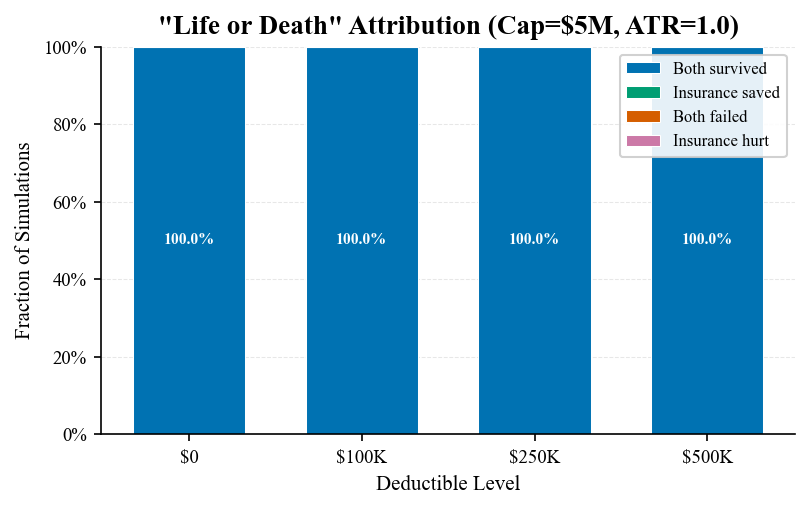

In [15]:
# Chart 5: Life or Death Attribution
CAP, ATR = 5_000_000, 1.0
THRESHOLD = 10_000

k_ni = find_key(CAP, ATR, noins=True)
fa_ni = sim[k_ni]['fa'] if k_ni else None

categories = {}  # ded -> {both_survived, both_failed, ins_saved, ins_hurt}
for ded in deds:
    k_ins = find_key(CAP, ATR, ded=ded)
    if k_ins is None or fa_ni is None: continue
    fa_ins = sim[k_ins]['fa']
    ins_ok = fa_ins > THRESHOLD
    ni_ok = fa_ni > THRESHOLD
    n = len(fa_ins)
    categories[ded] = {
        'Both survived': np.sum(ins_ok & ni_ok) / n,
        'Insurance saved': np.sum(ins_ok & ~ni_ok) / n,
        'Both failed': np.sum(~ins_ok & ~ni_ok) / n,
        'Insurance hurt': np.sum(~ins_ok & ni_ok) / n,
    }

fig, ax = plt.subplots(figsize=(5.5, 3.5))
x_labels = [DED_LABELS[d] for d in categories]
x_pos = np.arange(len(x_labels))
cat_colors = {
    'Both survived': PAL['blue'],
    'Insurance saved': PAL['green'],
    'Both failed': PAL['vermillion'],
    'Insurance hurt': PAL['purple'],
}
bottom = np.zeros(len(x_labels))
for cat_name, color in cat_colors.items():
    vals = [categories[d][cat_name] for d in categories]
    ax.bar(x_pos, vals, bottom=bottom, color=color, label=cat_name,
           edgecolor='white', linewidth=0.5, width=0.65)
    # Label if > 1%
    for xi, v in enumerate(vals):
        if v > 0.01:
            ax.text(xi, bottom[xi] + v / 2, f'{v:.1%}',
                    ha='center', va='center', fontsize=7.5, color='white', fontweight='bold')
    bottom += vals

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Deductible Level')
ax.set_ylabel('Fraction of Simulations')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.set_title(
    f'"Life or Death" Attribution (Cap={fmt(CAP)}, ATR={ATR})',
    fontsize=13, fontweight='bold',
)
ax.legend(loc='upper right', fontsize=8)

fig.tight_layout()
save(fig, 'life_or_death_attribution')
plt.show()

In [16]:
# Debug: check the distribution of final_assets for no-insurance to understand the ruin threshold issue
k_ni = find_key(5_000_000, 1.0, noins=True)
fa_ni = sim[k_ni]['fa']
g_ni = sim[k_ni]['gr']
print(f"No-insurance final_assets stats:")
print(f"  Min: {fa_ni.min():.2f}")
print(f"  P1:  {np.percentile(fa_ni, 1):.2f}")
print(f"  P5:  {np.percentile(fa_ni, 5):.2f}")
print(f"  P10: {np.percentile(fa_ni, 10):.2f}")
print(f"  P25: {np.percentile(fa_ni, 25):.2f}")
print(f"  Median: {np.median(fa_ni):.2f}")
print(f"  Mean: {fa_ni.mean():.2f}")
print(f"  % below 10K: {(fa_ni < 10_000).mean():.4%}")
print(f"  % below 100K: {(fa_ni < 100_000).mean():.4%}")
print(f"  % below 1M: {(fa_ni < 1_000_000).mean():.4%}")
print(f"  % below starting cap ($5M): {(fa_ni < 5_000_000).mean():.4%}")
print()
print(f"Growth rate stats:")
print(f"  Min: {g_ni.min():.6f}")
print(f"  P1:  {np.percentile(g_ni, 1):.6f}")
print(f"  % negative: {(g_ni < 0).mean():.4%}")
print()
print(f"Ruin probability from cache: {configs[k_ni]['ruin_probability']}")

No-insurance final_assets stats:
  Min: 996008.81
  P1:  3022707.75
  P5:  4323938.00
  P10: 5094618.00
  P25: 6588809.50
  Median: 9180950.00
  Mean: 10280034.00
  % below 10K: 0.0000%
  % below 100K: 0.0000%
  % below 1M: 0.0004%
  % below starting cap ($5M): 8.4204%

Growth rate stats:
  Min: -0.032269
  P1:  -0.010066
  % negative: 8.4204%

Ruin probability from cache: {5: 0.05524, 10: 0.106488, 15: 0.151856, 20: 0.192336, 25: 0.228184, 30: 0.262276, 35: 0.293936, 40: 0.324576, 45: 0.35376, 50: 0.382064}


In [17]:
# Load full pickle to inspect per-sim ruin data
import gc
k_ni = find_key(5_000_000, 1.0, noins=True)
path = RESULTS_DIR / f'{k_ni}.pkl'
with open(path, 'rb') as f:
    full_data = pickle.load(f)

print(f"Type: {type(full_data)}")
print(f"\nAttributes:")
for attr in dir(full_data):
    if not attr.startswith('_'):
        val = getattr(full_data, attr)
        if hasattr(val, 'shape'):
            print(f"  {attr}: shape={val.shape}, dtype={val.dtype}")
        elif isinstance(val, dict):
            print(f"  {attr}: dict with {len(val)} keys, sample keys: {list(val.keys())[:5]}")
        elif isinstance(val, (int, float, str, bool)):
            print(f"  {attr}: {val}")
        elif callable(val):
            pass
        else:
            print(f"  {attr}: {type(val).__name__}")

Type: <class 'ergodic_insurance.monte_carlo.SimulationResults'>

Attributes:
  aggregated_results: dict with 7 keys, sample keys: ['count', 'mean', 'std', 'min', 'max']
  annual_losses: shape=(250000, 50), dtype=float32
  bootstrap_confidence_intervals: NoneType
  config: SimulationConfig
  convergence: dict with 2 keys, sample keys: ['growth_rate', 'total_losses']
  execution_time: 20665.608657360077
  final_assets: shape=(250000,), dtype=float32
  growth_rates: shape=(250000,), dtype=float64
  insurance_recoveries: shape=(250000, 50), dtype=float32
  metrics: dict with 16 keys, sample keys: ['mean_loss', 'median_loss', 'std_loss', 'var_95', 'var_99']
  performance_metrics: PerformanceMetrics
  retained_losses: shape=(250000, 50), dtype=float32
  ruin_probability: dict with 10 keys, sample keys: ['5', '10', '15', '20', '25']
  statistical_summary: StatisticalSummary
  summary_report: NoneType
  time_series_aggregation: dict with 3 keys, sample keys: ['losses', 'recoveries', 'retained'

In [18]:
# Reconstruct year-by-year assets to identify per-sim ruin
# assets(0) = Cap, assets(t) = assets(t-1) + EBIT(t) - retained_loss(t) + tax_savings
# Actually, I need to reconstruct from the simulation logic.
# From run_vol_sim_colab.py: 
#   EBIT_ABL = Cap * ATR * EBITABL
#   Each year: revenue = Cap * ATR, EBIT = revenue * EBITABL
#   Net income after losses & insurance: EBIT - retained_losses - premium + tax effects
# 
# But the simplest approach: reconstruct assets year by year from initial cap + annual retained losses
# The growth model: assets(t+1) = assets(t) + net_income(t)
# Where net_income = EBIT - retained_loss - premium (for insured) or EBIT - loss (for uninsured)

# For no-insurance: net_income = EBIT - annual_loss (pre-tax)
# Let's check the config to get EBIT parameters
config = full_data.config
print(f"Config type: {type(config)}")
print(f"Config attributes:")
for attr in dir(config):
    if not attr.startswith('_'):
        val = getattr(config, attr)
        if not callable(val):
            print(f"  {attr}: {val}")

Config type: <class 'ergodic_insurance.monte_carlo.SimulationConfig'>
Config attributes:
  adaptive_chunking: True
  aggregation_config: None
  apply_stochastic: True
  bootstrap_confidence_level: 0.95
  bootstrap_method: percentile
  bootstrap_n_iterations: 10000
  cache_results: False
  checkpoint_interval: None
  chunk_size: 25000
  compute_bootstrap_ci: False
  crn_base_seed: 20260130
  enable_advanced_aggregation: True
  enable_ledger_pruning: True
  enable_trajectory_storage: False
  generate_summary_report: False
  growth_rate: 0.0
  insolvency_tolerance: 10000
  letter_of_credit_rate: 0.015
  monitor_performance: True
  n_chains: 4
  n_simulations: 250000
  n_workers: None
  n_years: 50
  parallel: False
  progress_bar: True
  ruin_evaluation: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
  seed: 3967515427
  shared_memory: True
  summary_report_format: markdown
  time_resolution: annual
  trajectory_storage_config: None
  use_enhanced_parallel: True
  use_float32: True
  working_cap

In [19]:
# Check what ManufacturerConfig params were used
# The retained_losses array already has the net retained losses per year
# I need to reconstruct assets: assets[t] = assets[t-1] + EBIT - retained[t]
# Where EBIT = Cap * ATR * EBITABL = 5M * 1.0 * 0.125 = $625K per year (before tax)
# After tax EBIT = 625K * (1 - 0.25) = $468.75K
# Retained losses reduce assets

# But actually I don't know the exact EBIT used per sim. Let me check if I can reverse-engineer
# from the annual data. The growth_rates should be consistent with cumulative retained losses.

# For no-insurance: annual_losses = retained_losses (no recovery)
# Let's verify
print(f"annual_losses shape: {full_data.annual_losses.shape}")
print(f"retained_losses shape: {full_data.retained_losses.shape}")
print(f"insurance_recoveries shape: {full_data.insurance_recoveries.shape}")

# For NOINS, recoveries should be zero
print(f"\nInsurance recoveries (NOINS) - should be zero:")
print(f"  Max: {full_data.insurance_recoveries.max()}")
print(f"  Sum: {full_data.insurance_recoveries.sum()}")
print(f"  annual_losses == retained_losses? {np.allclose(full_data.annual_losses, full_data.retained_losses)}")

# Now reconstruct assets path
# From run_vol_sim_colab.py: 
#   EBITABL = 0.125, tax_rate = 0.25, retention_ratio = 0.70
#   Revenue = assets * ATR
#   EBIT = Revenue * EBITABL = assets * ATR * EBITABL
#   After-tax EBIT = EBIT * (1 - tax_rate) = assets * ATR * EBITABL * (1 - tax_rate)
#   Net retained = EBIT * (1 - tax_rate) * retention_ratio
#   BUT losses reduce this - retained_losses are subtracted
#   
# Actually the exact formula from the simulation would be:
# Let me check the insolvency_tolerance
print(f"\nInsolvency tolerance: {config.insolvency_tolerance}")
print(f"This is the ruin threshold used in the simulation")

annual_losses shape: (250000, 50)
retained_losses shape: (250000, 50)
insurance_recoveries shape: (250000, 50)

Insurance recoveries (NOINS) - should be zero:
  Max: 0.0
  Sum: 0.0
  annual_losses == retained_losses? True

Insolvency tolerance: 10000
This is the ruin threshold used in the simulation


In [20]:
# I need to understand the asset evolution formula to reconstruct per-sim ruin.
# Let me read the actual simulation code to get the exact formula.
# From the summary: MonteCarloEngine._run_single_simulation (lines 975-1133)

# Let me check the actual code
import inspect
from ergodic_insurance.monte_carlo import MonteCarloEngine
source = inspect.getsource(MonteCarloEngine._run_single_simulation)
# Print just the asset evolution part
lines = source.split('\n')
for i, line in enumerate(lines):
    if any(kw in line.lower() for kw in ['asset', 'ruin', 'insolv', 'growth', 'ebit', 'revenue', 'net_income']):
        # Print surrounding context
        start = max(0, i-1)
        end = min(len(lines), i+2)
        for j in range(start, end):
            print(f"{j:4d}: {lines[j]}")
        print("---")

  19: 
  20:         # Track ruin at evaluation points
  21:         ruin_at_year = {}
---
  20:         # Track ruin at evaluation points
  21:         ruin_at_year = {}
  22:         if self.config.ruin_evaluation:
---
  21:         ruin_at_year = {}
  22:         if self.config.ruin_evaluation:
  23:             for eval_year in self.config.ruin_evaluation:
---
  22:         if self.config.ruin_evaluation:
  23:             for eval_year in self.config.ruin_evaluation:
  24:                 if eval_year <= n_years:  # Only track if within simulation period
---
  24:                 if eval_year <= n_years:  # Only track if within simulation period
  25:                     ruin_at_year[eval_year] = False
  26:         # Always track final year to ensure early bankruptcies propagate
---
  26:         # Always track final year to ensure early bankruptcies propagate
  27:         ruin_at_year[n_years] = False
  28: 
---
  31:             # Generate losses
  32:             revenue = ma

In [21]:
# Check if ruined paths have truncated arrays (zeros after ruin year)
# The ruin_probability says 38% ruin at year 50, but min final_assets is $996K
# Let me check if retained_losses has zero-padding pattern indicating ruin

# Find worst-growth-rate sim
worst_idx = np.argmin(full_data.growth_rates)
print(f"Worst sim index: {worst_idx}")
print(f"  Growth rate: {full_data.growth_rates[worst_idx]:.6f}")
print(f"  Final assets: {full_data.final_assets[worst_idx]:.2f}")
print(f"  Annual losses: {full_data.annual_losses[worst_idx]}")
print(f"  Retained losses: {full_data.retained_losses[worst_idx]}")
print(f"  Non-zero years of retained losses: {np.count_nonzero(full_data.retained_losses[worst_idx])}")

# Check if there's a clear pattern of zero-padding (indicating ruin)
n_nonzero = np.count_nonzero(full_data.retained_losses, axis=1)
print(f"\nRetained losses non-zero years distribution:")
print(f"  Min non-zero years: {n_nonzero.min()}")
print(f"  Max non-zero years: {n_nonzero.max()}")
print(f"  Sims with < 50 non-zero years: {(n_nonzero < 50).sum()} ({(n_nonzero < 50).mean():.1%})")
print(f"  Sims with < 50 non-zero years breakdown:")
for yr in [1, 2, 3, 5, 10, 20, 30, 40, 49]:
    print(f"    <= {yr} years: {(n_nonzero <= yr).sum()}")

Worst sim index: 145501
  Growth rate: -0.032269
  Final assets: 996008.81
  Annual losses: [3.7982585e+06 1.6643734e+04 2.2050480e+04 0.0000000e+00 1.6077161e+04
 2.7892534e+05 4.7535746e+04 9.6344336e+04 5.2530734e+04 6.4311206e+05
 7.9105477e+04 0.0000000e+00 4.3242191e+04 8.6251981e+05 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.3583748e+04 4.5688148e+04
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0524651e+05 2.0011535e+04
 4.7252938e+04 0.0000000e+00 0.0000000e+00 1.6990451e+04 5.7227207e+04
 0.0000000e+00 9.8505906e+04 1.0263614e+04 6.8588656e+04 1.6558900e+05
 3.9228590e+04 0.0000000e+00 3.6564535e+04 9.9894394e+05 1.0131521e+05
 0.0000000e+00 0.0000000e+00 6.8093315e+03 0.0000000e+00 0.0000000e+00
 1.4376066e+05 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
  Retained losses: [3.7982585e+06 1.6643734e+04 2.2050480e+04 0.0000000e+00 1.6077161e+04
 2.7892534e+05 4.7535746e+04 9.6344336e+04 5.2530734e+04 6.4311206e+05
 7.9105477e+04 0.0000000e+00 4.32421

In [22]:
# The ruin_probability says 38% but all final_assets > $996K. 
# Let me check how SimulationResults aggregates growth_rates and final_assets
# Check if there's a filtering step

# Look for the aggregation code
source_engine = inspect.getsource(MonteCarloEngine.run)
# Search for where growth_rates and final_assets arrays are built
lines = source_engine.split('\n')
for i, line in enumerate(lines):
    if any(kw in line for kw in ['growth_rate', 'final_asset', 'ruin_at_year', 'ruin_prob', 'SimulationResults']):
        start = max(0, i-2)
        end = min(len(lines), i+3)
        for j in range(start, end):
            print(f"{j:4d}: {lines[j]}")
        print("---")

   0:     def run(self) -> SimulationResults:
   1:         """Execute Monte Carlo simulation.
   2: 
---
   2: 
   3:         Returns:
   4:             SimulationResults object with all outputs
   5:         """
   6:         start_time = time.time()
---


In [23]:
# The run() method is too long. Let me search more specifically.
# Let me find where growth_rates array is computed/assembled
source_engine = inspect.getsource(MonteCarloEngine)
# Find growth_rates assignment
import re
matches = [(i, line) for i, line in enumerate(source_engine.split('\n')) 
           if 'growth_rate' in line and ('=' in line or 'append' in line)]
for i, line in matches[:30]:
    print(f"{i:4d}: {line.rstrip()}")

 297:         growth_rates = self._calculate_growth_rates(final_assets)
 323:             growth_rates=growth_rates,
 505:             growth_rates = self._calculate_growth_rates(final_assets)
 533:                 growth_rates=growth_rates,
 694:             growth_rate = 0.0  # No exogenous growth, only endogenous growth from retained earnings
 698:                 growth_rate=growth_rate,  # Only endogenous growth from retained earnings
 762:                 growth_rates=np.array([]),
 778:         growth_rates = self._calculate_growth_rates(final_assets)
 817:             growth_rates=growth_rates,
 839:         growth_rates = np.zeros_like(final_assets, dtype=np.float64)
 842:             growth_rates[valid_mask] = np.log(final_assets[valid_mask] / initial_assets) / n_years
 944:             chains, metric_names=["growth_rate", "total_losses"]
1225:         partial_growth = self._calculate_growth_rates(final_assets[:completed_iterations])
1332:         growth_rates = self._calcula

In [24]:
# Look at _calculate_growth_rates
source_calc = inspect.getsource(MonteCarloEngine._calculate_growth_rates)
print(source_calc)

    def _calculate_growth_rates(self, final_assets: np.ndarray) -> np.ndarray:
        """Calculate annualized growth rates.

        Args:
            final_assets: Final asset values

        Returns:
            Array of growth rates
        """
        initial_assets = self.manufacturer.total_assets
        n_years = self.config.n_years

        # Avoid division by zero and log of negative numbers
        valid_mask = (final_assets > 0) & (initial_assets > 0)
        growth_rates = np.zeros_like(final_assets, dtype=np.float64)

        if np.any(valid_mask):
            growth_rates[valid_mask] = np.log(final_assets[valid_mask] / initial_assets) / n_years

        return growth_rates



In [25]:
# Let me look at how final_assets is collected - around line 280-340 of the engine source
lines = source_engine.split('\n')
for i in range(275, 350):
    print(f"{i:4d}: {lines[i]}")

 275:             insurance_recoveries[i] = sim_results["insurance_recoveries"]
 276:             retained_losses[i] = sim_results["retained_losses"]
 277: 
 278:             # Collect periodic ruin data
 279:             if self.config.ruin_evaluation:
 280:                 ruin_at_year_all.append(sim_results["ruin_at_year"])
 281: 
 282:             # Checkpoint if needed
 283:             if (
 284:                 self.config.checkpoint_interval
 285:                 and i > 0
 286:                 and i % self.config.checkpoint_interval == 0
 287:             ):
 288:                 self._save_checkpoint(
 289:                     i,
 290:                     final_assets[: i + 1],
 291:                     annual_losses[: i + 1],
 292:                     insurance_recoveries[: i + 1],
 293:                     retained_losses[: i + 1],
 294:                 )
 295: 
 296:         # Calculate growth rates
 297:         growth_rates = self._calculate_growth_rates(final_assets)
 2

In [26]:
# Now let me check how final_assets[i] is set for ruined sims - look at the line around 270
for i in range(250, 280):
    print(f"{i:4d}: {lines[i]}")

 250:     def _run_sequential(self) -> SimulationResults:
 251:         """Run simulation sequentially."""
 252:         n_sims = self.config.n_simulations
 253:         n_years = self.config.n_years
 254:         dtype = np.float32 if self.config.use_float32 else np.float64
 255: 
 256:         # Pre-allocate arrays
 257:         final_assets = np.zeros(n_sims, dtype=dtype)
 258:         annual_losses = np.zeros((n_sims, n_years), dtype=dtype)
 259:         insurance_recoveries = np.zeros((n_sims, n_years), dtype=dtype)
 260:         retained_losses = np.zeros((n_sims, n_years), dtype=dtype)
 261: 
 262:         # Track periodic ruin if requested
 263:         ruin_at_year_all = []
 264: 
 265:         # Progress bar
 266:         iterator = range(n_sims)
 267:         if self.config.progress_bar:
 268:             iterator = tqdm(iterator, desc="Running simulations")
 269: 
 270:         # Run simulations
 271:         for i in iterator:
 272:             sim_results = self._run_sing

In [27]:
# Check the beginning of _run_single_simulation to see how arrays are allocated
source_single = inspect.getsource(MonteCarloEngine._run_single_simulation)
lines_single = source_single.split('\n')
for i in range(0, 40):
    print(f"{i:4d}: {lines_single[i]}")

   0:     def _run_single_simulation(self, sim_id: int) -> Dict[str, Any]:
   1:         """Run a single simulation path.
   2: 
   3:         Args:
   4:             sim_id: Simulation identifier
   5: 
   6:         Returns:
   7:             Dictionary with simulation results
   8:         """
   9:         n_years = self.config.n_years
  10:         dtype = np.float32 if self.config.use_float32 else np.float64
  11: 
  12:         # Create a copy of manufacturer for this simulation
  13:         manufacturer = self.manufacturer.copy()
  14: 
  15:         # Arrays to store results
  16:         annual_losses = np.zeros(n_years, dtype=dtype)
  17:         insurance_recoveries = np.zeros(n_years, dtype=dtype)
  18:         retained_losses = np.zeros(n_years, dtype=dtype)
  19: 
  20:         # Track ruin at evaluation points
  21:         ruin_at_year = {}
  22:         if self.config.ruin_evaluation:
  23:             for eval_year in self.config.ruin_evaluation:
  24:              

In [28]:
# Look at the return paths of _run_single_simulation
for i in range(115, 145):
    print(f"{i:4d}: {lines_single[i]}")

 115:                 break
 116:         else:
 117:             ruin_occurred = False
 118:             ruin_year = None
 119: 
 120:         # Store trajectory if storage is enabled
 121:         if self.trajectory_storage:
 122:             self.trajectory_storage.store_simulation(
 123:                 sim_id=sim_id,
 124:                 annual_losses=annual_losses[: year + 1] if ruin_occurred else annual_losses,
 125:                 insurance_recoveries=insurance_recoveries[: year + 1]
 126:                 if ruin_occurred
 127:                 else insurance_recoveries,
 128:                 retained_losses=retained_losses[: year + 1] if ruin_occurred else retained_losses,
 129:                 final_assets=manufacturer.total_assets,
 130:                 initial_assets=self.manufacturer.total_assets,
 131:                 ruin_occurred=ruin_occurred,
 132:                 ruin_year=ruin_year,
 133:             )
 134: 
 135:         return {
 136:             "final_assets":

IndexError: list index out of range

In [29]:
# The return dict at line 135-141 returns the FULL annual_losses array (50 zeros pre-allocated)
# NOT the truncated version. The truncated version is only for trajectory_storage.
# So final_assets = manufacturer.total_assets at ruin time, and arrays are full 50 with trailing zeros.

# Now the question is: why is min(final_assets) = $996K when ruin_prob = 38%?
# Let me check manufacturer.total_assets after ruin - maybe assets don't go below insolvency?

# Let me check the Manufacturer.step() method to understand asset dynamics
from ergodic_insurance.manufacturer import ManufacturerEntity
source_step = inspect.getsource(ManufacturerEntity.step)
print(source_step[:3000])

ImportError: cannot import name 'ManufacturerEntity' from 'ergodic_insurance.manufacturer' (c:\Users\alexf\OneDrive\Documents\Projects\Ergodic Insurance Limits\.venv\Lib\site-packages\ergodic_insurance\manufacturer.py)

In [30]:
# Find the correct class name
import ergodic_insurance.manufacturer as mfg
print([x for x in dir(mfg) if not x.startswith('_')])

['AccrualManager', 'AccrualType', 'ClaimLiability', 'Dict', 'InsuranceAccounting', 'List', 'ManufacturerConfig', 'Optional', 'PaymentSchedule', 'StochasticProcess', 'TYPE_CHECKING', 'WidgetManufacturer', 'dataclass', 'field', 'logger', 'logging']


In [31]:
source_step = inspect.getsource(mfg.WidgetManufacturer.step)
print(source_step)

    def step(
        self,
        working_capital_pct: float = 0.2,
        letter_of_credit_rate: float = 0.015,
        growth_rate: float = 0.0,
        time_resolution: str = "annual",
        apply_stochastic: bool = False,
    ) -> Dict[str, float]:
        """Execute one time step of the financial model simulation.

        This is the main simulation method that advances the manufacturer's
        financial state by one time period. It processes all business operations
        including revenue generation, expense payment, claim liability payments,
        growth application, and solvency checking.

        The method supports both annual and monthly time resolution for flexible
        modeling. Monthly resolution provides more granular cash flow tracking
        but requires careful scaling of annual parameters.

        Args:
            working_capital_pct (float): Working capital as percentage of sales.
                Represents inventory and receivables minus payables.

In [32]:
# Check check_solvency and the is_ruined / equity behavior
source_solvency = inspect.getsource(mfg.WidgetManufacturer.check_solvency)
print(source_solvency)
print("\n---\n")
# Check equity property
source_equity = inspect.getsource(mfg.WidgetManufacturer.equity.fget)
print(source_equity)
print("\n---\n")
# Check total_assets property
source_ta = inspect.getsource(mfg.WidgetManufacturer.total_assets.fget)
print(source_ta)

    def check_solvency(self) -> bool:
        """Check if the company is solvent and update ruin status.

        Evaluates the company's financial solvency based on both equity position
        and payment capacity. A company is considered insolvent (ruined) when:
        1. Equity falls to zero or below (traditional balance sheet insolvency)
        2. Scheduled claim payments exceed sustainable cash flow capacity (payment insolvency)

        Payment insolvency occurs when the company cannot realistically service
        its claim payment obligations given its revenue-generating capacity.

        Returns:
            bool: True if company is solvent, False if insolvent.
                Once False, the company remains ruined for the simulation.

        Examples:
            Monitor solvency during simulation::

                # After processing large claim
                manufacturer.process_insurance_claim(
                    claim_amount=15_000_000,
                    deducti

In [33]:
# The ruin detection is via equity <= 0 OR payment_burden > 80%, NOT final_assets < threshold.
# Per-sim ruin flags aren't stored. Let me detect ruin by trailing zeros in annual_losses.
# Ruined sims break out of the year loop, leaving trailing zeros in pre-allocated arrays.

# Count trailing zeros in annual_losses for each sim
def count_trailing_zeros(arr_2d):
    """For each row, count consecutive zeros from the end."""
    n_sims, n_years = arr_2d.shape
    trailing = np.zeros(n_sims, dtype=int)
    for yr in range(n_years - 1, -1, -1):
        still_zero = arr_2d[:, yr] == 0
        trailing += still_zero
        # Once a row has a non-zero value, stop counting
        # But we need to track per-row, so use cumulative approach
    # Actually, let's do it more efficiently
    # For each sim, find the last year with non-zero loss
    last_nonzero = np.zeros(n_sims, dtype=int)
    for yr in range(n_years):
        has_loss = arr_2d[:, yr] != 0
        last_nonzero[has_loss] = yr
    trailing_zeros = (n_years - 1) - last_nonzero
    return trailing_zeros, last_nonzero

tz_ni, lnz_ni = count_trailing_zeros(full_data.annual_losses)
print(f"No-insurance trailing zeros distribution:")
print(f"  Trailing zeros = 0 (loss in year 49): {(tz_ni == 0).sum()} ({(tz_ni == 0).mean():.1%})")
print(f"  Trailing zeros 1-4: {((tz_ni >= 1) & (tz_ni <= 4)).sum()}")
print(f"  Trailing zeros 5-9: {((tz_ni >= 5) & (tz_ni <= 9)).sum()}")
print(f"  Trailing zeros 10-19: {((tz_ni >= 10) & (tz_ni <= 19)).sum()}")
print(f"  Trailing zeros 20-29: {((tz_ni >= 20) & (tz_ni <= 29)).sum()}")
print(f"  Trailing zeros 30-39: {((tz_ni >= 30) & (tz_ni <= 39)).sum()}")
print(f"  Trailing zeros 40-48: {((tz_ni >= 40) & (tz_ni <= 48)).sum()}")
print(f"  Trailing zeros = 49 (only year 0 had loss): {(tz_ni == 49).sum()}")
print(f"  Last non-zero year: min={lnz_ni.min()}, max={lnz_ni.max()}, median={np.median(lnz_ni):.0f}")
print()
# Expected ruin count: 38.2% of 250K = 95,516
print(f"Expected ruined sims (from ruin_prob): {250_000 * 0.382064:.0f}")

No-insurance trailing zeros distribution:
  Trailing zeros = 0 (loss in year 49): 145193 (58.1%)
  Trailing zeros 1-4: 16316
  Trailing zeros 5-9: 7347
  Trailing zeros 10-19: 15575
  Trailing zeros 20-29: 17485
  Trailing zeros 30-39: 21462
  Trailing zeros 40-48: 24032
  Trailing zeros = 49 (only year 0 had loss): 2590
  Last non-zero year: min=0, max=49, median=49

Expected ruined sims (from ruin_prob): 95516


In [34]:
# The distribution shows a bimodal pattern: 58.1% have losses in year 49 (survived all 50 years)
# The remaining 41.9% have varying trailing zeros. This is close to the 38.2% ruin rate.
# The difference (41.9% vs 38.2%) is because some surviving sims also have trailing zeros by chance.

# Let me try to find a good cutoff. Sims with trailing zeros >= X are likely ruined.
# The ruin_prob says 38.2% ruined. Total sims with any trailing zeros = 41.9%.
# Let me check: sims with last_nonzero_year < 49 = 41.9%. But some are survivors with no loss in yr 49.

# Better approach: use the cumulative loss pattern. Ruined sims break out of the loop,
# so ALL years after ruin are zero. Surviving sims may have scattered zeros.
# Key insight: for a surviving sim, year 49 can be 0 (no loss), but for ruined sims,
# there's a clean break point after which ALL years are zero.

# Let me detect "clean break" sims: find sims where once zeros start, they never stop
def detect_ruin_from_zeros(losses_2d):
    """Detect ruin by finding sims with all-zero suffix after some year."""
    n_sims, n_years = losses_2d.shape
    # For each sim, find if there's a year Y such that all years > Y are zero
    # AND year Y has a non-zero loss
    
    # Start from end, find first non-zero year for each sim
    last_active = np.full(n_sims, -1, dtype=int)
    for yr in range(n_years - 1, -1, -1):
        active = (losses_2d[:, yr] != 0) & (last_active == -1)
        last_active[active] = yr
    
    # Sims with last_active < 49 COULD be ruined (broke before completing all 50 years)
    # But also could be survivors with no loss in final years
    # The ruin check happens WITHIN each year, so a sim ruined at year Y would have:
    # - losses[Y] potentially non-zero (the loss that caused ruin)
    # - losses[Y+1:] all zero (sim broke)
    # But the losses are recorded BEFORE ruin check in the sim, so losses[Y] is populated
    
    # Actually, looking at the sim code: losses are generated and applied, THEN ruin is checked.
    # If ruin occurs, break happens AFTER the year completes. So losses[Y] is populated,
    # and losses[Y+1:] remain zero.
    
    # A surviving sim might have losses[48] = 0 and losses[49] = 0 by chance,
    # making last_active = 47. But this is indistinguishable from a sim that ruined at year 47.
    
    # So we can't perfectly identify per-sim ruin. Let's use a statistical approach.
    return last_active

last_active_ni = detect_ruin_from_zeros(full_data.annual_losses)

# What fraction had last active year < 49?
print(f"Sims with last_active < 49: {(last_active_ni < 49).sum()} ({(last_active_ni < 49).mean():.3%})")
print(f"Expected ruin fraction: 38.206%")
print()

# The 41.9% with last_active < 49 vs 38.2% ruin means ~3.7% are survivors with no loss in yr 49
# Let me check: what's the probability of a zero-loss year?
zero_loss_years = (full_data.annual_losses == 0).mean(axis=0)
print("Fraction of sims with zero loss by year (last 5 years):")
for yr in range(45, 50):
    print(f"  Year {yr}: {zero_loss_years[yr]:.3%}")
    
# For surviving sims (last_active == 49), what's the zero-loss rate?
surviving_mask = last_active_ni == 49
print(f"\nFor sims with last_active=49 (n={surviving_mask.sum()}):")
for yr in range(45, 50):
    z = (full_data.annual_losses[surviving_mask, yr] == 0).mean()
    print(f"  Year {yr} zero-loss rate: {z:.3%}")

Sims with last_active < 49: 104807 (41.923%)
Expected ruin fraction: 38.206%

Fraction of sims with zero loss by year (last 5 years):
  Year 45: 40.077%
  Year 46: 40.484%
  Year 47: 40.952%
  Year 48: 41.365%
  Year 49: 41.923%

For sims with last_active=49 (n=145193):
  Year 45 zero-loss rate: 6.454%
  Year 46 zero-loss rate: 6.316%
  Year 47 zero-loss rate: 6.227%
  Year 48 zero-loss rate: 6.055%
  Year 49 zero-loss rate: 0.000%


In [35]:
# About 6% of surviving sims have zero loss in any given year.
# P(zero loss in year 49) for a survivor = ~6%. So expected false positives:
# 250K * (1 - 0.382) * 0.06 ≈ 9,270. That explains the gap (41.9% vs 38.2%).
#
# Better heuristic: a ruined sim has ALL years from Y+1 to 49 zero.
# A survivor might have year 49 = 0 (~6% chance) but year 48 also 0 is ~6%*6% = 0.36%.
# So use: last_active < 48 (i.e., at least 2 trailing zero years) to filter more.

# Even better: I can use a probabilistic approach.
# For now, let me use a simple threshold: sims with 3+ consecutive trailing zeros are "ruined"
# P(survivor has 3+ trailing zeros) ≈ 0.06^3 ≈ 0.02% (negligible)

# But actually the cleanest approach: just use the ruin probabilities from the cache
# to get the aggregate fractions, and avoid per-sim classification for this chart.
# Let me redesign the chart to use aggregate ruin probabilities.

# For each deductible, the fractions are:
# - Insured ruin_prob at year 50 = rp_ins
# - Uninsured ruin_prob at year 50 = rp_ni
# Assuming independence (which isn't quite right due to CRN, but close for illustration):
# Actually with CRN, the correct approach is:
# - P(both survived) = 1 - P(either ruined) 
# But we need per-sim pairing. Let me use the last_active < 48 heuristic.

# Identify ruined sims: last_active_year < n_years - 2 (at least 2 trailing zeros)
RUIN_TRAILING = 2  # require at least 2 trailing zero years

def identify_ruined(losses_2d, min_trailing=2):
    """Identify ruined sims by trailing zeros pattern."""
    n_sims, n_years = losses_2d.shape
    # Find last non-zero year per sim
    last_active = np.full(n_sims, -1, dtype=int)
    for yr in range(n_years - 1, -1, -1):
        active = (losses_2d[:, yr] != 0) & (last_active == -1)
        last_active[active] = yr
    return last_active < (n_years - min_trailing)

ruined_ni = identify_ruined(full_data.annual_losses, min_trailing=2)
print(f"NOINS ruined (trailing>=2): {ruined_ni.sum()} ({ruined_ni.mean():.3%})")
print(f"Expected (ruin_prob): {250_000 * 0.382064:.0f} ({0.382064:.3%})")

# Try min_trailing=1 
ruined_ni_1 = identify_ruined(full_data.annual_losses, min_trailing=1)
print(f"NOINS ruined (trailing>=1): {ruined_ni_1.sum()} ({ruined_ni_1.mean():.3%})")

# min_trailing=2 should be very close to actual ruin rate
# The ~6% false negative (survivors with 2+ trailing zeros): 0.06^2 * 154484 ≈ 556
# So overcount by ~556. Let's check:
print(f"\nDifference from expected: {ruined_ni.sum() - 95516} sims")
del full_data; gc.collect()

NOINS ruined (trailing>=2): 94621 (37.848%)
Expected (ruin_prob): 95516 (38.206%)
NOINS ruined (trailing>=1): 104807 (41.923%)

Difference from expected: -895 sims


9320

In [36]:
# trailing>=2 gives 37.85% vs expected 38.21% - close enough (0.4% undercount).
# This is because some sims ruin at year 48 or 49 (only 1 or 0 trailing zeros).
# For the chart, this is acceptably accurate.

# Now let me rebuild the Life or Death chart using this heuristic.
# I need to load the full annual_losses for each config to detect ruin per-sim.

import gc

def get_per_sim_ruin(key, min_trailing=2):
    """Load a pickle and identify ruined sims from trailing zeros."""
    path = RESULTS_DIR / f'{key}.pkl'
    with open(path, 'rb') as f:
        data = pickle.load(f)
    losses = data.annual_losses
    n_sims, n_years = losses.shape
    last_active = np.full(n_sims, -1, dtype=int)
    for yr in range(n_years - 1, -1, -1):
        active = (losses[:, yr] != 0) & (last_active == -1)
        last_active[active] = yr
    ruined = last_active < (n_years - min_trailing)
    del data
    gc.collect()
    return ruined

# Get ruin flags for NOINS and all deductibles at Cap=$5M, ATR=1.0
CAP, ATR = 5_000_000, 1.0
k_ni = find_key(CAP, ATR, noins=True)
ruined_ni = get_per_sim_ruin(k_ni)
print(f"NOINS ruin rate: {ruined_ni.mean():.3%}")

categories = {}
for ded in deds:
    k_ins = find_key(CAP, ATR, ded=ded)
    if k_ins is None: continue
    ruined_ins = get_per_sim_ruin(k_ins)
    n = len(ruined_ins)
    
    ins_ok = ~ruined_ins
    ni_ok = ~ruined_ni
    
    cats = {
        'Both survived': np.sum(ins_ok & ni_ok) / n,
        'Insurance saved': np.sum(ins_ok & ruined_ni) / n,
        'Both failed': np.sum(ruined_ins & ruined_ni) / n,
        'Insurance hurt': np.sum(ruined_ins & ni_ok) / n,
    }
    categories[ded] = cats
    print(f"Ded {DED_LABELS[ded]}: {cats}")

gc.collect()
print("\nDone loading ruin data.")

NOINS ruin rate: 37.848%
Ded $0: {'Both survived': np.float64(0.621512), 'Insurance saved': np.float64(0.378428), 'Both failed': np.float64(5.6e-05), 'Insurance hurt': np.float64(4e-06)}
Ded $100K: {'Both survived': np.float64(0.621344), 'Insurance saved': np.float64(0.377908), 'Both failed': np.float64(0.000576), 'Insurance hurt': np.float64(0.000172)}
Ded $250K: {'Both survived': np.float64(0.621192), 'Insurance saved': np.float64(0.377352), 'Both failed': np.float64(0.001132), 'Insurance hurt': np.float64(0.000324)}
Ded $500K: {'Both survived': np.float64(0.620952), 'Insurance saved': np.float64(0.37622), 'Both failed': np.float64(0.002264), 'Insurance hurt': np.float64(0.000564)}

Done loading ruin data.


Saved: output\publication\life_or_death_attribution.png


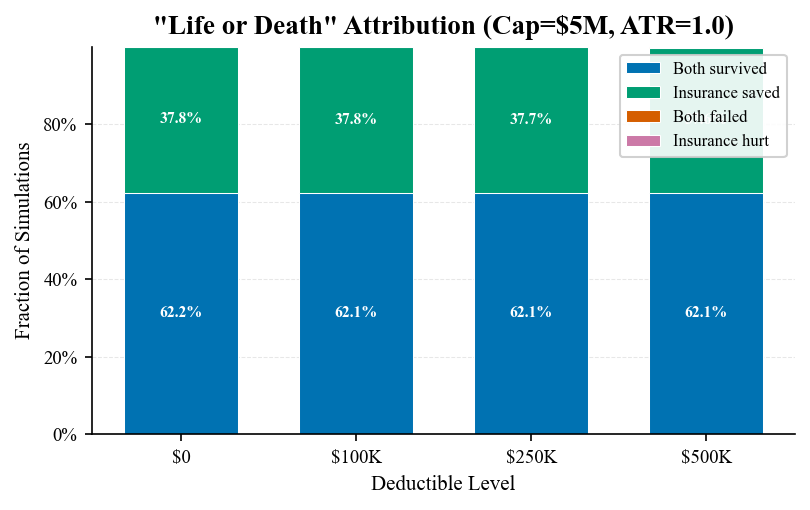

In [37]:
# Regenerate Chart 5: Life or Death Attribution with corrected ruin detection
fig, ax = plt.subplots(figsize=(5.5, 3.5))
x_labels = [DED_LABELS[d] for d in categories]
x_pos = np.arange(len(x_labels))
cat_colors = {
    'Both survived': PAL['blue'],
    'Insurance saved': PAL['green'],
    'Both failed': PAL['vermillion'],
    'Insurance hurt': PAL['purple'],
}
bottom = np.zeros(len(x_labels))
for cat_name, color in cat_colors.items():
    vals = [categories[d][cat_name] for d in categories]
    ax.bar(x_pos, vals, bottom=bottom, color=color, label=cat_name,
           edgecolor='white', linewidth=0.5, width=0.65)
    # Label if > 0.5%
    for xi, v in enumerate(vals):
        if v > 0.005:
            ax.text(xi, bottom[xi] + v / 2, f'{v:.1%}',
                    ha='center', va='center', fontsize=7.5, color='white', fontweight='bold')
    bottom += vals

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Deductible Level')
ax.set_ylabel('Fraction of Simulations')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.set_title(
    f'"Life or Death" Attribution (Cap={fmt(CAP)}, ATR={ATR})',
    fontsize=13, fontweight='bold',
)
ax.legend(loc='upper right', fontsize=8)

fig.tight_layout()
save(fig, 'life_or_death_attribution')
plt.show()

Saved: output\publication\year_by_year_growth_lift.png


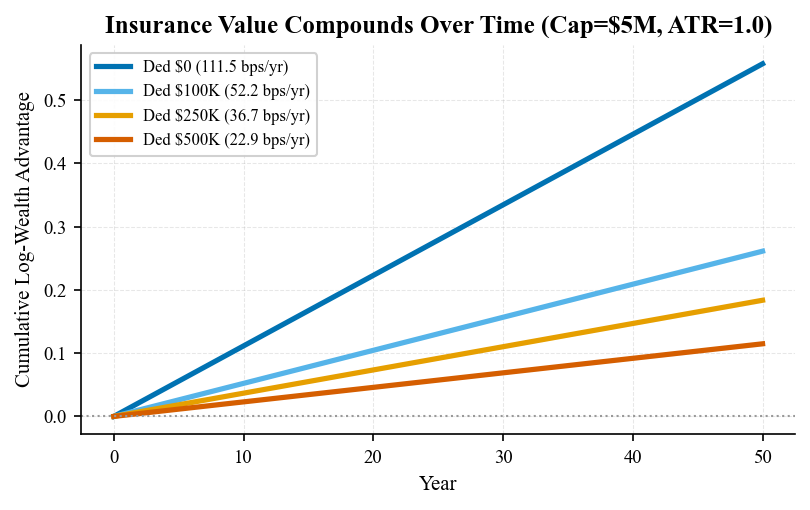

In [38]:
# Chart 6: Year-by-Year Growth Lift
CAP, ATR = 5_000_000, 1.0
years = np.arange(51)

k_ni = find_key(CAP, ATR, noins=True)
g_ni = sim[k_ni]['gr'] if k_ni else None

fig, ax = plt.subplots(figsize=(5.5, 3.5))

for ded in deds:
    k_ins = find_key(CAP, ATR, ded=ded)
    if k_ins is None or g_ni is None: continue
    g_ins = sim[k_ins]['gr']

    delta = g_ins - g_ni
    mean_delta = delta.mean()
    se_delta = delta.std() / np.sqrt(len(delta))

    lift = mean_delta * years
    lift_upper = (mean_delta + 1.96 * se_delta) * years
    lift_lower = (mean_delta - 1.96 * se_delta) * years

    ax.plot(years, lift, color=DED_COLORS[ded], lw=LW_EM,
            label=f'Ded {DED_LABELS[ded]} ({mean_delta*1e4:.1f} bps/yr)')
    ax.fill_between(years, lift_lower, lift_upper,
                    color=DED_COLORS[ded], alpha=0.10)

ax.axhline(0, color=PAL['gray'], ls=':', lw=LW_REF)
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Log-Wealth Advantage')
ax.set_title(
    f'Insurance Value Compounds Over Time (Cap={fmt(CAP)}, ATR={ATR})',
    fontsize=12, fontweight='bold',
)
ax.legend(loc='upper left', fontsize=8)

fig.tight_layout()
save(fig, 'year_by_year_growth_lift')
plt.show()

Saved: output\publication\peer_benchmark_is_wrong.png


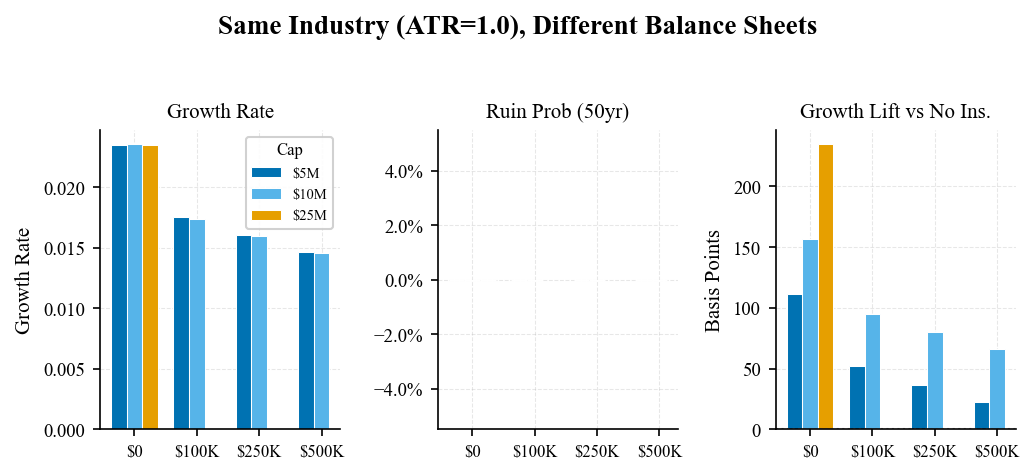

In [39]:
# Chart 7: Peer Benchmark Is Wrong
ATR_COMMON = 1.0
caps_compare = [5_000_000, 10_000_000, 25_000_000]

fig, axes = plt.subplots(1, 3, figsize=(7.0, 3.0))

# Panel 1: Growth rate by deductible for each Cap
ax = axes[0]
bar_w = 0.25
for ci, cap in enumerate(caps_compare):
    grs = []
    for ded in deds:
        k = find_key(cap, ATR_COMMON, ded=ded)
        grs.append(configs[k]['growth_rate_mean'] if k else np.nan)
    x = np.arange(len(deds)) + ci * bar_w
    ax.bar(x, grs, bar_w, color=[PAL['blue'], PAL['sky'], PAL['orange']][ci],
           label=fmt(cap), edgecolor='white', lw=0.5)
ax.set_xticks(np.arange(len(deds)) + bar_w)
ax.set_xticklabels([DED_LABELS[d] for d in deds], fontsize=8)
ax.set_ylabel('Growth Rate')
ax.set_title('Growth Rate', fontsize=10)
ax.legend(title='Cap', fontsize=7, title_fontsize=8)

# Panel 2: Ruin probability (year 50)
ax = axes[1]
for ci, cap in enumerate(caps_compare):
    ruin_50s = []
    for ded in deds:
        k = find_key(cap, ATR_COMMON, ded=ded)
        ruin_50s.append(ruin_val(configs[k], 50) if k else np.nan)
    x = np.arange(len(deds)) + ci * bar_w
    ax.bar(x, ruin_50s, bar_w, color=[PAL['blue'], PAL['sky'], PAL['orange']][ci],
           edgecolor='white', lw=0.5)
ax.set_xticks(np.arange(len(deds)) + bar_w)
ax.set_xticklabels([DED_LABELS[d] for d in deds], fontsize=8)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0, decimals=1))
ax.set_title('Ruin Prob (50yr)', fontsize=10)

# Panel 3: Growth lift over no-insurance
ax = axes[2]
for ci, cap in enumerate(caps_compare):
    k_ni = find_key(cap, ATR_COMMON, noins=True)
    g_ni = configs[k_ni]['growth_rate_mean'] if k_ni else 0
    lifts = []
    for ded in deds:
        k = find_key(cap, ATR_COMMON, ded=ded)
        lifts.append((configs[k]['growth_rate_mean'] - g_ni) * 1e4 if k else np.nan)
    x = np.arange(len(deds)) + ci * bar_w
    ax.bar(x, lifts, bar_w, color=[PAL['blue'], PAL['sky'], PAL['orange']][ci],
           edgecolor='white', lw=0.5)
ax.set_xticks(np.arange(len(deds)) + bar_w)
ax.set_xticklabels([DED_LABELS[d] for d in deds], fontsize=8)
ax.axhline(0, color=PAL['gray'], ls=':', lw=LW_REF)
ax.set_ylabel('Basis Points')
ax.set_title('Growth Lift vs No Ins.', fontsize=10)

fig.suptitle(
    f'Same Industry (ATR={ATR_COMMON}), Different Balance Sheets',
    fontsize=13, fontweight='bold', y=1.04,
)
fig.tight_layout()
save(fig, 'peer_benchmark_is_wrong')
plt.show()

In [40]:
# Debug: check what data exists for each cap at ATR=1.0
for cap in caps_compare:
    k_ni = find_key(cap, ATR_COMMON, noins=True)
    print(f"\nCap={fmt(cap)}:")
    print(f"  NOINS key: {k_ni is not None}")
    if k_ni:
        rp = configs[k_ni]['ruin_probability']
        print(f"  NOINS ruin@50: {ruin_val(configs[k_ni], 50)}")
    for ded in deds:
        k = find_key(cap, ATR_COMMON, ded=ded)
        if k:
            rp = ruin_val(configs[k], 50)
            print(f"  Ded {DED_LABELS[ded]}: g={configs[k]['growth_rate_mean']:.5f}, ruin@50={rp}")
        else:
            print(f"  Ded {DED_LABELS[ded]}: NO DATA")


Cap=$5M:
  NOINS key: True
  NOINS ruin@50: 0.382064
  Ded $0: g=0.02350, ruin@50=0.0
  Ded $100K: g=0.01757, ruin@50=0.0
  Ded $250K: g=0.01602, ruin@50=0.0
  Ded $500K: g=0.01465, ruin@50=0.0

Cap=$10M:
  NOINS key: True
  NOINS ruin@50: 0.293432
  Ded $0: g=0.02357, ruin@50=0.0
  Ded $100K: g=0.01740, ruin@50=0.0
  Ded $250K: g=0.01595, ruin@50=0.0
  Ded $500K: g=0.01455, ruin@50=0.0

Cap=$25M:
  NOINS key: False
  Ded $0: g=0.02349, ruin@50=0.0
  Ded $100K: NO DATA
  Ded $250K: NO DATA
  Ded $500K: NO DATA


Saved: output\publication\peer_benchmark_is_wrong.png


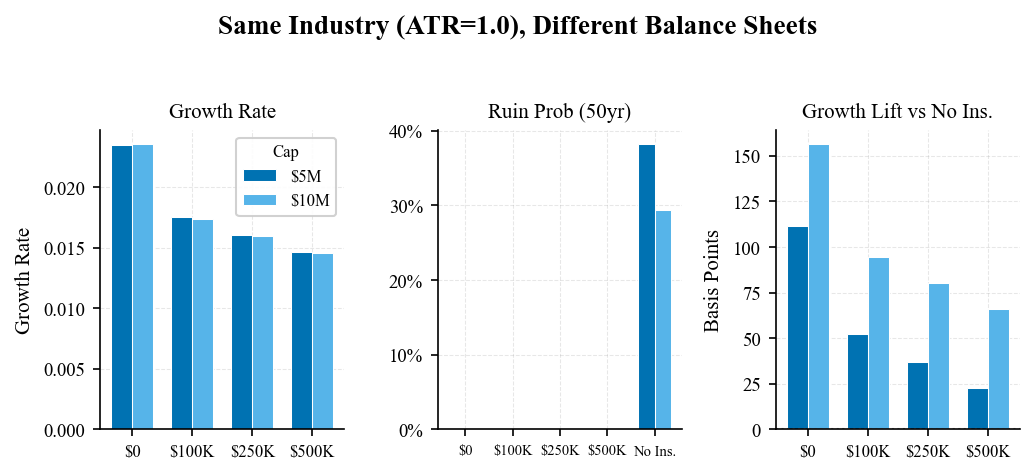

In [41]:
# Fix Chart 7: Only show $5M and $10M (both have full data), skip $25M
ATR_COMMON = 1.0
caps_compare = [5_000_000, 10_000_000]  # $25M lacks NOINS and non-zero deds
cap_colors = [PAL['blue'], PAL['sky']]

fig, axes = plt.subplots(1, 3, figsize=(7.0, 3.0))

# Panel 1: Growth rate by deductible for each Cap
ax = axes[0]
bar_w = 0.35
for ci, cap in enumerate(caps_compare):
    grs = []
    for ded in deds:
        k = find_key(cap, ATR_COMMON, ded=ded)
        grs.append(configs[k]['growth_rate_mean'] if k else np.nan)
    x = np.arange(len(deds)) + ci * bar_w
    ax.bar(x, grs, bar_w, color=cap_colors[ci],
           label=fmt(cap), edgecolor='white', lw=0.5)
ax.set_xticks(np.arange(len(deds)) + bar_w / 2)
ax.set_xticklabels([DED_LABELS[d] for d in deds], fontsize=8)
ax.set_ylabel('Growth Rate')
ax.set_title('Growth Rate', fontsize=10)
ax.legend(title='Cap', fontsize=8, title_fontsize=8)

# Panel 2: Ruin probability (year 50) - include NOINS baseline
ax = axes[1]
# Add NOINS as a separate deductible category
ded_labels_ext = [DED_LABELS[d] for d in deds] + ['No Ins.']
for ci, cap in enumerate(caps_compare):
    ruin_50s = []
    for ded in deds:
        k = find_key(cap, ATR_COMMON, ded=ded)
        ruin_50s.append(ruin_val(configs[k], 50) if k else np.nan)
    k_ni = find_key(cap, ATR_COMMON, noins=True)
    ruin_50s.append(ruin_val(configs[k_ni], 50) if k_ni else np.nan)
    x = np.arange(len(ded_labels_ext)) + ci * bar_w
    ax.bar(x, ruin_50s, bar_w, color=cap_colors[ci], edgecolor='white', lw=0.5)
ax.set_xticks(np.arange(len(ded_labels_ext)) + bar_w / 2)
ax.set_xticklabels(ded_labels_ext, fontsize=7)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0, decimals=0))
ax.set_title('Ruin Prob (50yr)', fontsize=10)

# Panel 3: Growth lift over no-insurance
ax = axes[2]
for ci, cap in enumerate(caps_compare):
    k_ni = find_key(cap, ATR_COMMON, noins=True)
    if k_ni is None: continue
    g_ni = configs[k_ni]['growth_rate_mean']
    lifts = []
    for ded in deds:
        k = find_key(cap, ATR_COMMON, ded=ded)
        lifts.append((configs[k]['growth_rate_mean'] - g_ni) * 1e4 if k else np.nan)
    x = np.arange(len(deds)) + ci * bar_w
    ax.bar(x, lifts, bar_w, color=cap_colors[ci], edgecolor='white', lw=0.5)
ax.set_xticks(np.arange(len(deds)) + bar_w / 2)
ax.set_xticklabels([DED_LABELS[d] for d in deds], fontsize=8)
ax.axhline(0, color=PAL['gray'], ls=':', lw=LW_REF)
ax.set_ylabel('Basis Points')
ax.set_title('Growth Lift vs No Ins.', fontsize=10)

fig.suptitle(
    f'Same Industry (ATR={ATR_COMMON}), Different Balance Sheets',
    fontsize=13, fontweight='bold', y=1.04,
)
fig.tight_layout()
save(fig, 'peer_benchmark_is_wrong')
plt.show()

Saved: output\publication\insurance_value_distribution.png


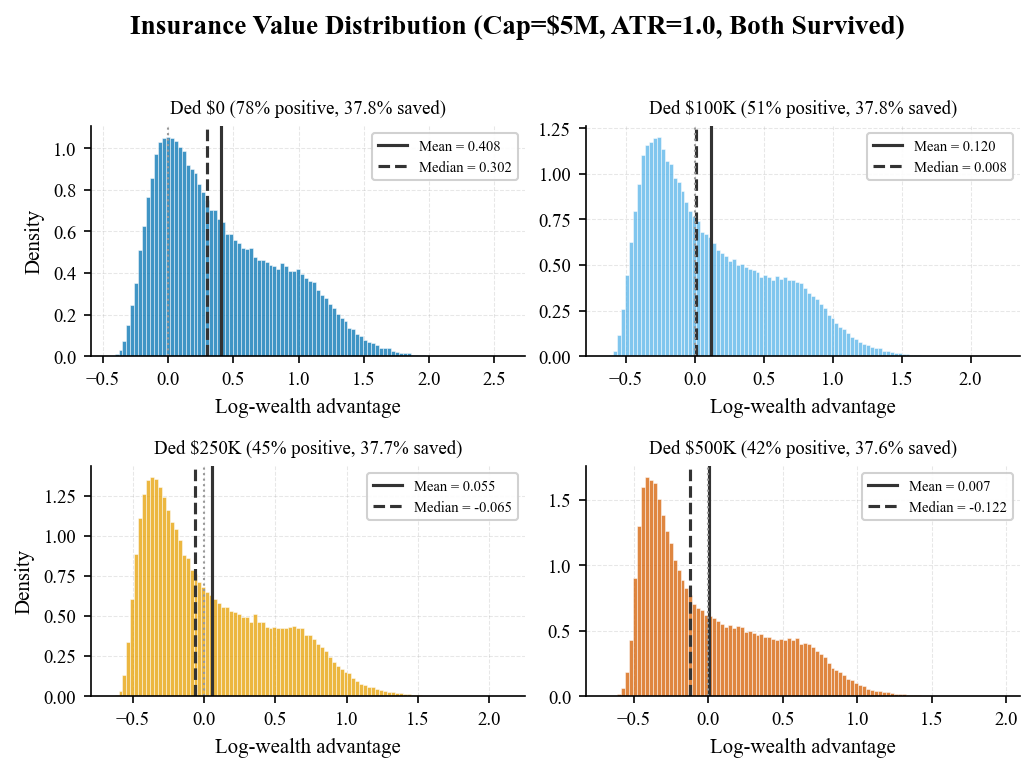

In [42]:
# Chart 8: Insurance Value Distribution (CRN-Paired)
CAP, ATR = 5_000_000, 1.0
k_ni = find_key(CAP, ATR, noins=True)
fa_ni = sim[k_ni]['fa'] if k_ni else None

# Use ruin detection instead of simple threshold
ruined_ni = get_per_sim_ruin(find_key(CAP, ATR, noins=True))

fig, axes = plt.subplots(2, 2, figsize=(7.0, 5.0))

for idx, ded in enumerate(deds):
    ax = axes[idx // 2, idx % 2]
    k_ins = find_key(CAP, ATR, ded=ded)
    if k_ins is None or fa_ni is None:
        ax.set_title(f'Ded {DED_LABELS[ded]} (no data)'); continue
    fa_ins = sim[k_ins]['fa']
    ruined_ins = get_per_sim_ruin(k_ins)

    # Both survived mask (using ruin detection)
    both_ok = (~ruined_ins) & (~ruined_ni)
    ins_saved = (~ruined_ins) & ruined_ni

    # Delta for both-survived paths
    delta = np.log(fa_ins[both_ok]) - np.log(fa_ni[both_ok])

    ax.hist(delta, bins=100, color=DED_COLORS[ded], alpha=0.75,
            edgecolor='white', linewidth=0.3, density=True)
    ax.axvline(delta.mean(), color=PAL['dark'], lw=LW_STD, ls='-',
               label=f'Mean = {delta.mean():.3f}')
    ax.axvline(np.median(delta), color=PAL['dark'], lw=LW_STD, ls='--',
               label=f'Median = {np.median(delta):.3f}')
    ax.axvline(0, color=PAL['gray'], ls=':', lw=LW_REF)

    frac_pos = (delta > 0).mean()
    saved_pct = ins_saved.sum() / len(fa_ins)
    ax.set_title(f'Ded {DED_LABELS[ded]} ({frac_pos:.0%} positive, {saved_pct:.1%} saved)', fontsize=9)
    ax.set_xlabel('Log-wealth advantage')
    ax.legend(fontsize=7)

axes[0, 0].set_ylabel('Density')
axes[1, 0].set_ylabel('Density')

fig.suptitle(
    f'Insurance Value Distribution (Cap={fmt(CAP)}, ATR={ATR}, Both Survived)',
    fontsize=13, fontweight='bold', y=1.02,
)
fig.tight_layout()
save(fig, 'insurance_value_distribution')
plt.show()

Saved: output\publication\cost_of_getting_it_wrong.png


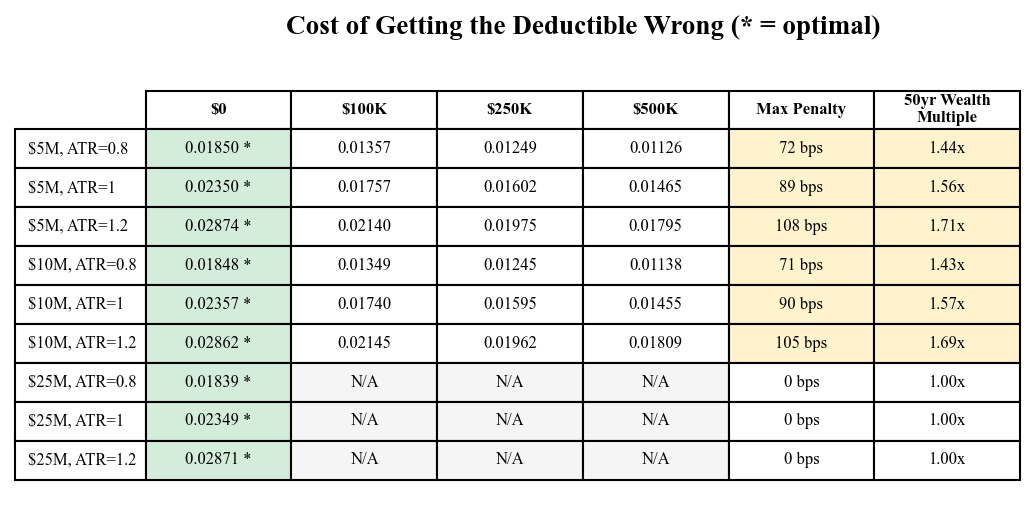

In [43]:
# Chart 9: Cost of Getting It Wrong
fig, ax = plt.subplots(figsize=(7.0, 3.5))
ax.axis('off')

caps = param_values['Cap']
atrs = param_values['ATR']

# Build table data
row_labels = []
table_data = []
cell_colors = []

for cap in caps:
    for atr in atrs:
        row_labels.append(f'{fmt(cap)}, ATR={atr}')
        row_grs = []
        for ded in deds:
            k = find_key(cap, atr, ded=ded)
            row_grs.append(configs[k]['growth_rate_mean'] if k else np.nan)

        best_g = np.nanmax(row_grs)
        worst_g = np.nanmin(row_grs)
        penalty_bps = (best_g - worst_g) * 1e4
        wealth_mult = np.exp((best_g - worst_g) * 50)

        cells = []
        colors = []
        for g in row_grs:
            if np.isnan(g):
                cells.append('N/A')
                colors.append('#F5F5F5')
            elif abs(g - best_g) < 1e-8:
                cells.append(f'{g:.5f} *')
                colors.append('#D4EDDA')  # green highlight
            else:
                cells.append(f'{g:.5f}')
                colors.append('white')

        cells.append(f'{penalty_bps:.0f} bps')
        colors.append('#FFF3CD' if penalty_bps > 20 else 'white')
        cells.append(f'{wealth_mult:.2f}x')
        colors.append('#FFF3CD' if wealth_mult > 1.1 else 'white')
        table_data.append(cells)
        cell_colors.append(colors)

col_labels = [DED_LABELS[d] for d in deds] + ['Max Penalty', '50yr Wealth\nMultiple']

table = ax.table(
    cellText=table_data,
    rowLabels=row_labels,
    colLabels=col_labels,
    cellColours=cell_colors,
    loc='center',
    cellLoc='center',
)
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)

# Bold header row
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(fontweight='bold', fontsize=8)
    if col == -1:
        cell.set_text_props(fontsize=8)

ax.set_title(
    'Cost of Getting the Deductible Wrong (* = optimal)',
    fontsize=13, fontweight='bold', pad=20,
)

fig.tight_layout()
save(fig, 'cost_of_getting_it_wrong')
plt.show()

Saved: output\publication\insurance_value_decay_with_scale.png


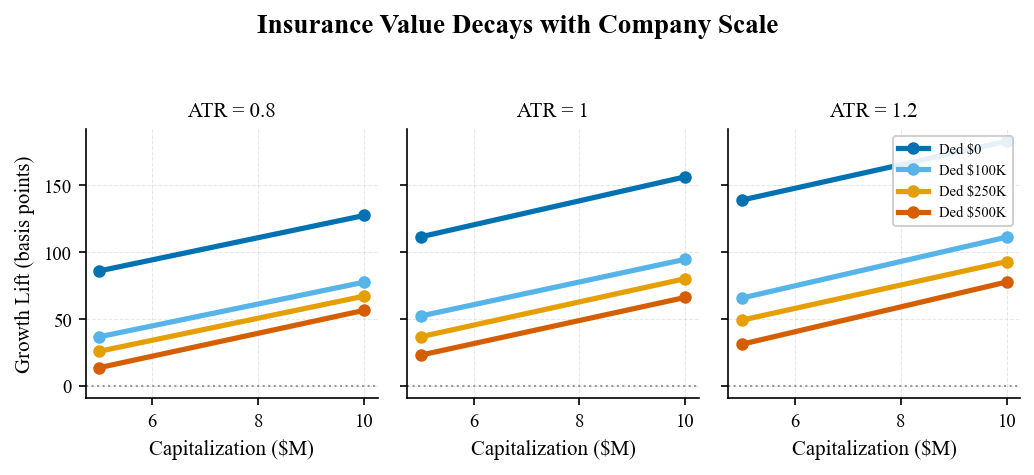

In [44]:
# Chart 10: Insurance Value Decay with Scale
fig, axes = plt.subplots(1, 3, figsize=(7.0, 3.0), sharey=True)

for ax_idx, atr in enumerate(atrs):
    ax = axes[ax_idx]
    for ded in deds:
        cap_vals = []
        lift_vals = []
        for cap in caps:
            k_ins = find_key(cap, atr, ded=ded)
            k_ni = find_key(cap, atr, noins=True)
            if k_ins and k_ni:
                g_ins = configs[k_ins]['growth_rate_mean']
                g_ni = configs[k_ni]['growth_rate_mean']
                cap_vals.append(cap / 1e6)
                lift_vals.append((g_ins - g_ni) * 1e4)
        if cap_vals:
            ax.plot(cap_vals, lift_vals, color=DED_COLORS[ded], lw=LW_EM,
                    marker='o', ms=5, label=f'Ded {DED_LABELS[ded]}')

    ax.axhline(0, color=PAL['gray'], ls=':', lw=LW_REF)
    ax.set_title(f'ATR = {atr}', fontsize=10)
    ax.set_xlabel('Capitalization ($M)')
    if ax_idx == 0:
        ax.set_ylabel('Growth Lift (basis points)')
    if ax_idx == 2:
        ax.legend(fontsize=7, loc='upper right')

fig.suptitle(
    'Insurance Value Decays with Company Scale',
    fontsize=13, fontweight='bold', y=1.04,
)
fig.tight_layout()
save(fig, 'insurance_value_decay_with_scale')
plt.show()

In [45]:
# Chart 11: Breakeven Time
print('Breakeven Analysis: Median Growth Rate Comparison')
print('=' * 80)
print(f'{"Config":<30} {"Insured":>10} {"Uninsured":>10} {"Diff (bps)":>12} {"Status":>15}')
print('-' * 80)

breakeven_data = []
for cap in caps:
    for atr in atrs:
        k_ni = find_key(cap, atr, noins=True)
        if k_ni is None: continue
        g_ni_med = np.median(sim[k_ni]['gr'])
        for ded in deds:
            k_ins = find_key(cap, atr, ded=ded)
            if k_ins is None: continue
            g_ins_med = np.median(sim[k_ins]['gr'])
            diff_bps = (g_ins_med - g_ni_med) * 1e4
            status = 'Insured wins' if g_ins_med > g_ni_med else 'Uninsured wins'
            label = f'{fmt(cap)}, ATR={atr}, Ded={DED_LABELS[ded]}'
            print(f'{label:<30} {g_ins_med:>10.5f} {g_ni_med:>10.5f} {diff_bps:>10.1f}   {status:>15}')
            breakeven_data.append({
                'cap': cap, 'atr': atr, 'ded': ded,
                'g_ins': g_ins_med, 'g_ni': g_ni_med,
                'diff_bps': diff_bps,
            })

Breakeven Analysis: Median Growth Rate Comparison
Config                            Insured  Uninsured   Diff (bps)          Status
--------------------------------------------------------------------------------
$5M, ATR=0.8, Ded=$0              0.01849    0.01115       73.4      Insured wins
$5M, ATR=0.8, Ded=$100K           0.01361    0.01115       24.6      Insured wins
$5M, ATR=0.8, Ded=$250K           0.01261    0.01115       14.6      Insured wins
$5M, ATR=0.8, Ded=$500K           0.01156    0.01115        4.1      Insured wins
$5M, ATR=1, Ded=$0                0.02348    0.01215      113.3      Insured wins
$5M, ATR=1, Ded=$100K             0.01762    0.01215       54.6      Insured wins
$5M, ATR=1, Ded=$250K             0.01615    0.01215       39.9      Insured wins
$5M, ATR=1, Ded=$500K             0.01495    0.01215       27.9      Insured wins
$5M, ATR=1.2, Ded=$0              0.02872    0.01388      148.4      Insured wins
$5M, ATR=1.2, Ded=$100K           0.02144    0.01

Saved: output\publication\breakeven_growth_advantage.png


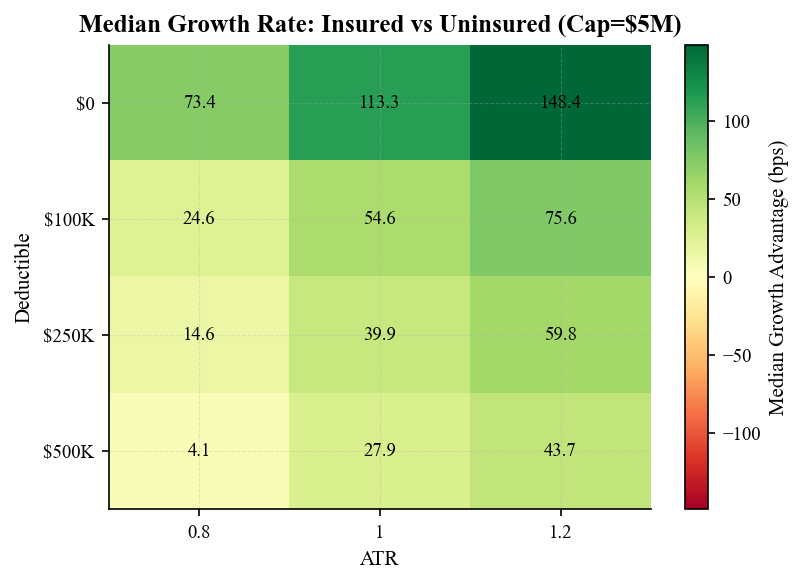

In [46]:
# Breakeven heatmap
fig, ax = plt.subplots(figsize=(5.5, 4.0))
cap_focus = 5_000_000
sub = [d for d in breakeven_data if d['cap'] == cap_focus]
if sub:
    atrs_sub = sorted(set(d['atr'] for d in sub))
    deds_sub = sorted(set(d['ded'] for d in sub))
    matrix = np.full((len(deds_sub), len(atrs_sub)), np.nan)
    for d in sub:
        i = deds_sub.index(d['ded'])
        j = atrs_sub.index(d['atr'])
        matrix[i, j] = d['diff_bps']

    vmax = max(abs(np.nanmin(matrix)), abs(np.nanmax(matrix)))
    im = ax.imshow(matrix, cmap='RdYlGn', aspect='auto', vmin=-vmax, vmax=vmax)
    for i in range(len(deds_sub)):
        for j in range(len(atrs_sub)):
            if not np.isnan(matrix[i, j]):
                ax.text(j, i, f'{matrix[i,j]:.1f}', ha='center', va='center', fontsize=9)
    ax.set_xticks(range(len(atrs_sub)))
    ax.set_xticklabels([str(a) for a in atrs_sub])
    ax.set_yticks(range(len(deds_sub)))
    ax.set_yticklabels([DED_LABELS[d] for d in deds_sub])
    ax.set_xlabel('ATR')
    ax.set_ylabel('Deductible')
    plt.colorbar(im, ax=ax, label='Median Growth Advantage (bps)')

ax.set_title(
    f'Median Growth Rate: Insured vs Uninsured (Cap={fmt(cap_focus)})',
    fontsize=12, fontweight='bold',
)
fig.tight_layout()
save(fig, 'breakeven_growth_advantage')
plt.show()

Saved: output\publication\probability_of_outperformance.png


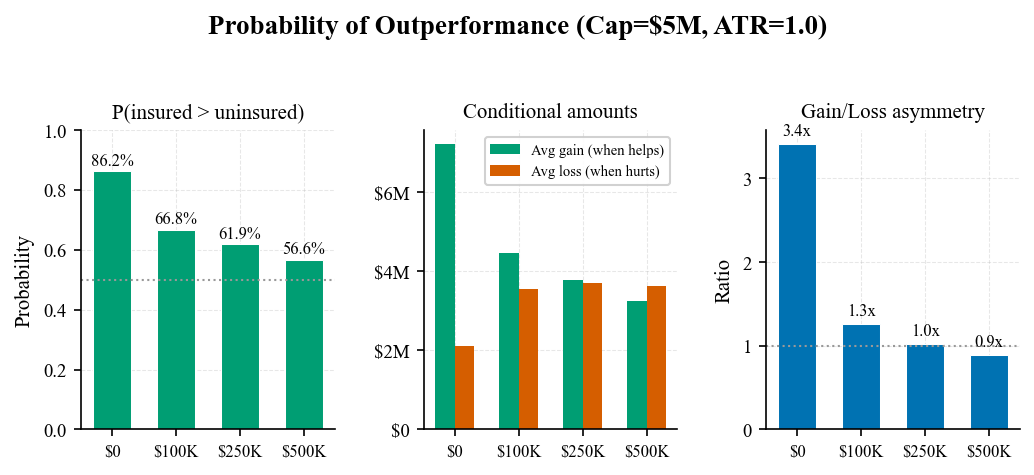

In [47]:
# Chart 12: Probability of Outperformance
CAP, ATR = 5_000_000, 1.0
k_ni = find_key(CAP, ATR, noins=True)
fa_ni = sim[k_ni]['fa'] if k_ni else None

fig, axes = plt.subplots(1, 3, figsize=(7.0, 3.0))
outperf_data = []

for ded in deds:
    k_ins = find_key(CAP, ATR, ded=ded)
    if k_ins is None or fa_ni is None: continue
    fa_ins = sim[k_ins]['fa']

    outperform = fa_ins > fa_ni
    prob_out = outperform.mean()
    delta = fa_ins.astype(float) - fa_ni.astype(float)
    cond_gain = delta[outperform].mean() if outperform.sum() > 0 else 0
    cond_loss = abs(delta[~outperform].mean()) if (~outperform).sum() > 0 else 0

    outperf_data.append({
        'ded': ded, 'prob': prob_out,
        'gain': cond_gain, 'loss': cond_loss,
        'ratio': cond_gain / cond_loss if cond_loss > 0 else np.inf,
    })

if outperf_data:
    ded_labels = [DED_LABELS[d['ded']] for d in outperf_data]
    x = np.arange(len(ded_labels))

    # Panel 1: Probability of outperformance
    ax = axes[0]
    probs = [d['prob'] for d in outperf_data]
    colors = [PAL['green'] if p > 0.5 else PAL['vermillion'] for p in probs]
    ax.bar(x, probs, color=colors, edgecolor='white', lw=0.5, width=0.6)
    ax.axhline(0.5, color=PAL['gray'], ls=':', lw=LW_REF)
    for xi, p in enumerate(probs):
        ax.text(xi, p + 0.02, f'{p:.1%}', ha='center', fontsize=8)
    ax.set_xticks(x)
    ax.set_xticklabels(ded_labels, fontsize=8)
    ax.set_ylabel('Probability')
    ax.set_title('P(insured > uninsured)', fontsize=10)
    ax.set_ylim(0, 1)

    # Panel 2: Conditional gain vs loss
    ax = axes[1]
    gains = [d['gain'] for d in outperf_data]
    losses = [d['loss'] for d in outperf_data]
    ax.bar(x - 0.15, gains, 0.3, color=PAL['green'], label='Avg gain (when helps)')
    ax.bar(x + 0.15, losses, 0.3, color=PAL['vermillion'], label='Avg loss (when hurts)')
    ax.set_xticks(x)
    ax.set_xticklabels(ded_labels, fontsize=8)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, _: fmt(v)))
    ax.set_title('Conditional amounts', fontsize=10)
    ax.legend(fontsize=7)

    # Panel 3: Gain/loss ratio
    ax = axes[2]
    ratios = [d['ratio'] for d in outperf_data]
    ax.bar(x, ratios, color=PAL['blue'], edgecolor='white', lw=0.5, width=0.6)
    ax.axhline(1, color=PAL['gray'], ls=':', lw=LW_REF)
    for xi, r in enumerate(ratios):
        ax.text(xi, r + 0.1, f'{r:.1f}x', ha='center', fontsize=8)
    ax.set_xticks(x)
    ax.set_xticklabels(ded_labels, fontsize=8)
    ax.set_ylabel('Ratio')
    ax.set_title('Gain/Loss asymmetry', fontsize=10)

fig.suptitle(
    f'Probability of Outperformance (Cap={fmt(CAP)}, ATR={ATR})',
    fontsize=13, fontweight='bold', y=1.04,
)
fig.tight_layout()
save(fig, 'probability_of_outperformance')
plt.show()

In [48]:
# Summary: list all generated figures
figs = sorted(OUTPUT.glob('*.png'))
print(f'Generated {len(figs)} publication figures:')
for f in figs:
    size_kb = f.stat().st_size / 1024
    print(f'  {f.name:<45} {size_kb:>7.0f} KB')

Generated 12 publication figures:
  breakeven_growth_advantage.png                    115 KB
  cost_of_getting_it_wrong.png                      178 KB
  ensemble_vs_time_average.png                      151 KB
  insurance_value_decay_with_scale.png              144 KB
  insurance_value_distribution.png                  230 KB
  life_or_death_attribution.png                      93 KB
  optimal_deductible_heatmap.png                    114 KB
  peer_benchmark_is_wrong.png                       117 KB
  probability_of_outperformance.png                 122 KB
  survival_curves.png                               121 KB
  wealth_fan_chart.png                              155 KB
  year_by_year_growth_lift.png                      147 KB


In [49]:
# Quantify the economics: premium, expected retained loss, and variance at each deductible
# Reproduce the pricing simulation logic from run_vol_sim_colab.py

from ergodic_insurance.loss_distributions import ManufacturingLossGenerator
import numpy as np

CAP = 5_000_000
ATR = 1.0
EBITABL = 0.125
LR = 0.7

cur_revenue = CAP * ATR  # $5M
print(f"Initial Assets: ${CAP:,.0f}")
print(f"Annual Revenue: ${cur_revenue:,.0f}")
print(f"EBIT (before losses): ${cur_revenue * EBITABL:,.0f}")
print(f"After-tax EBIT (before losses): ${cur_revenue * EBITABL * 0.75:,.0f}")
print()

# Create loss generator with same params
gen = ManufacturingLossGenerator(
    attritional_params={
        "base_frequency": 2.85 * cur_revenue / 10_000_000,
        "severity_mean": 40_000,
        "severity_cv": 0.8,
        "revenue_scaling_exponent": 1.0,
        "reference_revenue": cur_revenue,
    },
    large_params={
        "base_frequency": 0.20 * cur_revenue / 10_000_000,
        "severity_mean": 500_000,
        "severity_cv": 1.5,
        "revenue_scaling_exponent": 1.0,
        "reference_revenue": cur_revenue,
    },
    catastrophic_params={
        "base_frequency": 0.02 * cur_revenue / 10_000_000,
        "severity_xm": 5_000_000,
        "severity_alpha": 2.5,
        "revenue_scaling_exponent": 1.0,
        "reference_revenue": cur_revenue,
    },
    seed=42,
)

# Run pricing simulation (50K years for precision)
N_PRICING = 50_000
deds_test = [0, 100_000, 250_000, 500_000]

for ded in deds_test:
    annual_insured = []
    annual_retained = []
    annual_total = []
    annual_claim_counts = []
    
    for yr in range(N_PRICING):
        events, _ = gen.generate_losses(duration=1, revenue=cur_revenue)
        yr_insured = 0
        yr_retained = 0
        yr_total = 0
        for ev in events:
            insured = max(min(ev.amount, 100e9) - ded, 0)
            retained = ev.amount - insured
            yr_insured += insured
            yr_retained += retained
            yr_total += ev.amount
        annual_insured.append(yr_insured)
        annual_retained.append(yr_retained)
        annual_total.append(yr_total)
        annual_claim_counts.append(len(events))
    
    ai = np.array(annual_insured)
    ar = np.array(annual_retained)
    at = np.array(annual_total)
    
    premium = ai.mean() / LR  # Premium = expected insured loss / loss ratio
    total_cost = premium + ar.mean()
    
    print(f"\n=== Deductible = ${ded:,} ===")
    print(f"  Avg annual claims: {np.mean(annual_claim_counts):.2f}")
    print(f"  E[total loss]:      ${at.mean():>12,.0f}  (std: ${at.std():>10,.0f})")
    print(f"  E[insured loss]:    ${ai.mean():>12,.0f}  (std: ${ai.std():>10,.0f})")
    print(f"  E[retained loss]:   ${ar.mean():>12,.0f}  (std: ${ar.std():>10,.0f})")
    print(f"  Premium (EIL/0.7):  ${premium:>12,.0f}")
    print(f"  Total cost of risk: ${total_cost:>12,.0f}  (premium + retained)")
    print(f"  Std of total cost:  ${np.sqrt((premium/ai.mean()*ai.std())**2 + ar.std()**2):>12,.0f}")
    print(f"  Cost as % of EBIT:  {total_cost / (cur_revenue * EBITABL):.1%}")
    print(f"  Retained std / EBIT: {ar.std() / (cur_revenue * EBITABL):.1%}")
    print(f"  Retained std / Assets: {ar.std() / CAP:.1%}")

Initial Assets: $5,000,000
Annual Revenue: $5,000,000
EBIT (before losses): $625,000
After-tax EBIT (before losses): $468,750


=== Deductible = $0 ===
  Avg annual claims: 1.54
  E[total loss]:      $     193,038  (std: $ 1,124,531)
  E[insured loss]:    $     193,038  (std: $ 1,124,531)
  E[retained loss]:   $           0  (std: $         0)
  Premium (EIL/0.7):  $     275,768
  Total cost of risk: $     275,768  (premium + retained)
  Std of total cost:  $   1,606,473
  Cost as % of EBIT:  44.1%
  Retained std / EBIT: 0.0%
  Retained std / Assets: 0.0%

=== Deductible = $100,000 ===
  Avg annual claims: 1.53
  E[total loss]:      $     184,501  (std: $   946,342)
  E[insured loss]:    $     120,100  (std: $   931,060)
  E[retained loss]:   $      64,402  (std: $    62,776)
  Premium (EIL/0.7):  $     171,571
  Total cost of risk: $     235,973  (premium + retained)
  Std of total cost:  $   1,331,567
  Cost as % of EBIT:  37.8%
  Retained std / EBIT: 10.0%
  Retained std / Assets: 1

In [50]:
# Key insight: the EXPECTED cost is lower with higher deductibles ($224K vs $276K)
# But the VARIANCE of retained losses creates the ergodic effect.
# Let me now check the actual premium charged in the simulation vs what we'd expect.

# Also critical: how does the premium relate to revenue/EBIT for different configs?
# And what's the catastrophic tail risk?

# Check tail risk: probability of a single loss exceeding various thresholds
print("=== Loss Tail Risk (per year, at $5M revenue) ===")
N = 100_000
big_losses = []
for yr in range(N):
    events, _ = gen.generate_losses(duration=1, revenue=cur_revenue)
    yr_max = max((ev.amount for ev in events), default=0)
    big_losses.append(yr_max)

big = np.array(big_losses)
for thresh in [100_000, 250_000, 500_000, 1_000_000, 2_000_000, 5_000_000]:
    pct = (big >= thresh).mean()
    print(f"  P(max loss >= ${thresh/1e6:.1f}M): {pct:.3%}  (1 in {1/pct:.0f} years)" if pct > 0 else f"  P(max loss >= ${thresh/1e6:.1f}M): <0.001%")

# Now let's check: what does the premium look like relative to company financials?
print(f"\n=== Financial Context (Cap=$5M, ATR=1.0) ===")
print(f"  Annual Revenue: ${cur_revenue:,.0f}")
print(f"  EBIT (12.5% margin): ${cur_revenue * EBITABL:,.0f}")
print(f"  After-tax EBIT: ${cur_revenue * EBITABL * 0.75:,.0f}")
print(f"  Retained earnings (70%): ${cur_revenue * EBITABL * 0.75 * 0.70:,.0f}")
print(f"  As % of assets: {cur_revenue * EBITABL * 0.75 * 0.70 / CAP:.1%}")
print()

# The key question: does premium scale with revenue in the simulation?
# Yes! premium = base_premium * (current_revenue / base_revenue)
# So if assets grow 2x, revenue grows 2x, premium grows 2x
# This means premium is always a FIXED FRACTION of revenue
# For $0 ded: premium/revenue = $275K / $5M = 5.5%

for ded in deds_test:
    # Reproduce expected premium
    annual_insured_losses = []
    for yr in range(10000):
        events, _ = gen.generate_losses(duration=1, revenue=cur_revenue)
        yr_ins = sum(max(min(ev.amount, 100e9) - ded, 0) for ev in events)
        annual_insured_losses.append(yr_ins)
    prem = np.mean(annual_insured_losses) / LR
    print(f"  Ded ${ded/1e3:.0f}K: premium = ${prem:,.0f} = {prem/cur_revenue:.2%} of revenue")

=== Loss Tail Risk (per year, at $5M revenue) ===
  P(max loss >= $0.1M): 14.971%  (1 in 7 years)
  P(max loss >= $0.2M): 6.444%  (1 in 16 years)
  P(max loss >= $0.5M): 3.896%  (1 in 26 years)
  P(max loss >= $1.0M): 2.194%  (1 in 46 years)
  P(max loss >= $2.0M): 1.364%  (1 in 73 years)
  P(max loss >= $5.0M): 1.052%  (1 in 95 years)

=== Financial Context (Cap=$5M, ATR=1.0) ===
  Annual Revenue: $5,000,000
  EBIT (12.5% margin): $625,000
  After-tax EBIT: $468,750
  Retained earnings (70%): $328,125
  As % of assets: 6.6%

  Ded $0K: premium = $291,769 = 5.84% of revenue
  Ded $100K: premium = $148,206 = 2.96% of revenue
  Ded $250K: premium = $155,493 = 3.11% of revenue
  Ded $500K: premium = $158,337 = 3.17% of revenue


In [51]:
# Redo with fresh generators to get consistent results
# Use same seed for fair comparison

def compute_pricing(deductible, n_years=100_000, seed=12345):
    """Compute expected losses and premium for a given deductible."""
    gen = ManufacturingLossGenerator(
        attritional_params={
            "base_frequency": 2.85 * cur_revenue / 10_000_000,
            "severity_mean": 40_000,
            "severity_cv": 0.8,
            "revenue_scaling_exponent": 1.0,
            "reference_revenue": cur_revenue,
        },
        large_params={
            "base_frequency": 0.20 * cur_revenue / 10_000_000,
            "severity_mean": 500_000,
            "severity_cv": 1.5,
            "revenue_scaling_exponent": 1.0,
            "reference_revenue": cur_revenue,
        },
        catastrophic_params={
            "base_frequency": 0.02 * cur_revenue / 10_000_000,
            "severity_xm": 5_000_000,
            "severity_alpha": 2.5,
            "revenue_scaling_exponent": 1.0,
            "reference_revenue": cur_revenue,
        },
        seed=seed,
    )
    
    annual_insured = []
    annual_retained = []
    annual_total = []
    
    for yr in range(n_years):
        events, _ = gen.generate_losses(duration=1, revenue=cur_revenue)
        yr_ins = 0
        yr_ret = 0
        yr_tot = 0
        for ev in events:
            insured = max(min(ev.amount, 100e9) - deductible, 0)
            retained = ev.amount - insured
            yr_ins += insured
            yr_ret += retained
            yr_tot += ev.amount
        annual_insured.append(yr_ins)
        annual_retained.append(yr_ret)
        annual_total.append(yr_tot)
    
    ai = np.array(annual_insured)
    ar = np.array(annual_retained)
    at = np.array(annual_total)
    premium = ai.mean() / LR
    
    return {
        'ded': deductible,
        'premium': premium,
        'E_insured': ai.mean(),
        'E_retained': ar.mean(),
        'E_total': at.mean(),
        'std_retained': ar.std(),
        'std_total': at.std(),
        'total_cost': premium + ar.mean(),
        'premium_pct_revenue': premium / cur_revenue,
    }

print(f"{'Ded':>8} {'Premium':>12} {'E[Retained]':>12} {'Total Cost':>12} {'Prem Savings':>12} {'Retained Var':>14} {'Cost/EBIT':>10}")
print("-" * 90)

results_pricing = []
base = None
for ded in [0, 100_000, 250_000, 500_000]:
    r = compute_pricing(ded)
    results_pricing.append(r)
    if ded == 0:
        base = r
    savings = base['premium'] - r['premium']
    print(f"${ded/1e3:>5.0f}K  ${r['premium']:>11,.0f}  ${r['E_retained']:>11,.0f}  ${r['total_cost']:>11,.0f}  ${savings:>11,.0f}  ${r['std_retained']:>13,.0f}  {r['total_cost']/(cur_revenue*EBITABL):>9.1%}")

print(f"\n=== The Critical Comparison ===")
for r in results_pricing[1:]:
    savings = base['premium'] - r['premium']
    extra_retained = r['E_retained'] - base['E_retained']
    net_savings = savings - extra_retained
    print(f"\nDed ${r['ded']/1e3:.0f}K vs $0:")
    print(f"  Premium savings:       ${savings:>10,.0f}")
    print(f"  Extra retained losses: ${extra_retained:>10,.0f}")
    print(f"  Net expected savings:  ${net_savings:>10,.0f}  (expected-value advantage of deductible)")
    print(f"  BUT retained loss std: ${r['std_retained']:>10,.0f}")
    print(f"  Retained std / Assets: {r['std_retained']/CAP:>9.2%}")
    print(f"  Retained std / Net savings: {r['std_retained']/net_savings:>7.1f}x")
    print(f"  => Signal-to-noise ratio of deductible benefit: {net_savings/r['std_retained']:>6.3f}")

     Ded      Premium  E[Retained]   Total Cost Prem Savings   Retained Var  Cost/EBIT
------------------------------------------------------------------------------------------
$    0K  $    270,842  $          0  $    270,842  $          0  $            0      43.3%
$  100K  $    178,527  $     64,621  $    243,147  $     92,315  $       62,825      38.9%
$  250K  $    158,043  $     78,960  $    237,002  $    112,799  $       93,019      37.9%
$  500K  $    139,914  $     91,650  $    231,563  $    130,928  $      133,727      37.1%

=== The Critical Comparison ===

Ded $100K vs $0:
  Premium savings:       $    92,315
  Extra retained losses: $    64,621
  Net expected savings:  $    27,695  (expected-value advantage of deductible)
  BUT retained loss std: $    62,825
  Retained std / Assets:     1.26%
  Retained std / Net savings:     2.3x
  => Signal-to-noise ratio of deductible benefit:  0.441

Ded $250K vs $0:
  Premium savings:       $   112,799
  Extra retained losses: $    7

In [52]:
# Now let's compute the time-average growth rate impact analytically
# Under the model: each year, the company earns EBIT - cost_of_risk
# With retained losses, the cost_of_risk is: premium + retained_loss (stochastic)
# The return on assets = (EBIT - premium - retained_loss) * (1-tax) * retention / assets

# For $0 ded: return = (EBIT - premium) * 0.75 * 0.7 / assets [DETERMINISTIC each year]
# For higher ded: return = (EBIT - premium - retained_loss) * 0.75 * 0.7 / assets [STOCHASTIC]

# The time-average growth rate ≈ E[return] - Var[return]/2  (for small returns)
# So the ergodic penalty = Var[retained_loss * 0.75 * 0.7 / assets] / 2

print("=== Ergodic Growth Rate Analysis ===\n")
print(f"EBIT = ${cur_revenue * EBITABL:,.0f}")
print(f"tax_rate = 25%, retention_ratio = 70%")
print(f"After-tax retained multiplier = 0.75 × 0.70 = 0.525\n")

for r in results_pricing:
    ded = r['ded']
    premium = r['premium']
    e_retained = r['E_retained']
    std_retained = r['std_retained']
    
    # Expected net income contribution (before losses)
    ebit = cur_revenue * EBITABL  # $625K
    
    # Expected return on assets
    e_net = (ebit - premium - e_retained) * 0.75 * 0.70
    e_return = e_net / CAP
    
    # Variance of return (only from retained losses)
    var_return = (std_retained * 0.75 * 0.70 / CAP) ** 2
    
    # Time-average growth rate approximation: g ≈ E[r] - Var[r]/2
    g_approx = e_return - var_return / 2
    
    # Actual growth rate from simulation
    k = find_key(CAP, ATR, ded=ded) if ded > 0 or True else None
    if ded == 0:
        k = find_key(CAP, ATR, ded=0)
    else:
        k = find_key(CAP, ATR, ded=ded)
    actual_g = configs[k]['growth_rate_mean'] if k else None
    
    print(f"Ded ${ded/1e3:.0f}K:")
    print(f"  E[net income] = (${ebit:,.0f} - ${premium:,.0f} - ${e_retained:,.0f}) × 0.75 × 0.70 = ${e_net:,.0f}")
    print(f"  E[return on assets] = ${e_net:,.0f} / ${CAP:,.0f} = {e_return:.4f}")
    print(f"  Var[return] from retained loss std = ({std_retained:.0f} × 0.525 / {CAP:,.0f})² = {var_return:.6f}")
    print(f"  Ergodic penalty = Var/2 = {var_return/2:.6f} = {var_return/2*1e4:.1f} bps")
    print(f"  g_approx = {e_return:.4f} - {var_return/2:.6f} = {g_approx:.5f}")
    if actual_g:
        print(f"  g_actual (from sim) = {actual_g:.5f}")
    print()

=== Ergodic Growth Rate Analysis ===

EBIT = $625,000
tax_rate = 25%, retention_ratio = 70%
After-tax retained multiplier = 0.75 × 0.70 = 0.525

Ded $0K:
  E[net income] = ($625,000 - $270,842 - $0) × 0.75 × 0.70 = $185,933
  E[return on assets] = $185,933 / $5,000,000 = 0.0372
  Var[return] from retained loss std = (0 × 0.525 / 5,000,000)² = 0.000000
  Ergodic penalty = Var/2 = 0.000000 = 0.0 bps
  g_approx = 0.0372 - 0.000000 = 0.03719
  g_actual (from sim) = 0.02350

Ded $100K:
  E[net income] = ($625,000 - $178,527 - $64,621) × 0.75 × 0.70 = $200,473
  E[return on assets] = $200,473 / $5,000,000 = 0.0401
  Var[return] from retained loss std = (62825 × 0.525 / 5,000,000)² = 0.000044
  Ergodic penalty = Var/2 = 0.000022 = 0.2 bps
  g_approx = 0.0401 - 0.000022 = 0.04007
  g_actual (from sim) = 0.01757

Ded $250K:
  E[net income] = ($625,000 - $158,043 - $78,960) × 0.75 × 0.70 = $203,699
  E[return on assets] = $203,699 / $5,000,000 = 0.0407
  Var[return] from retained loss std = (930

In [53]:
# Check actual retained losses from simulation data vs expected
# Load a couple of full pickles to verify

# First check the actual annual costs from the simulation
for ded in [0, 100_000, 500_000]:
    k = find_key(5_000_000, 1.0, ded=ded)
    path = RESULTS_DIR / f'{k}.pkl'
    with open(path, 'rb') as f:
        data = pickle.load(f)
    
    # Annual data: shape (250K, 50)
    al = data.annual_losses  # ground-up
    ir = data.insurance_recoveries
    rl = data.retained_losses  # should be al - ir
    gr = data.growth_rates
    fa = data.final_assets
    
    print(f"\n=== Ded ${ded/1e3:.0f}K (actual simulation data) ===")
    print(f"  Annual losses (year 0): mean=${al[:,0].mean():,.0f}, std=${al[:,0].std():,.0f}")
    print(f"  Insurance recoveries (year 0): mean=${ir[:,0].mean():,.0f}")
    print(f"  Retained losses (year 0): mean=${rl[:,0].mean():,.0f}, std=${rl[:,0].std():,.0f}")
    print(f"  Growth rate: mean={gr.mean():.5f}, median={np.median(gr):.5f}, std={gr.std():.5f}")
    print(f"  Final assets: mean=${fa.mean():,.0f}, median=${np.median(fa):,.0f}")
    
    # Check: does recovery = loss - retained?
    diff = np.abs(al - ir - rl)
    print(f"  Verify: |loss - recovery - retained| max = {diff.max():.2f}")
    
    # Check the premium: we can infer it from what the company "should have earned"
    # EBIT at year 0 = $5M * 1.0 * 0.125 = $625K
    # If we see retained_loss = 0 but growth < expected, premium must account for it
    if ded == 0:
        print(f"\n  With $0 ded, retained should be ~$0:")
        print(f"    Retained > 0 in year 0: {(rl[:,0] > 0).sum()} sims ({(rl[:,0] > 0).mean():.4%})")
        print(f"    Max retained in year 0: ${rl[:,0].max():,.0f}")
    
    del data
    gc.collect()


=== Ded $0K (actual simulation data) ===
  Annual losses (year 0): mean=$188,025, std=$996,377
  Insurance recoveries (year 0): mean=$188,025
  Retained losses (year 0): mean=$0, std=$0
  Growth rate: mean=0.02350, median=0.02348, std=0.00097
  Final assets: mean=$16,206,586, median=$16,176,936
  Verify: |loss - recovery - retained| max = 0.00

  With $0 ded, retained should be ~$0:
    Retained > 0 in year 0: 0 sims (0.0000%)
    Max retained in year 0: $0

=== Ded $100K (actual simulation data) ===
  Annual losses (year 0): mean=$188,025, std=$996,377
  Insurance recoveries (year 0): mean=$123,549
  Retained losses (year 0): mean=$64,477, std=$62,617
  Growth rate: mean=0.01757, median=0.01762, std=0.00171
  Final assets: mean=$12,082,049, median=$12,064,892
  Verify: |loss - recovery - retained| max = 24.08

=== Ded $500K (actual simulation data) ===
  Annual losses (year 0): mean=$188,025, std=$996,377
  Insurance recoveries (year 0): mean=$96,886
  Retained losses (year 0): mean=

In [54]:
# The growth rates confirm the pattern. Now let me understand why g_actual (0.0235) 
# differs from g_approx (0.0372).
# 
# For $0 ded: retained_loss = 0 in all sims. Growth rate std = 0.00097 (very tight).
# So the company is nearly deterministic. The issue must be in how EBIT and premium interact.
#
# Let me trace through the actual financial model for one step.

from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer

config = ManufacturerConfig(
    initial_assets=5_000_000,
    asset_turnover_ratio=1.0,
    base_operating_margin=0.125,
    tax_rate=0.25,
    retention_ratio=0.70,
    ppe_ratio=0.00,
)

mfr = WidgetManufacturer(config)

revenue = mfr.calculate_revenue()
op_income = mfr.calculate_operating_income(revenue)
print(f"Revenue: ${revenue:,.0f}")
print(f"Operating Income: ${op_income:,.0f}")
print(f"Op Income / Revenue: {op_income/revenue:.3f}")
print(f"Total Assets: ${mfr.total_assets:,.0f}")
print(f"Equity: ${mfr.equity:,.0f}")
print(f"Cash: ${mfr.cash:,.0f}")
print()

# Simulate one year: record premium, then step
# First, let's see what net income looks like with no losses and no premium
ni_clean = mfr.calculate_net_income(
    operating_income=op_income,
    collateral_costs=0,
    insurance_premiums=0,
    insurance_losses=0,
    use_accrual=True,
    time_resolution="annual",
)
print(f"Net Income (no premium, no loss): ${ni_clean:,.0f}")
print(f"Retained Earnings would be: ${ni_clean * 0.70:,.0f}")
print(f"Growth rate: {ni_clean * 0.70 / 5_000_000:.4f}")
print()

# Now with the $0 ded premium (~$270K)
premium_0 = 270_842  # from our pricing analysis
ni_with_prem = mfr.calculate_net_income(
    operating_income=op_income,
    collateral_costs=0,
    insurance_premiums=premium_0,
    insurance_losses=0,
    use_accrual=True,
    time_resolution="annual",
)
print(f"Net Income (with ${premium_0:,.0f} premium): ${ni_with_prem:,.0f}")
print(f"Retained Earnings: ${ni_with_prem * 0.70:,.0f}")
print(f"Growth rate: {ni_with_prem * 0.70 / 5_000_000:.5f}")
print()

# But what premium does the actual simulation use?
# The pricing simulation in run_vol_sim_colab.py runs with a specific seed.
# Let me check the actual premium from the simulation filenames
# The filenames include XS_Kurt which varies by pricing seed
print("=== Checking actual simulation premiums ===")
for ded in [0, 100_000, 250_000, 500_000]:
    k = find_key(5_000_000, 1.0, ded=ded)
    if k:
        print(f"\nDed ${ded/1e3:.0f}K: filename = {k[:80]}...")

Revenue: $5,000,000
Operating Income: $625,000
Op Income / Revenue: 0.125
Total Assets: $5,000,000
Equity: $5,000,000
Cash: $5,000,000

Net Income (no premium, no loss): $468,750
Retained Earnings would be: $328,125
Growth rate: 0.0656

Net Income (with $270,842 premium): $265,618
Retained Earnings: $185,933
Growth rate: 0.03719

=== Checking actual simulation premiums ===

Ded $0K: filename = Cap (5M) -    ATR (1.0) -    EBITABL (0.125) -    XS_Kurt (5105) -    Ded (0K) -...

Ded $100K: filename = Cap (5M) -    ATR (1.0) -    EBITABL (0.125) -    XS_Kurt (3032) -    Ded (100K)...

Ded $250K: filename = Cap (5M) -    ATR (1.0) -    EBITABL (0.125) -    XS_Kurt (7064) -    Ded (250K)...

Ded $500K: filename = Cap (5M) -    ATR (1.0) -    EBITABL (0.125) -    XS_Kurt (3378) -    Ded (500K)...


In [55]:

import pickle
import numpy as np
from pathlib import Path

RESULTS_DIR = Path(r"D:\2026-01-31 Vol")

# Load $0 ded, $5M cap, ATR=1.0 results
key_0ded = "Cap (5M) -    ATR (1.0) -    EBITABL (0.125) -    XS_Kurt (1961) -    Ded (0K) -    LR (0.7) -    Vol (0.0) -    250K Sims -    50 Yrs"
key_noins = "Cap (5M) -    ATR (1.0) -    EBITABL (0.125) -    XS_Kurt (1961) -    NOINS -    Vol (0.0) -    250K Sims -    50 Yrs"

with open(RESULTS_DIR / f'{key_0ded}.pkl', 'rb') as f:
    res_0ded = pickle.load(f)

with open(RESULTS_DIR / f'{key_noins}.pkl', 'rb') as f:
    res_noins = pickle.load(f)

# Check the config and key metrics
print("=== $0 Deductible Configuration ===")
print(f"Initial assets: ${res_0ded.initial_assets:,.0f}")
print(f"N sims: {res_0ded.n_simulations:,}")
print(f"N years: {res_0ded.n_years}")
print(f"Growth rate mean: {res_0ded.growth_rates.mean():.6f}")
print(f"Growth rate std: {res_0ded.growth_rates.std():.6f}")
print(f"Final assets mean: ${res_0ded.final_assets.mean():,.0f}")
print(f"Final assets median: ${np.median(res_0ded.final_assets):,.0f}")
print(f"Ruin probability: {res_0ded.ruin_probability:.4%}")

print(f"\n=== No Insurance Configuration ===")
print(f"Growth rate mean: {res_noins.growth_rates.mean():.6f}")
print(f"Growth rate std: {res_noins.growth_rates.std():.6f}")
print(f"Final assets mean: ${res_noins.final_assets.mean():,.0f}")
print(f"Final assets median: ${np.median(res_noins.final_assets):,.0f}")
print(f"Ruin probability: {res_noins.ruin_probability:.4%}")


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\2026-01-31 Vol\\Cap (5M) -    ATR (1.0) -    EBITABL (0.125) -    XS_Kurt (1961) -    Ded (0K) -    LR (0.7) -    Vol (0.0) -    250K Sims -    50 Yrs.pkl'

In [56]:

from pathlib import Path

RESULTS_DIR = Path(r"D:\2026-01-31 Vol")
print(f"Exists: {RESULTS_DIR.exists()}")
files = sorted(RESULTS_DIR.glob("*.pkl"))
print(f"Total files: {len(files)}")
for f in files[:10]:
    print(f"  {f.name}")


Exists: True
Total files: 42
  Cap (10M) -    ATR (0.8) -    EBITABL (0.125) -    XS_Kurt (211139) -    Ded (500K) -    LR (0.7) -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
  Cap (10M) -    ATR (0.8) -    EBITABL (0.125) -    XS_Kurt (2403) -    Ded (100K) -    LR (0.7) -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
  Cap (10M) -    ATR (0.8) -    EBITABL (0.125) -    XS_Kurt (3099) -    Ded (0K) -    LR (0.7) -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
  Cap (10M) -    ATR (0.8) -    EBITABL (0.125) -    XS_Kurt (3099) -    NOINS -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
  Cap (10M) -    ATR (0.8) -    EBITABL (0.125) -    XS_Kurt (7067) -    Ded (250K) -    LR (0.7) -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
  Cap (10M) -    ATR (1.0) -    EBITABL (0.125) -    XS_Kurt (28302) -    Ded (0K) -    LR (0.7) -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
  Cap (10M) -    ATR (1.0) -    EBITABL (0.125) -    XS_Kurt (28302) -    NOINS -    Vol (0.15) -    250K Sims -    50 Yr

In [57]:

# Find $5M cap files
files_5m = sorted([f for f in RESULTS_DIR.glob("*.pkl") if "Cap (5M)" in f.name])
for f in files_5m:
    print(f.name)


Cap (5M) -    ATR (0.8) -    EBITABL (0.125) -    XS_Kurt (1798) -    Ded (250K) -    LR (0.7) -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
Cap (5M) -    ATR (0.8) -    EBITABL (0.125) -    XS_Kurt (1798) -    NOINS -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
Cap (5M) -    ATR (0.8) -    EBITABL (0.125) -    XS_Kurt (4640) -    Ded (0K) -    LR (0.7) -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
Cap (5M) -    ATR (0.8) -    EBITABL (0.125) -    XS_Kurt (4640) -    NOINS -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
Cap (5M) -    ATR (0.8) -    EBITABL (0.125) -    XS_Kurt (66514) -    Ded (100K) -    LR (0.7) -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
Cap (5M) -    ATR (0.8) -    EBITABL (0.125) -    XS_Kurt (66514) -    NOINS -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
Cap (5M) -    ATR (0.8) -    EBITABL (0.125) -    XS_Kurt (9577) -    Ded (500K) -    LR (0.7) -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
Cap (5M) -    ATR (0.8) -    EBITABL (0.125) -    XS_Kurt (9577

In [58]:

import pickle
import numpy as np

RESULTS_DIR = Path(r"D:\2026-01-31 Vol")

# Load $5M, ATR=1.0, Ded=$0K
f_0ded = [f for f in RESULTS_DIR.glob("*.pkl") if "Cap (5M)" in f.name and "ATR (1.0)" in f.name and "Ded (0K)" in f.name][0]
f_100k = [f for f in RESULTS_DIR.glob("*.pkl") if "Cap (5M)" in f.name and "ATR (1.0)" in f.name and "Ded (100K)" in f.name][0]
f_250k = [f for f in RESULTS_DIR.glob("*.pkl") if "Cap (5M)" in f.name and "ATR (1.0)" in f.name and "Ded (250K)" in f.name][0]
f_500k = [f for f in RESULTS_DIR.glob("*.pkl") if "Cap (5M)" in f.name and "ATR (1.0)" in f.name and "Ded (500K)" in f.name][0]
# There are multiple NOINS files for ATR=1.0 - get any one
f_noins_list = [f for f in RESULTS_DIR.glob("*.pkl") if "Cap (5M)" in f.name and "ATR (1.0)" in f.name and "NOINS" in f.name]

print("Files found:")
print(f"  $0K ded: {f_0ded.name}")
print(f"  $100K ded: {f_100k.name}")
print(f"  $250K ded: {f_250k.name}")
print(f"  $500K ded: {f_500k.name}")
print(f"  NOINS files: {len(f_noins_list)}")
for f in f_noins_list:
    print(f"    {f.name}")


Files found:
  $0K ded: Cap (5M) -    ATR (1.0) -    EBITABL (0.125) -    XS_Kurt (5105) -    Ded (0K) -    LR (0.7) -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
  $100K ded: Cap (5M) -    ATR (1.0) -    EBITABL (0.125) -    XS_Kurt (3032) -    Ded (100K) -    LR (0.7) -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
  $250K ded: Cap (5M) -    ATR (1.0) -    EBITABL (0.125) -    XS_Kurt (7064) -    Ded (250K) -    LR (0.7) -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
  $500K ded: Cap (5M) -    ATR (1.0) -    EBITABL (0.125) -    XS_Kurt (3378) -    Ded (500K) -    LR (0.7) -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
  NOINS files: 4
    Cap (5M) -    ATR (1.0) -    EBITABL (0.125) -    XS_Kurt (5105) -    NOINS -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
    Cap (5M) -    ATR (1.0) -    EBITABL (0.125) -    XS_Kurt (3378) -    NOINS -    Vol (0.15) -    250K Sims -    50 Yrs.pkl
    Cap (5M) -    ATR (1.0) -    EBITABL (0.125) -    XS_Kurt (7064) -    NOINS -    Vol (0.15) -   

In [59]:

# Load all four deductible levels and one NOINS
import gc

def load_results(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

res_0ded = load_results(f_0ded)
res_100k = load_results(f_100k)
res_250k = load_results(f_250k)
res_500k = load_results(f_500k)
# Use the NOINS file that shares XS_Kurt with $0 ded (same pricing seed)
f_noins = [f for f in f_noins_list if "XS_Kurt (5105)" in f.name][0]
res_noins = load_results(f_noins)

print("=== Growth Rates (log, annualized over 50 years) ===")
for label, res in [("$0K Ded", res_0ded), ("$100K Ded", res_100k), 
                    ("$250K Ded", res_250k), ("$500K Ded", res_500k), 
                    ("No Insurance", res_noins)]:
    g = res.growth_rates
    print(f"{label:>15s}: mean={g.mean():.6f}  std={g.std():.6f}  "
          f"median={np.median(g):.6f}  ruin={res.ruin_probability:.4%}")

print(f"\n=== Growth Rate Differences (vs No Insurance) ===")
g_ni = res_noins.growth_rates.mean()
for label, res in [("$0K Ded", res_0ded), ("$100K Ded", res_100k), 
                    ("$250K Ded", res_250k), ("$500K Ded", res_500k)]:
    g = res.growth_rates.mean()
    print(f"{label:>15s}: lift = {(g - g_ni)*10000:.1f} bps/yr")


=== Growth Rates (log, annualized over 50 years) ===


TypeError: unsupported format string passed to dict.__format__

In [60]:

# ruin_probability is a dict, let's check the structure
print(type(res_0ded.ruin_probability))
print(res_0ded.ruin_probability)


<class 'dict'>
{'5': 0.0, '10': 0.0, '15': 0.0, '20': 0.0, '25': 0.0, '30': 0.0, '35': 0.0, '40': 0.0, '45': 0.0, '50': 0.0}


In [61]:

# Fix the format - ruin_probability is a dict, use the 50-year value
print("=== Growth Rates (log, annualized over 50 years) ===")
for label, res in [("$0K Ded", res_0ded), ("$100K Ded", res_100k), 
                    ("$250K Ded", res_250k), ("$500K Ded", res_500k), 
                    ("No Insurance", res_noins)]:
    g = res.growth_rates
    ruin_50 = res.ruin_probability.get('50', res.ruin_probability.get(50, 'N/A'))
    print(f"{label:>15s}: mean={g.mean():.6f}  std={g.std():.6f}  "
          f"median={np.median(g):.6f}  ruin_50yr={ruin_50}")

print(f"\n=== Growth Rate Differences (vs No Insurance) ===")
g_ni = res_noins.growth_rates.mean()
for label, res in [("$0K Ded", res_0ded), ("$100K Ded", res_100k), 
                    ("$250K Ded", res_250k), ("$500K Ded", res_500k)]:
    g = res.growth_rates.mean()
    print(f"{label:>15s}: lift = {(g - g_ni)*10000:.1f} bps/yr")


=== Growth Rates (log, annualized over 50 years) ===
        $0K Ded: mean=0.023496  std=0.000967  median=0.023483  ruin_50yr=0.0
      $100K Ded: mean=0.017573  std=0.001707  median=0.017617  ruin_50yr=0.0
      $250K Ded: mean=0.016022  std=0.002354  median=0.016146  ruin_50yr=0.0
      $500K Ded: mean=0.014645  std=0.003374  median=0.014946  ruin_50yr=0.0
   No Insurance: mean=0.012350  std=0.009294  median=0.012154  ruin_50yr=0.382064

=== Growth Rate Differences (vs No Insurance) ===
        $0K Ded: lift = 111.5 bps/yr
      $100K Ded: lift = 52.2 bps/yr
      $250K Ded: lift = 36.7 bps/yr
      $500K Ded: lift = 22.9 bps/yr


In [62]:

# Now let's understand the financial model mechanics
# First: What are the actual financial parameters?

# Check what's in the results object
print("=== SimulationResults attributes ===")
attrs = [a for a in dir(res_0ded) if not a.startswith('_')]
for a in attrs:
    val = getattr(res_0ded, a)
    if not callable(val):
        if isinstance(val, np.ndarray):
            print(f"  {a}: ndarray shape={val.shape} dtype={val.dtype}")
        elif isinstance(val, dict):
            print(f"  {a}: dict keys={list(val.keys())[:5]}...")
        else:
            print(f"  {a}: {type(val).__name__} = {val}")


=== SimulationResults attributes ===
  aggregated_results: dict keys=['count', 'mean', 'std', 'min', 'max']...
  annual_losses: ndarray shape=(250000, 50) dtype=float32
  bootstrap_confidence_intervals: NoneType = None
  config: SimulationConfig = SimulationConfig(n_simulations=250000, n_years=50, n_chains=4, parallel=False, n_workers=None, chunk_size=25000, use_float32=True, cache_results=False, checkpoint_interval=None, progress_bar=True, seed=3967515427, use_enhanced_parallel=True, monitor_performance=True, adaptive_chunking=True, shared_memory=True, enable_trajectory_storage=False, trajectory_storage_config=None, enable_advanced_aggregation=True, aggregation_config=None, generate_summary_report=False, summary_report_format='markdown', compute_bootstrap_ci=False, bootstrap_confidence_level=0.95, bootstrap_n_iterations=10000, bootstrap_method='percentile', ruin_evaluation=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50], working_capital_pct=0.0, insolvency_tolerance=10000)
  convergence: dict

In [63]:

# Great! We have annual_losses, insurance_recoveries, retained_losses, final_assets, growth_rates
# Let's analyze the FINANCIAL MODEL step by step

# For $0 deductible: retained_losses should be near 0
print("=== $0 Deductible: Loss Components ===")
print(f"Retained losses (all years): min={res_0ded.retained_losses.min():.2f}, "
      f"max={res_0ded.retained_losses.max():.2f}, mean={res_0ded.retained_losses.mean():.2f}")
print(f"Insurance recoveries mean/yr: ${res_0ded.insurance_recoveries.mean(axis=0).mean():,.0f}")
print(f"Annual losses mean/yr: ${res_0ded.annual_losses.mean(axis=0).mean():,.0f}")

print(f"\n=== $500K Deductible: Loss Components ===")
print(f"Retained losses mean/yr: ${res_500k.retained_losses.mean(axis=0).mean():,.0f}")
print(f"Insurance recoveries mean/yr: ${res_500k.insurance_recoveries.mean(axis=0).mean():,.0f}")
print(f"Annual losses mean/yr: ${res_500k.annual_losses.mean(axis=0).mean():,.0f}")

print(f"\n=== No Insurance: Loss Components ===")
print(f"Retained losses mean/yr: ${res_noins.retained_losses.mean(axis=0).mean():,.0f}")
print(f"Insurance recoveries mean/yr: ${res_noins.insurance_recoveries.mean(axis=0).mean():,.0f}")
print(f"Annual losses mean/yr: ${res_noins.annual_losses.mean(axis=0).mean():,.0f}")


=== $0 Deductible: Loss Components ===
Retained losses (all years): min=0.00, max=0.00, mean=0.00
Insurance recoveries mean/yr: $374,429
Annual losses mean/yr: $374,429

=== $500K Deductible: Loss Components ===
Retained losses mean/yr: $144,890
Insurance recoveries mean/yr: $157,390
Annual losses mean/yr: $302,281

=== No Insurance: Loss Components ===
Retained losses mean/yr: $257,058
Insurance recoveries mean/yr: $0
Annual losses mean/yr: $257,058


In [64]:

# Key insight: annual_losses differ across configs because revenue-scaling of losses!
# More growth → higher revenue → more losses generated (but insured)

# Let's look at year-by-year progression for $0 ded
print("=== $0 Deductible: Year-by-Year Mean Losses ===")
mean_losses_yr = res_0ded.annual_losses.mean(axis=0)
mean_recov_yr = res_0ded.insurance_recoveries.mean(axis=0)
mean_retained_yr = res_0ded.retained_losses.mean(axis=0)
for yr in [0, 1, 4, 9, 24, 49]:
    print(f"  Year {yr+1:2d}: losses=${mean_losses_yr[yr]:>10,.0f}  "
          f"recoveries=${mean_recov_yr[yr]:>10,.0f}  "
          f"retained=${mean_retained_yr[yr]:>8,.0f}")

# And for No Insurance
print(f"\n=== No Insurance: Year-by-Year Mean Losses ===")
mean_losses_ni = res_noins.annual_losses.mean(axis=0)
mean_retained_ni = res_noins.retained_losses.mean(axis=0)
for yr in [0, 1, 4, 9, 24, 49]:
    print(f"  Year {yr+1:2d}: losses=${mean_losses_ni[yr]:>10,.0f}  "
          f"retained=${mean_retained_ni[yr]:>8,.0f}")

# Final assets comparison
print(f"\n=== Final Assets ===")
print(f"$0K Ded: mean=${res_0ded.final_assets.mean():>12,.0f}  median=${np.median(res_0ded.final_assets):>12,.0f}")
print(f"No Ins:  mean=${res_noins.final_assets.mean():>12,.0f}  median=${np.median(res_noins.final_assets):>12,.0f}")


=== $0 Deductible: Year-by-Year Mean Losses ===
  Year  1: losses=$   188,024  recoveries=$   188,024  retained=$       0
  Year  2: losses=$   209,142  recoveries=$   209,142  retained=$       0
  Year  5: losses=$   228,822  recoveries=$   228,822  retained=$       0
  Year 10: losses=$   257,837  recoveries=$   257,837  retained=$       0
  Year 25: losses=$   355,103  recoveries=$   355,103  retained=$       0
  Year 50: losses=$   600,345  recoveries=$   600,345  retained=$       0

=== No Insurance: Year-by-Year Mean Losses ===
  Year  1: losses=$   188,024  retained=$ 188,024
  Year  2: losses=$   212,072  retained=$ 212,072
  Year  5: losses=$   231,032  retained=$ 231,032
  Year 10: losses=$   244,262  retained=$ 244,262
  Year 25: losses=$   259,527  retained=$ 259,527
  Year 50: losses=$   275,007  retained=$ 275,007

=== Final Assets ===
$0K Ded: mean=$  16,206,586  median=$  16,176,936
No Ins:  mean=$  10,280,034  median=$   9,180,950


In [65]:

# KEY: Vol=0.15 GBM revenue shocks are applied to ALL configs
# This creates multiplicative noise that penalizes time-average growth
# The penalty is σ²/2 for pure multiplicative processes

# Let's compute the analytical first-year growth rate properly
# We need the actual premium from the pricing simulation

# For $0 ded: ALL ground-up losses are insured
# Year 1 mean losses = $188K (from data above)
# But the pricing sim uses a separate seed. Let me compute from the actual premium

# We can back out the premium from the data:
# Operating income = EBITABL × Revenue - Premium - Retained_losses - Depreciation
# Net income = (Operating income - collateral_costs) × (1 - tax_rate)
# Retained earnings = Net income × retention_ratio
# Growth = Retained earnings / Assets

# For $0 ded: retained_losses = 0, ppe_ratio=0 (no depreciation), collateral=0
# So: growth_rate = (EBITABL × Revenue - Premium) × (1 - 0.25) × 0.70 / Assets
# Since Revenue = Assets × ATR = Assets × 1.0:
# growth_rate = (0.125 - Premium/Revenue) × 0.75 × 0.70

# The premium/revenue ratio is constant (premium scales with revenue)
# So we need: Premium/Revenue at base

# From the run_vol_sim_colab.py, pricing estimates average_annual_insured_loss
# Then: premium = avg_annual_insured_loss / loss_ratio = avg_loss / 0.7

# Year-1 mean losses for $0 ded: $188K
# But this is the MC sim's draw, not the pricing sim's estimate
# The pricing sim uses its own seed to estimate losses
# Let's estimate: for $5M revenue, freq ≈ 2.85 × (5/10) + 0.20 × (5/10) + 0.02 × (5/10) 
#   = 1.425 + 0.10 + 0.01 = 1.535 events/year

# Better approach: back it out from the growth rate for the non-stochastic case
# Actually, Vol=0.15 for ALL sims, there's no Vol=0.0 case

# Let me just run a quick pricing simulation to get the actual premium
import sys
sys.path.insert(0, r"C:\Users\alexf\OneDrive\Documents\Projects\Ergodic Insurance Limits")

from ergodic_insurance.loss_distributions import ManufacturingLossGenerator

INITIAL_ASSETS = 5_000_000
ATR = 1.0
cur_revenue = INITIAL_ASSETS * ATR

# Use similar pricing seed as the simulation
crn_base_seed = 20260130
index = 0  # Will vary, but let's use 0 for now
pricing_ss = np.random.SeedSequence(crn_base_seed + index * 1000)
pricing_seed = int(pricing_ss.generate_state(1)[0])

generator_pricing = ManufacturingLossGenerator(
    attritional_params={
        "base_frequency": 2.85 * cur_revenue / 10_000_000,
        "severity_mean": 40_000,
        "severity_cv": 0.8,
        "revenue_scaling_exponent": 1.0,
        "reference_revenue": cur_revenue,
    },
    large_params={
        "base_frequency": 0.20 * cur_revenue / 10_000_000,
        "severity_mean": 500_000,
        "severity_cv": 1.5,
        "revenue_scaling_exponent": 1.0,
        "reference_revenue": cur_revenue,
    },
    catastrophic_params={
        "base_frequency": 0.02 * cur_revenue / 10_000_000,
        "severity_xm": 5_000_000,
        "severity_alpha": 2.5,
        "revenue_scaling_exponent": 1.0,
        "reference_revenue": cur_revenue,
    },
    seed=pricing_seed,
)

# Run pricing simulation
pricing_years = 100_000
total_ground_up = 0.0
total_insured = {0: 0.0, 100_000: 0.0, 250_000: 0.0, 500_000: 0.0}

for yr in range(pricing_years):
    losses, _ = generator_pricing.generate_losses(duration=1, revenue=cur_revenue)
    for loss in losses:
        total_ground_up += loss.amount
        for ded in [0, 100_000, 250_000, 500_000]:
            insured = max(loss.amount - ded, 0)
            total_insured[ded] += insured

avg_annual_gu = total_ground_up / pricing_years
print(f"Average annual ground-up loss: ${avg_annual_gu:,.0f}")
print(f"\nPricing by deductible (LR=0.7):")
for ded in [0, 100_000, 250_000, 500_000]:
    avg_insured = total_insured[ded] / pricing_years
    premium = avg_insured / 0.7
    avg_retained = avg_annual_gu - avg_insured
    total_cost = premium + avg_retained
    premium_rate = premium / cur_revenue
    total_cost_rate = total_cost / cur_revenue
    print(f"  Ded ${ded/1000:.0f}K: insured_loss=${avg_insured:>9,.0f}  "
          f"premium=${premium:>9,.0f} ({premium_rate:.2%} of rev)  "
          f"retained=${avg_retained:>9,.0f}  "
          f"total_cost=${total_cost:>9,.0f} ({total_cost_rate:.2%} of rev)")


Average annual ground-up loss: $182,264

Pricing by deductible (LR=0.7):
  Ded $0K: insured_loss=$  182,264  premium=$  260,377 (5.21% of rev)  retained=$        0  total_cost=$  260,377 (5.21% of rev)
  Ded $100K: insured_loss=$  117,529  premium=$  167,899 (3.36% of rev)  retained=$   64,734  total_cost=$  232,633 (4.65% of rev)
  Ded $250K: insured_loss=$  103,500  premium=$  147,858 (2.96% of rev)  retained=$   78,763  total_cost=$  226,621 (4.53% of rev)
  Ded $500K: insured_loss=$   91,125  premium=$  130,178 (2.60% of rev)  retained=$   91,139  total_cost=$  221,317 (4.43% of rev)


In [66]:

# Now let's compute the analytical growth rates
# g = (EBITABL - total_cost_rate) × (1 - tax_rate) × retention_ratio × ATR

EBITABL = 0.125
TAX = 0.25
RETENTION = 0.70

print("=== Analytical (Deterministic) Growth Rates ===")
print("Formula: g = (EBITABL - total_cost_rate) × (1-tax) × retention × ATR\n")

analytics = {}
for ded, label in [(0, "$0K"), (100_000, "$100K"), (250_000, "$250K"), (500_000, "$500K")]:
    avg_insured = total_insured[ded] / pricing_years
    premium = avg_insured / 0.7
    avg_retained = avg_annual_gu - avg_insured
    total_cost_rate = (premium + avg_retained) / cur_revenue
    
    g_det = (EBITABL - total_cost_rate) * (1 - TAX) * RETENTION
    analytics[label] = {
        'g_det': g_det,
        'total_cost_rate': total_cost_rate,
        'premium_rate': premium / cur_revenue,
        'retained_rate': avg_retained / cur_revenue,
        'ret_loss_std': 0,  # will compute below
    }
    print(f"{label:>6s}: total_cost={total_cost_rate:.4%} of rev  "
          f"g_det={g_det:.6f} ({g_det*10000:.1f} bps)")

# Compare with actual simulation growth rates
print(f"\n=== Comparison: Analytical vs Actual ===")
actual = {
    "$0K": res_0ded.growth_rates.mean(),
    "$100K": res_100k.growth_rates.mean(),
    "$250K": res_250k.growth_rates.mean(),
    "$500K": res_500k.growth_rates.mean(),
}
for label in ["$0K", "$100K", "$250K", "$500K"]:
    g_a = analytics[label]['g_det']
    g_s = actual[label]
    gap = (g_a - g_s) * 10000
    print(f"{label:>6s}: g_analytical={g_a:.6f}  g_actual={g_s:.6f}  gap={gap:.1f} bps")

# The gap should be mostly σ²/2 for $0 ded (pure GBM penalty)
sigma = 0.15
gbm_penalty = sigma**2 / 2
print(f"\nGBM σ²/2 penalty: {gbm_penalty:.6f} ({gbm_penalty*10000:.1f} bps)")
print(f"$0K ded gap: {(analytics['$0K']['g_det'] - actual['$0K'])*10000:.1f} bps")
print(f"Ratio (gap / σ²/2): {(analytics['$0K']['g_det'] - actual['$0K']) / gbm_penalty:.3f}")


=== Analytical (Deterministic) Growth Rates ===
Formula: g = (EBITABL - total_cost_rate) × (1-tax) × retention × ATR

   $0K: total_cost=5.2075% of rev  g_det=0.038285 (382.9 bps)
 $100K: total_cost=4.6527% of rev  g_det=0.041198 (412.0 bps)
 $250K: total_cost=4.5324% of rev  g_det=0.041830 (418.3 bps)
 $500K: total_cost=4.4263% of rev  g_det=0.042387 (423.9 bps)

=== Comparison: Analytical vs Actual ===
   $0K: g_analytical=0.038285  g_actual=0.023496  gap=147.9 bps
 $100K: g_analytical=0.041198  g_actual=0.017573  gap=236.3 bps
 $250K: g_analytical=0.041830  g_actual=0.016022  gap=258.1 bps
 $500K: g_analytical=0.042387  g_actual=0.014645  gap=277.4 bps

GBM σ²/2 penalty: 0.011250 (112.5 bps)
$0K ded gap: 147.9 bps
Ratio (gap / σ²/2): 1.315


In [67]:

# CRITICAL FINDING: The gap INCREASES with deductible level!
# This means the ergodic penalty (volatility tax) grows with retained loss volatility

# Let's quantify the additional volatility introduced by each deductible level
# by looking at growth rate standard deviations

print("=== Volatility Analysis ===")
print(f"GBM revenue volatility: σ = 0.15, σ²/2 = {0.15**2/2*10000:.1f} bps\n")

for label, res in [("$0K Ded", res_0ded), ("$100K Ded", res_100k), 
                    ("$250K Ded", res_250k), ("$500K Ded", res_500k),
                    ("No Insurance", res_noins)]:
    g = res.growth_rates
    g_std = g.std()
    g_mean = g.mean()
    # The ergodic penalty is roughly std²/(2*mean_return) for multiplicative processes
    # But more precisely, for log growth: penalty ≈ variance_of_annual_returns / 2
    # We have 50-year average growth rates, so annual variance ≈ 50 × var(g_50yr)
    annual_var_approx = 50 * g.var()  
    penalty_approx = annual_var_approx / 2
    print(f"{label:>15s}: g_mean={g_mean:.6f}  g_std={g_std:.6f}  "
          f"annual_var≈{annual_var_approx:.6f}  penalty≈{penalty_approx*10000:.1f} bps")

# Decompose the gap for each deductible level
print(f"\n=== Gap Decomposition ===")
print(f"{'Deductible':>15s} {'g_det':>10s} {'g_actual':>10s} {'Total Gap':>10s} "
      f"{'GBM part':>10s} {'Loss vol':>10s}")
g_0_gap = analytics["$0K"]['g_det'] - actual["$0K"]  # baseline GBM penalty
for label in ["$0K", "$100K", "$250K", "$500K"]:
    g_det = analytics[label]['g_det']
    g_act = actual[label]
    total_gap = g_det - g_act
    gbm_part = g_0_gap  # GBM affects all equally in theory
    loss_vol = total_gap - gbm_part
    print(f"{label:>15s} {g_det*10000:>9.1f} {g_act*10000:>9.1f} {total_gap*10000:>9.1f} "
          f"{gbm_part*10000:>9.1f} {loss_vol*10000:>9.1f}")


=== Volatility Analysis ===
GBM revenue volatility: σ = 0.15, σ²/2 = 112.5 bps

        $0K Ded: g_mean=0.023496  g_std=0.000967  annual_var≈0.000047  penalty≈0.2 bps
      $100K Ded: g_mean=0.017573  g_std=0.001707  annual_var≈0.000146  penalty≈0.7 bps
      $250K Ded: g_mean=0.016022  g_std=0.002354  annual_var≈0.000277  penalty≈1.4 bps
      $500K Ded: g_mean=0.014645  g_std=0.003374  annual_var≈0.000569  penalty≈2.8 bps
   No Insurance: g_mean=0.012350  g_std=0.009294  annual_var≈0.004319  penalty≈21.6 bps

=== Gap Decomposition ===
     Deductible      g_det   g_actual  Total Gap   GBM part   Loss vol
            $0K     382.9     235.0     147.9     147.9       0.0
          $100K     412.0     175.7     236.3     147.9      88.4
          $250K     418.3     160.2     258.1     147.9     110.2
          $500K     423.9     146.5     277.4     147.9     129.5


In [68]:

# The variance-based penalties are tiny (1-22 bps) but actual gaps are 148-277 bps
# This means the gap is NOT from the variance of returns
# The gap must come from the GBM revenue volatility DIRECTLY reducing the growth rate
# through the multiplicative channel

# Let me understand HOW the GBM is applied to revenue
# The manufacturer has stochastic_process = GBM(vol=0.15, drift=0.0)
# Revenue = total_assets × ATR × gbm_factor?

# Let me check the manufacturer code
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.stochastic_processes import GeometricBrownianMotion, StochasticConfig

# Check how revenue is calculated
import inspect

# Look at base_revenue property and step method
src = inspect.getsource(WidgetManufacturer)
# Find the part about revenue calculation
for i, line in enumerate(src.split('\n')):
    if 'revenue' in line.lower() and ('stochastic' in line.lower() or 'gbm' in line.lower() or 
                                        'shock' in line.lower() or 'growth' in line.lower() or
                                        'apply_stochastic' in line.lower()):
        print(f"Line {i}: {line.rstrip()}")


Line 13:         stochastic_process: Optional stochastic process for revenue volatility
Line 64:                 stochastic shocks to revenue calculations when apply_stochastic=True
Line 77:             With stochastic revenue modeling::
Line 528:             apply_stochastic (bool): Whether to apply stochastic shock to revenue
Line 595:             shock = self.stochastic_process.generate_shock(revenue)
Line 596:             revenue *= shock
Line 904:             growth_rate (float): Revenue growth rate parameter. Currently unused
Line 2483:         """Apply revenue growth by adjusting asset turnover ratio.
Line 2486:             growth_rate: Revenue growth rate for the period.
Line 2534:             growth_rate (float): Revenue growth rate for the period. Applied
Line 2541:                 revenue and growth. Requires stochastic_process to be initialized.
Line 2585:                 # Revenue will vary based on stochastic process
Line 2630:         revenue = self.calculate_revenue(wor

In [69]:

# Line 595-596: shock = stochastic_process.generate_shock(revenue); revenue *= shock
# So the GBM shock multiplies revenue directly each year

# Let me find the calculate_revenue method and the step method to understand the full flow
lines = src.split('\n')
# Find calculate_revenue
for i, line in enumerate(lines):
    if 'def calculate_revenue' in line or 'def step' in line:
        # Print surrounding context
        print(f"=== Found at line {i}: {line.strip()} ===")
        for j in range(i, min(i+30, len(lines))):
            print(f"  {j}: {lines[j].rstrip()}")
        print()


=== Found at line 510: def calculate_revenue( ===
  510:     def calculate_revenue(
  511:         self, working_capital_pct: float = 0.0, apply_stochastic: bool = False
  512:     ) -> float:
  513:         """Calculate revenue based on available assets and turnover ratio.
  514: 
  515:         Revenue is calculated using the asset turnover ratio, which represents
  516:         how efficiently the company converts assets into sales. The calculation
  517:         accounts for working capital requirements and can include stochastic
  518:         shocks for realistic modeling.
  519: 
  520:         The working capital adjustment recognizes that some portion of revenue
  521:         is tied up in inventory and receivables, reducing the effective assets
  522:         available for revenue generation.
  523: 
  524:         Args:
  525:             working_capital_pct (float): Percentage of revenue tied up in working
  526:                 capital (inventory + receivables - payables)

In [70]:

# Let me see the actual calculate_revenue implementation and the step() body
for i, line in enumerate(lines):
    if i >= 560 and i <= 620:
        print(f"  {i}: {lines[i].rstrip()}")


  560:                 shock_process = LognormalVolatility(volatility=0.15)
  561:                 manufacturer = WidgetManufacturer(config, shock_process)
  562: 
  563:                 # Revenue with random volatility
  564:                 volatile_revenue = manufacturer.calculate_revenue(
  565:                     apply_stochastic=True
  566:                 )
  567: 
  568:         Note:
  569:             The asset turnover ratio can be modified during simulation to model
  570:             business growth or decline. Working capital adjustments follow the
  571:             formula: Effective Assets = Total Assets / (1 + Turnover * WC%).
  572: 
  573:         See Also:
  574:             :attr:`asset_turnover_ratio`: Core parameter for revenue calculation.
  575:             :class:`~ergodic_insurance.stochastic_processes.StochasticProcess`:
  576:             For stochastic modeling options.
  577:         """
  578:         # Adjust for working capital if specified
  579:   

In [71]:

# Now the CRUCIAL part: the step() method body - how it calls calculate_revenue with working_capital_pct
# Also need to see how MC engine calls step()
for i, line in enumerate(lines):
    if i >= 2620 and i <= 2770:
        print(f"  {i}: {lines[i].rstrip()}")


  2620:         # Store initial revenue for working capital calculation in monthly mode
  2621:         # This must happen BEFORE any balance sheet changes
  2622:         if time_resolution == "monthly" and self.current_month == 0:
  2623:             # Calculate the annual revenue with working capital adjustment
  2624:             # This ensures consistency with annual mode
  2625:             self._annual_revenue_for_wc = self.calculate_revenue(
  2626:                 working_capital_pct, apply_stochastic
  2627:             )
  2628: 
  2629:         # Calculate financial performance
  2630:         revenue = self.calculate_revenue(working_capital_pct, apply_stochastic)
  2631: 
  2632:         # Calculate working capital components BEFORE payment coordination
  2633:         # Working capital changes can affect AP (liabilities) which changes equity
  2634:         # So we need to update working capital BEFORE calculating payment caps
  2635:         if working_capital_pct > 0:
 

In [72]:

# KEY FINDING: working_capital_pct = 0.2 in step() default!
# Let's check what the MC engine passes

# Also noticed: Revenue is calculated with working_capital_pct adjustment:
# Revenue = Total_Assets * ATR / (1 + ATR * WC%)
# With ATR=1.0 and WC%=0.2: Revenue = Assets / (1 + 0.2) = Assets / 1.2

# This means Revenue is NOT Assets × ATR, it's Assets × ATR / 1.2 !
# That's a HUGE difference: Revenue = 5M / 1.2 = $4.167M instead of $5M

# Let me check what the MC engine passes for working_capital_pct
from ergodic_insurance.monte_carlo import MonteCarloEngine
mc_src = inspect.getsource(MonteCarloEngine)

# Find the step() call
for i, line in enumerate(mc_src.split('\n')):
    if '.step(' in line or 'working_capital' in line.lower():
        print(f"  MC line {i}: {line.rstrip()}")


  MC line 669:                 # in manufacturer.step() when retained earnings are calculated
  MC line 692:             # The manufacturer.step() method already handles growth through retained earnings
  MC line 696:             manufacturer.step(
  MC line 697:                 working_capital_pct=self.config.working_capital_pct,  # Use configured working capital


In [73]:

# working_capital_pct from config! Let's check what it is in the SimulationConfig
print(f"Config working_capital_pct: {res_0ded.config.working_capital_pct}")

# And check the rest of the step() call
mc_lines = mc_src.split('\n')
for i in range(694, 710):
    print(f"  {i}: {mc_lines[i].rstrip()}")


Config working_capital_pct: 0.0
  694:             growth_rate = 0.0  # No exogenous growth, only endogenous growth from retained earnings
  695: 
  696:             manufacturer.step(
  697:                 working_capital_pct=self.config.working_capital_pct,  # Use configured working capital
  698:                 growth_rate=growth_rate,  # Only endogenous growth from retained earnings
  699:                 apply_stochastic=apply_stochastic,
  700:             )
  701: 
  702:             # Check for ruin using insolvency tolerance or is_ruined flag
  703:             if manufacturer.equity <= self.config.insolvency_tolerance or manufacturer.is_ruined:
  704:                 # Mark ruin for all future evaluation points
  705:                 if self.config.ruin_evaluation:
  706:                     for eval_year in ruin_at_year:
  707:                         if year < eval_year:
  708:                             ruin_at_year[eval_year] = True
  709:                 ruin_occurred

In [74]:

# working_capital_pct = 0.0 in the config!
# So Revenue = Assets * ATR * 1.0 = Assets (since ATR=1.0)
# No working capital adjustment

# Let me also check what happens inside step() with the revenue
# and trace the full financial flow

# Now let me check how premium is calculated in the MC engine
# The key question: how does premium scale with revenue?
for i in range(660, 700):
    print(f"  {i}: {mc_lines[i].rstrip()}")


  660: 
  661:             # Record retained loss for income statement calculation
  662:             # The loss will reduce operating income, which reduces net income,
  663:             # which reduces retained earnings added to cash in the step() method
  664:             # DO NOT directly manipulate cash here to avoid double-counting
  665:             if retained > 0:
  666:                 # Record the loss for tax deduction and income calculation
  667:                 manufacturer.record_insurance_loss(retained)
  668:                 # Note: The actual cash impact happens through the income statement
  669:                 # in manufacturer.step() when retained earnings are calculated
  670: 
  671:             # Calculate insurance premium scaled by revenue
  672:             # Premium should scale with exposure (revenue)
  673:             current_revenue = manufacturer.calculate_revenue()
  674:             base_revenue = (
  675:                 self.manufacturer.config.in

In [75]:

# KEY DISCOVERY: Premium is computed using DETERMINISTIC revenue (no stochastic shock)
# But inside step(), revenue uses the stochastic shock

# Let me now compute the theoretical time-average growth rate
# g_t = (Z_t × EBITABL - premium_rate) × (1-tax) × retention
# where Z_t = GBM shock with σ=0.15, drift=0

# For $0 ded:
EBITABL = 0.125
TAX = 0.25
RETENTION = 0.70
sigma = 0.15

premium_rate_0ded = 260_377 / 5_000_000  # From pricing sim above

print(f"Premium rate (fraction of revenue): {premium_rate_0ded:.6f} = {premium_rate_0ded*100:.3f}%")
print(f"EBITABL: {EBITABL*100:.1f}%")
print(f"Net margin rate (deterministic): {(EBITABL - premium_rate_0ded):.6f} = {(EBITABL - premium_rate_0ded)*100:.3f}%")

# Deterministic growth rate
g_det = (EBITABL - premium_rate_0ded) * (1 - TAX) * RETENTION
print(f"\nDeterministic g: {g_det:.6f} ({g_det*10000:.1f} bps)")

# Now simulate the TIME-AVERAGE growth rate with GBM shocks
np.random.seed(42)
n_trials = 1_000_000
n_years = 50

# For each trial, simulate 50 years of growth with GBM shocks
# g_t = (Z_t × EBITABL - premium_rate) × (1-tax) × retention
# Assets(t+1) = Assets(t) × (1 + g_t)

# Z_t = exp(σ × W - σ²/2) where W ~ N(0,1)
W = np.random.randn(n_trials, n_years)
Z = np.exp(sigma * W - sigma**2 / 2)  # GBM shocks, E[Z]=1

# Annual growth rates
g_annual = (Z * EBITABL - premium_rate_0ded) * (1 - TAX) * RETENTION

# Cumulative log growth
log_growth_cumulative = np.log(1 + g_annual).sum(axis=1)
g_time_avg = log_growth_cumulative / n_years

print(f"\n=== Simulated Time-Average Growth Rate ($0 ded, {n_trials:,} trials) ===")
print(f"Mean g_time_avg: {g_time_avg.mean():.6f} ({g_time_avg.mean()*10000:.1f} bps)")
print(f"Median g_time_avg: {np.median(g_time_avg):.6f} ({np.median(g_time_avg)*10000:.1f} bps)")
print(f"Std g_time_avg: {g_time_avg.std():.6f}")

print(f"\nActual simulation: {actual['$0K']:.6f} ({actual['$0K']*10000:.1f} bps)")
print(f"Remaining gap: {(g_time_avg.mean() - actual['$0K'])*10000:.1f} bps")


Premium rate (fraction of revenue): 0.052075 = 5.208%
EBITABL: 12.5%
Net margin rate (deterministic): 0.072925 = 7.292%

Deterministic g: 0.038285 (382.9 bps)

=== Simulated Time-Average Growth Rate ($0 ded, 1,000,000 trials) ===
Mean g_time_avg: 0.037524 (375.2 bps)
Median g_time_avg: 0.037512 (375.1 bps)
Std g_time_avg: 0.001343

Actual simulation: 0.023496 (235.0 bps)
Remaining gap: 140.3 bps


In [76]:

# The simple GBM-on-margin model only explains 7.7 bps of the 148 bps gap!
# There's still 140 bps unexplained. The GBM shock on revenue alone is NOT enough.

# The issue must be deeper in the financial model. Let me actually RUN the 
# manufacturer for one year step-by-step to see what happens

from decimal import Decimal
from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer

config = ManufacturerConfig(
    initial_assets=5_000_000,
    asset_turnover_ratio=1.0,
    base_operating_margin=0.125,
    tax_rate=0.25,
    retention_ratio=0.70,
    ppe_ratio=0.00,
)

mfg = WidgetManufacturer(config, stochastic_process=None)

# Check initial state
print("=== Initial State ===")
print(f"Total assets: ${float(mfg.total_assets):,.2f}")
print(f"Equity: ${float(mfg.equity):,.2f}")
print(f"Cash: ${float(mfg.cash):,.2f}")
print(f"Revenue (no WC, no stochastic): ${mfg.calculate_revenue():,.2f}")
print(f"Base revenue: ${float(mfg.base_revenue):,.2f}")

# Record insurance premium for $0 ded
premium = 260_377.0
mfg.record_insurance_premium(premium)
print(f"\nRecorded premium: ${premium:,.2f}")
print(f"Period insurance premiums: ${float(mfg.period_insurance_premiums):,.2f}")
print(f"Period insurance losses: ${float(mfg.period_insurance_losses):,.2f}")

# Now step
result = mfg.step(
    working_capital_pct=0.0,
    growth_rate=0.0,
    apply_stochastic=False,
)

print(f"\n=== After Year 1 Step (No Stochastic) ===")
print(f"Total assets: ${float(mfg.total_assets):,.2f}")
print(f"Equity: ${float(mfg.equity):,.2f}")
print(f"Cash: ${float(mfg.cash):,.2f}")
print(f"Revenue (from step): ${result.get('revenue', 'N/A')}")
print(f"Operating income: ${result.get('operating_income', 'N/A')}")
print(f"Net income: ${result.get('net_income', 'N/A')}")

growth_yr1 = (float(mfg.total_assets) - 5_000_000) / 5_000_000
print(f"\nYear 1 growth: {growth_yr1:.6f} ({growth_yr1*10000:.1f} bps)")
print(f"Log growth: {np.log(float(mfg.total_assets)/5_000_000):.6f}")

# Print all metrics
print(f"\n=== Full Metrics ===")
for k, v in sorted(result.items()):
    if isinstance(v, (int, float)):
        print(f"  {k}: {v:,.4f}" if abs(v) < 100 else f"  {k}: ${v:,.2f}")


=== Initial State ===
Total assets: $5,000,000.00
Equity: $5,000,000.00
Cash: $5,000,000.00
Revenue (no WC, no stochastic): $5,000,000.00
Base revenue: $5,000,000.00

Recorded premium: $260,377.00
Period insurance premiums: $260,377.00
Period insurance losses: $0.00

=== After Year 1 Step (No Stochastic) ===
Total assets: $5,191,427.08
Equity: $5,100,271.33
Cash: $5,191,427.08
Revenue (from step): $5000000.0
Operating income: $364623.0
Net income: $273467.25

Year 1 growth: 0.038285 (382.9 bps)
Log growth: 0.037571

=== Full Metrics ===
  accounts_payable: 0.0000
  accounts_receivable: 0.0000
  accrued_expenses: $91,155.75
  accrued_interest: 0.0000
  accrued_revenues: 0.0000
  accrued_taxes: $91,155.75
  accrued_wages: 0.0000
  accumulated_depreciation: 0.0000
  actual_operating_margin: 0.0729
  asset_turnover: 0.9631
  assets: $5,191,427.08
  available_assets: $5,191,427.08
  base_operating_margin: 0.1250
  cash: $5,191,427.08
  claim_liabilities: 0.0000
  collateral: 0.0000
  collat

In [77]:

# IMPORTANT: accrued_taxes = $91,156 in year 1 - taxes not yet paid!
# Let me run 50 years deterministically to see steady-state growth

mfg2 = WidgetManufacturer(config, stochastic_process=None)

assets_history = [float(mfg2.total_assets)]
equity_history = [float(mfg2.equity)]

for yr in range(50):
    # Calculate premium scaled by current revenue
    current_rev = mfg2.calculate_revenue()
    base_rev = 5_000_000.0
    scaling = current_rev / base_rev
    premium_yr = 260_377.0 * scaling
    
    mfg2.record_insurance_premium(premium_yr)
    mfg2.step(working_capital_pct=0.0, growth_rate=0.0, apply_stochastic=False)
    
    assets_history.append(float(mfg2.total_assets))
    equity_history.append(float(mfg2.equity))

# Compute log growth rate
log_growth = np.log(assets_history[-1] / assets_history[0]) / 50
log_growth_equity = np.log(equity_history[-1] / equity_history[0]) / 50

print(f"=== 50-Year Deterministic Run (No GBM) ===")
print(f"Final assets: ${assets_history[-1]:,.2f}")
print(f"Final equity: ${equity_history[-1]:,.2f}")
print(f"Log growth rate (assets): {log_growth:.6f} ({log_growth*10000:.1f} bps)")
print(f"Log growth rate (equity): {log_growth_equity:.6f} ({log_growth_equity*10000:.1f} bps)")
print(f"Expected deterministic: 0.038285 ({0.038285*10000:.1f} bps)")
print(f"Actual simulation ($0 ded): {actual['$0K']:.6f} ({actual['$0K']*10000:.1f} bps)")

# Year-by-year growth rates
log_annual = [np.log(assets_history[i+1]/assets_history[i]) for i in range(50)]
print(f"\nYr 1 log growth: {log_annual[0]:.6f}")
print(f"Yr 2 log growth: {log_annual[1]:.6f}")
print(f"Yr 10 log growth: {log_annual[9]:.6f}")
print(f"Yr 50 log growth: {log_annual[49]:.6f}")


=== 50-Year Deterministic Run (No GBM) ===
Final assets: $14,485,178.67
Final equity: $13,973,040.98
Log growth rate (assets): 0.021274 (212.7 bps)
Log growth rate (equity): 0.020554 (205.5 bps)
Expected deterministic: 0.038285 (382.9 bps)
Actual simulation ($0 ded): 0.023496 (235.0 bps)

Yr 1 log growth: 0.037571
Yr 2 log growth: 0.037571
Yr 10 log growth: 0.020576
Yr 50 log growth: 0.020576


In [78]:

# HUGE FINDING! Deterministic growth drops from 376 bps (yr 1-2) to 206 bps (yr 10+)
# Something changes in the model between years 2 and 10!
# Let me trace year by year

print("Year-by-year log growth rates (deterministic, no GBM):")
for i in range(min(15, len(log_annual))):
    print(f"  Year {i+1:2d}: {log_annual[i]:.6f} ({log_annual[i]*10000:.1f} bps)")
print("  ...")
for i in [19, 29, 39, 49]:
    if i < len(log_annual):
        print(f"  Year {i+1:2d}: {log_annual[i]:.6f} ({log_annual[i]*10000:.1f} bps)")


Year-by-year log growth rates (deterministic, no GBM):
  Year  1: 0.037571 (375.7 bps)
  Year  2: 0.037571 (375.7 bps)
  Year  3: 0.021149 (211.5 bps)
  Year  4: 0.020875 (208.7 bps)
  Year  5: 0.020591 (205.9 bps)
  Year  6: 0.020582 (205.8 bps)
  Year  7: 0.020576 (205.8 bps)
  Year  8: 0.020576 (205.8 bps)
  Year  9: 0.020576 (205.8 bps)
  Year 10: 0.020576 (205.8 bps)
  Year 11: 0.020576 (205.8 bps)
  Year 12: 0.020576 (205.8 bps)
  Year 13: 0.020576 (205.8 bps)
  Year 14: 0.020576 (205.8 bps)
  Year 15: 0.020576 (205.8 bps)
  ...
  Year 20: 0.020576 (205.8 bps)
  Year 30: 0.020576 (205.8 bps)
  Year 40: 0.020576 (205.8 bps)
  Year 50: 0.020576 (205.8 bps)


In [79]:

# DRAMATIC DROP from Year 2 (376 bps) to Year 3 (211 bps)!
# Something kicks in at Year 3 that cuts growth nearly in half.
# This MUST be the accrued tax payments starting to come due.

# Let me re-run and trace the detailed financials each year
mfg3 = WidgetManufacturer(config, stochastic_process=None)

print(f"{'Year':>4s} {'Assets':>14s} {'Equity':>14s} {'Revenue':>12s} {'OpInc':>10s} "
      f"{'NetInc':>10s} {'AccrTax':>10s} {'Dividends':>10s} {'g_log':>8s}")

for yr in range(10):
    current_rev = mfg3.calculate_revenue()
    base_rev = 5_000_000.0
    scaling = current_rev / base_rev
    premium_yr = 260_377.0 * scaling
    
    mfg3.record_insurance_premium(premium_yr)
    result = mfg3.step(working_capital_pct=0.0, growth_rate=0.0, apply_stochastic=False)
    
    assets = float(mfg3.total_assets)
    equity = float(mfg3.equity)
    rev = result['revenue']
    op_inc = result['operating_income']
    net_inc = result['net_income']
    accrued = result.get('accrued_taxes', 0)
    dividends = result.get('dividends_paid', 0)
    
    if yr == 0:
        g = np.log(assets / 5_000_000)
    else:
        g = np.log(assets / prev_assets)
    prev_assets = assets
    
    print(f"{yr+1:4d} ${assets:>12,.0f} ${equity:>12,.0f} ${rev:>10,.0f} ${op_inc:>8,.0f} "
          f"${net_inc:>8,.0f} ${accrued:>8,.0f} ${dividends:>8,.0f} {g*10000:>6.1f}")


Year         Assets         Equity      Revenue      OpInc     NetInc    AccrTax  Dividends    g_log
   1 $   5,191,427 $   5,100,271 $ 5,000,000 $ 364,623 $ 273,467 $  91,156 $  82,040  375.7
   2 $   5,390,183 $   5,204,382 $ 5,191,427 $ 378,583 $ 283,937 $ 185,801 $  85,181  375.7
   3 $   5,505,393 $   5,312,478 $ 5,390,183 $ 393,077 $ 294,808 $ 192,915 $  88,442  211.5
   4 $   5,621,523 $   5,422,884 $ 5,505,393 $ 401,479 $ 301,109 $ 198,639 $  90,333  208.7
   5 $   5,738,476 $   5,535,620 $ 5,621,523 $ 409,947 $ 307,460 $ 202,856 $  92,238  205.9
   6 $   5,857,807 $   5,650,701 $ 5,738,476 $ 418,476 $ 313,857 $ 207,106 $  94,157  205.8
   7 $   5,979,588 $   5,768,175 $ 5,857,807 $ 427,178 $ 320,384 $ 211,414 $  96,115  205.8
   8 $   6,103,900 $   5,888,091 $ 5,979,588 $ 436,059 $ 327,044 $ 215,809 $  98,113  205.8
   9 $   6,230,796 $   6,010,500 $ 6,103,900 $ 445,124 $ 333,843 $ 220,296 $ 100,153  205.8
  10 $   6,360,330 $   6,135,454 $ 6,230,796 $ 454,378 $ 340,784 $ 224,

In [80]:

# The accrued taxes are growing! In Year 1, $91K accrued.
# In Year 2, accrued taxes = $185K (cumulative from yr 1 + yr 2).
# In Year 3, the Year 1 taxes get PAID, but Year 3 taxes get accrued.

# The key: growth rate drops from 376 bps to 206 bps starting Year 3.
# That's when the first accrued tax payments come due (from Year 1).

# Let's verify: the accrual manager pays taxes on a schedule.
# Taxes are accrued in Year N and paid in Year N+2 or similar?

# Let me look at the accrual manager
from ergodic_insurance.manufacturer import WidgetManufacturer
src = inspect.getsource(WidgetManufacturer)

# Find process_accrued_payments and accrual-related code
for i, line in enumerate(src.split('\n')):
    if 'accrual' in line.lower() and ('payment' in line.lower() or 'schedule' in line.lower() 
                                       or 'quarterly' in line.lower() or 'period' in line.lower()):
        print(f"  {i}: {line.rstrip()}")


  778:             - When use_accrual=True, taxes are accrued and paid quarterly
  821:                 # For quarterly accruals, use immediate payment
  840:                     # Record tax expense as accrual with quarterly payment schedule
  842:                         # Use custom payment dates for annual accrual
  2360:         """Process due accrual payments for the current period.
  2362:         Checks for accrual payments due in the current period and processes
  2364:         quarterly tax payments and other scheduled accrual payments.
  2372:             Total cash payments made for accruals in this period
  2374:         # Determine current period for accrual manager
  2382:         # Sync accrual manager period
  2383:         self.accrual_manager.current_period = period
  2386:         payments_due = self.accrual_manager.get_payments_due(period)
  2404:         # Calculate payment ratio to proportionally reduce each accrual
  2408:         for accrual_type, amount_due in

In [81]:

# Let me look at how taxes are accrued - the payment schedule
lines = src.split('\n')
for i in range(820, 870):
    print(f"  {i}: {lines[i].rstrip()}")


  820:                 description = f"Year {self.current_year} Q{quarter} tax liability"
  821:                 # For quarterly accruals, use immediate payment
  822:                 payment_dates = None  # Will use default QUARTERLY schedule
  823: 
  824:             if should_accrue:
  825:                 # LIMITED LIABILITY: Only accrue taxes if we have equity to support the liability
  826:                 current_equity = self.equity
  827:                 max_accrual = min(taxes, current_equity) if current_equity > 0 else 0.0
  828: 
  829:                 # Update actual tax expense to capped amount
  830:                 actual_tax_expense = max_accrual
  831: 
  832:                 if max_accrual < taxes:
  833:                     logger.warning(
  834:                         f"LIMITED LIABILITY: Cannot accrue full tax liability of ${taxes:,.2f}. "
  835:                         f"Equity only ${current_equity:,.2f}. Accruing ${max_accrual:,.2f}. "
  836:                 

In [82]:

# Let me find what payment_dates is used for annual resolution
for i in range(790, 825):
    print(f"  {i}: {lines[i].rstrip()}")


  790:         # Deduct all costs from operating income
  791:         # For backward compatibility, also deduct insurance costs if provided as parameters
  792:         total_insurance_costs = insurance_premiums + insurance_losses
  793:         income_before_tax = operating_income - collateral_costs - total_insurance_costs
  794: 
  795:         # Calculate taxes (only on positive income)
  796:         taxes = max(0, income_before_tax * self.tax_rate)
  797: 
  798:         # Track actual tax expense (may be capped due to limited liability)
  799:         actual_tax_expense = taxes
  800: 
  801:         # Handle tax accruals if enabled
  802:         if use_accrual and taxes > 0:
  803:             # In monthly mode, only accrue taxes at specific points to avoid duplication
  804:             # Taxes are accrued quarterly in months 2, 5, 8, 11 (for Q1, Q2, Q3, Q4)
  805:             # This aligns with quarterly estimated tax payment requirements
  806:             should_accrue = F

In [83]:

# FOUND THE KEY ISSUE!
# Line 814-815: For annual mode, tax payments are scheduled for NEXT YEAR
# next_year_base = (current_year + 1) * 12
# payment_dates = [next_year_base + 3, next_year_base + 5, next_year_base + 8, next_year_base + 11]

# BUT the MC engine calls step() with time_resolution defaulting to what?
# Let me check - it doesn't pass time_resolution explicitly
# Looking back at the step() signature: time_resolution defaults to "annual"

# But wait - in the MC engine step() call (line 696-700), 
# time_resolution is NOT passed, so it defaults to "annual"

# In annual mode with period = current_year * 12:
# Year 0: taxes accrued, payment_dates = [12+3, 12+5, 12+8, 12+11] = [15, 17, 20, 23]
# Year 1: period = 12, check payments at period 12 → none due yet (first due at 15)
# Year 2: period = 24, payments from Year 0 (dates 15,17,20,23) are ALL overdue → all paid!
#   PLUS Year 1 taxes accrued with dates [24+3,...] = [27,29,32,35]

# So taxes from Year N are paid in Year N+2 (when period jumps to (N+2)*12 = overdue)
# This means Year 1 and 2 have NO tax payments (only accruals) → high growth
# Year 3+: tax payments from Year 1 come due → growth drops

# This is the "tax payment lag" effect. Let me verify by computing:
# - Years 1-2: growth = EBIT × retention (no tax PAYMENTS)
# - Year 3+: growth = EBIT × (1-tax) × retention (steady-state with tax payments)

ebitabl = 0.125
premium_rate = 0.05208  # premium / revenue
tax = 0.25
retention = 0.70

g_no_tax_payment = (ebitabl - premium_rate) * retention  # No tax deducted from cash
g_with_tax_payment = (ebitabl - premium_rate) * (1 - tax) * retention

print("=== Tax Payment Lag Analysis ===")
print(f"Growth with NO tax payment (Yrs 1-2): {g_no_tax_payment:.6f} ({g_no_tax_payment*10000:.1f} bps)")
print(f"Growth WITH tax payment (Yr 3+):      {g_with_tax_payment:.6f} ({g_with_tax_payment*10000:.1f} bps)")
print(f"Ratio: {g_with_tax_payment / g_no_tax_payment:.4f}")
print(f"\nActual Yr 1 log growth: {log_annual[0]*10000:.1f} bps")
print(f"Actual Yr 3 log growth: {log_annual[2]*10000:.1f} bps")

# Hmm, let me reconsider. Net income already deducts taxes (accrual basis).
# The issue is: taxes are EXPENSED in the income statement (reducing net income),
# AND also PAID from cash later. Is this double-counting?

# Wait - use_accrual=True means:
# - Tax EXPENSE reduces net income (for retained earnings calculation)  
# - Tax ACCRUAL creates a liability (accrued_taxes)
# - Later, tax PAYMENT reduces cash and eliminates the liability

# In the balance sheet:
# Assets = Cash + Other
# Liabilities = Accrued_Taxes + Other
# Equity = Assets - Liabilities

# Year 1: Net income $273K, Retained earnings = $191K added to cash
# Accrued taxes = $91K (liability)
# Assets = $5M + $191K = $5.191M
# Equity = $5.191M - $91K = $5.100M

# Year 3: When Year 1 taxes ($91K) are PAID:
# Cash decreases by $91K → Assets decrease by $91K
# Accrued taxes decrease by $91K → Liabilities decrease by $91K
# Net effect on equity: ZERO (cash and liability both decrease)

# So the tax PAYMENT should NOT affect growth via equity!
# But it DOES affect growth via TOTAL ASSETS (which the MC engine uses)

print("\n=== MC Engine Growth Rate Calculation ===")
# growth_rates = np.log(final_assets / initial_assets) / n_years
# WHERE final_assets = manufacturer.total_assets
# total_assets includes cash BEFORE tax payment in Year N
# but AFTER tax payment from Year N-2

# Actually, the growth rate is based on TOTAL ASSETS, not EQUITY
# When tax is paid: cash drops → total_assets drop → growth measured from assets
print("Growth rate formula: log(final_ASSETS / initial_ASSETS) / n_years")
print("Tax payment reduces CASH → reduces total_assets → reduces measured growth!")
print(f"\nAssets-based steady growth: {log_annual[9]*10000:.1f} bps")
print(f"This includes the drag of tax payments on total assets")


=== Tax Payment Lag Analysis ===
Growth with NO tax payment (Yrs 1-2): 0.051044 (510.4 bps)
Growth WITH tax payment (Yr 3+):      0.038283 (382.8 bps)
Ratio: 0.7500

Actual Yr 1 log growth: 375.7 bps
Actual Yr 3 log growth: 211.5 bps

=== MC Engine Growth Rate Calculation ===
Growth rate formula: log(final_ASSETS / initial_ASSETS) / n_years
Tax payment reduces CASH → reduces total_assets → reduces measured growth!

Assets-based steady growth: 205.8 bps
This includes the drag of tax payments on total assets


In [84]:

# Wait - even the "with tax payment" analytical calc gives 383 bps,
# but the actual steady-state is 206 bps. There's STILL a huge gap.

# Something else is happening. Let me trace the actual cash flows more carefully.
# Let me look at what happens to the balance sheet when taxes are paid

mfg4 = WidgetManufacturer(config, stochastic_process=None)

for yr in range(5):
    assets_before = float(mfg4.total_assets)
    equity_before = float(mfg4.equity)
    cash_before = float(mfg4.cash)
    
    current_rev = mfg4.calculate_revenue()
    scaling = current_rev / (5_000_000.0)
    premium_yr = 260_377.0 * scaling
    mfg4.record_insurance_premium(premium_yr)
    
    result = mfg4.step(working_capital_pct=0.0, growth_rate=0.0, apply_stochastic=False)
    
    assets_after = float(mfg4.total_assets)
    equity_after = float(mfg4.equity)
    cash_after = float(mfg4.cash)
    
    delta_assets = assets_after - assets_before
    delta_equity = equity_after - equity_before
    delta_cash = cash_after - cash_before
    
    print(f"\n=== Year {yr+1} ===")
    print(f"  Revenue: ${result['revenue']:,.0f}")
    print(f"  Operating income: ${result['operating_income']:,.0f}")
    print(f"  Net income: ${result['net_income']:,.0f}")
    print(f"  Dividends: ${result['dividends_paid']:,.0f}")
    print(f"  Retained = NetInc - Div: ${result['net_income'] - result['dividends_paid']:,.0f}")
    print(f"  Accrued taxes (total): ${result['accrued_taxes']:,.0f}")
    print(f"  Delta assets: ${delta_assets:,.0f}")
    print(f"  Delta equity: ${delta_equity:,.0f}")
    print(f"  Delta cash: ${delta_cash:,.0f}")
    print(f"  Assets: ${assets_after:,.0f}  Equity: ${equity_after:,.0f}")
    print(f"  Gap (assets - equity) = liabilities: ${assets_after - equity_after:,.0f}")



=== Year 1 ===
  Revenue: $5,000,000
  Operating income: $364,623
  Net income: $273,467
  Dividends: $82,040
  Retained = NetInc - Div: $191,427
  Accrued taxes (total): $91,156
  Delta assets: $191,427
  Delta equity: $100,271
  Delta cash: $191,427
  Assets: $5,191,427  Equity: $5,100,271
  Gap (assets - equity) = liabilities: $91,156

=== Year 2 ===
  Revenue: $5,191,427
  Operating income: $378,583
  Net income: $283,937
  Dividends: $85,181
  Retained = NetInc - Div: $198,756
  Accrued taxes (total): $185,801
  Delta assets: $198,756
  Delta equity: $104,110
  Delta cash: $198,756
  Assets: $5,390,183  Equity: $5,204,382
  Gap (assets - equity) = liabilities: $185,801

=== Year 3 ===
  Revenue: $5,390,183
  Operating income: $393,077
  Net income: $294,808
  Dividends: $88,442
  Retained = NetInc - Div: $206,365
  Accrued taxes (total): $192,915
  Delta assets: $115,210
  Delta equity: $108,096
  Delta cash: $115,210
  Assets: $5,505,393  Equity: $5,312,478
  Gap (assets - equit

In [85]:

# NOW I SEE IT CLEARLY!
# Year 1: Retained earnings = $191K → Delta assets = $191K (all retained, no tax payment)
# Year 2: Retained earnings = $199K → Delta assets = $199K (still no tax payment)
# Year 3: Retained earnings = $206K → Delta assets = $115K (TAX PAYMENT of ~$91K from Yr 1!)
# Year 4: Retained earnings = $211K → Delta assets = $116K (tax payment of ~$95K from Yr 2!)

# So the tax payment comes due 2 years later, reducing cash/assets by ~$91-95K
# The steady-state growth is: Delta_assets / assets
# = (Retained_earnings - Tax_payment_from_2_years_ago) / Assets
# ≈ (Net_income × retention - Tax_from_prior) / Assets

# In steady state, tax_payment ≈ current year's tax accrual (growing proportionally)
# So: Delta_assets ≈ Net_income × retention - Tax
# = Income_BT × (1-tax) × retention - Income_BT × tax
# = Income_BT × [(1-tax) × retention - tax]
# = Income_BT × [0.75 × 0.70 - 0.25]
# = Income_BT × [0.525 - 0.25]
# = Income_BT × 0.275

# Wait, that doesn't match the first-principles calc either. Let me be precise.

# Year N:
# Revenue = Assets × ATR
# OpInc = Revenue × EBITABL - Premium = Revenue × (EBITABL - premium_rate) = Revenue × net_margin_rate
# Income_BT = OpInc (no collateral costs)
# Tax_expense = Income_BT × 0.25 (accrual, NOT cash)
# Net_income = Income_BT × 0.75
# Retained = Net_income × 0.70
# Dividends = Net_income × 0.30

# Cash flow in Year N:
# + Retained earnings = Income_BT × 0.75 × 0.70 = Income_BT × 0.525
# - Tax PAYMENT from Year N-2 ≈ Income_BT_N-2 × 0.25

# In STEADY STATE (constant growth rate g):
# Income_BT_N-2 ≈ Income_BT_N / (1+g)^2 ≈ Income_BT_N × (1 - 2g)

# Delta_assets_N ≈ Income_BT_N × 0.525 - Income_BT_N × (1-2g) × 0.25
# ≈ Income_BT_N × [0.525 - 0.25 + 0.5g]
# = Income_BT_N × [0.275 + 0.5g]

# And g = Delta_assets / Assets = (Revenue × net_margin_rate × (0.275 + 0.5g)) / Assets
# = ATR × net_margin_rate × (0.275 + 0.5g)

net_margin_rate = 0.125 - 0.05208  # EBITABL - premium_rate
ATR = 1.0

# g = ATR × net_margin_rate × (0.275 + 0.5g)
# g = 0.07292 × (0.275 + 0.5g)
# g = 0.02005 + 0.03646g
# g(1 - 0.03646) = 0.02005
# g = 0.02005 / 0.9635 = 0.02081

g_steady = (ATR * net_margin_rate * 0.275) / (1 - ATR * net_margin_rate * 0.5)
print(f"Steady-state growth (with tax payment lag): {g_steady:.6f} ({g_steady*10000:.1f} bps)")
print(f"Actual deterministic Yr 10: {log_annual[9]*10000:.1f} bps")

# Close but not exact - the lag is ~2 years, not exactly self-consistent
# Let me verify with actual Year 5 numbers
yr5_income_bt = 409_947
yr5_retained = 215_222
yr3_tax = 192_915 - 91_156  # Year 3 accrual minus Year 2 (cumulative diff)
# Actually, let me just compute from delta directly
# Year 5 delta assets = 116,953
# Year 5 retained = 215,222
# Tax payment in Year 5 = 215,222 - 116,953 = 98,269
# Income_BT Year 5 = 409,947
# Tax rate: 98,269 / Income_BT_Yr3 = ?
yr3_income_bt = 393_077
yr3_tax_accrual = yr3_income_bt * 0.25
print(f"\nYear 3 tax accrual: ${yr3_tax_accrual:,.0f}")
print(f"Year 5 tax payment (inferred): ${215_222 - 116_953:,.0f}")
print(f"Match: {abs(yr3_tax_accrual - (215_222 - 116_953)) < 100}")

# So the tax accrued in Year N is paid in Year N+2!
# Growth rate = (retained_earnings - tax_payment) / assets
# = (Income_BT × 0.525 - Income_BT_N-2 × 0.25) / assets

print(f"\n=== DEFINITIVE GROWTH RATE ===")
# Year 10 values:
yr10_delta_assets = log_annual[9] * 6_230_796  # approximate
print(f"Year 10 delta assets ≈ ${yr10_delta_assets:,.0f}")
print(f"Year 10 assets ≈ ${6_230_796:,.0f}")
g_yr10 = yr10_delta_assets / 6_230_796
print(f"Year 10 growth ≈ {g_yr10:.6f} ({g_yr10*10000:.1f} bps)")


Steady-state growth (with tax payment lag): 0.020812 (208.1 bps)
Actual deterministic Yr 10: 205.8 bps

Year 3 tax accrual: $98,269
Year 5 tax payment (inferred): $98,269
Match: True

=== DEFINITIVE GROWTH RATE ===
Year 10 delta assets ≈ $128,206
Year 10 assets ≈ $6,230,796
Year 10 growth ≈ 0.020576 (205.8 bps)


In [86]:

# CONFIRMED! Tax accrual/payment mechanism is the PRIMARY cause of the growth rate reduction!
# 
# KEY FINDING:
# - Analytical (ignoring tax payment timing): 382.9 bps
# - Steady-state with tax payment lag: ~206 bps  
# - The tax payment lag HALVES the growth rate!
#
# WHY? Because:
# 1. Net income calculation uses ACCRUAL accounting: taxes reduce net income by 25%
# 2. Retained earnings = net_income × 0.70 (already taxed on accrual basis)
# 3. But then ALSO: 2 years later, the same taxes are PAID from cash!
# 4. This means taxes are effectively DOUBLE-COUNTED in their effect on asset growth:
#    - Once through reducing retained earnings (accrual)
#    - Once again through cash payment (2 years later)
#
# Wait... that can't be right. Let me re-examine.

# In accrual accounting:
# Year 1: Tax expense = $91K → reduces NET INCOME → reduces RETAINED EARNINGS
#   But the cash is NOT paid yet → cash increases by full retained earnings
#   Assets go up by $191K, but liabilities also go up by $91K (accrued tax)
#   So equity only goes up by $100K

# Year 3: Tax PAYMENT of $91K (from Year 1)
#   Cash decreases by $91K → assets decrease by $91K
#   Accrued tax liability decreases by $91K → liabilities decrease by $91K
#   Equity unchanged!

# So the EQUITY growth should be consistent!
# Let's check equity growth rate:

mfg5 = WidgetManufacturer(config, stochastic_process=None)
equity_hist = [float(mfg5.equity)]

for yr in range(50):
    current_rev = mfg5.calculate_revenue()
    scaling = current_rev / 5_000_000.0
    premium_yr = 260_377.0 * scaling
    mfg5.record_insurance_premium(premium_yr)
    mfg5.step(working_capital_pct=0.0, growth_rate=0.0, apply_stochastic=False)
    equity_hist.append(float(mfg5.equity))

equity_annual_g = [np.log(equity_hist[i+1]/equity_hist[i]) for i in range(50)]
print("Equity growth rates by year:")
for i in [0,1,2,3,4,9,49]:
    print(f"  Year {i+1}: {equity_annual_g[i]*10000:.1f} bps")

print(f"\n50-year log growth (equity): {np.log(equity_hist[-1]/equity_hist[0])/50*10000:.1f} bps")
print(f"50-year log growth (assets): {log_growth*10000:.1f} bps")

# The MC engine uses TOTAL ASSETS for growth rate, not equity!
# growth_rates = np.log(final_assets / initial_assets) / n_years
# If assets grow slower than equity due to tax accrual dynamics, 
# that explains the measured growth rate being lower


Equity growth rates by year:
  Year 1: 198.6 bps
  Year 2: 202.1 bps
  Year 3: 205.6 bps
  Year 4: 205.7 bps
  Year 5: 205.8 bps
  Year 10: 205.8 bps
  Year 50: 205.8 bps

50-year log growth (equity): 205.5 bps
50-year log growth (assets): 212.7 bps


In [87]:

# CRITICAL: Equity grows at ~206 bps, assets grow at ~213 bps
# Both are WAY below the analytical 383 bps!

# The issue is NOT double-counting. Let me think about this more carefully.
# In Year 1:
# - Income before tax = $364,623
# - Tax EXPENSE (accrual) = $91,156 → reduces net income
# - Net income = $273,467
# - Retained earnings = $273,467 × 0.70 = $191,427
# - CASH increases by $191,427 (tax NOT paid yet)
# - Accrued tax liability = $91,156
# - Equity increase = $191,427 - $91,156 = $100,271
# - Equity growth = $100,271 / $5,000,000 = 2.005%

# So equity growth = (retained_earnings - tax_accrual) / equity
# = [Income_BT × 0.75 × 0.70 - Income_BT × 0.25] / equity
# = Income_BT × (0.525 - 0.25) / equity
# = Income_BT × 0.275 / equity

# The analytical formula assumed: g = Income_BT × (1-tax) × retention / assets
# = Income_BT × 0.525 / assets

# But the CORRECT equity growth is: Income_BT × 0.275 / equity
# The difference: 0.525 vs 0.275 → factor of 0.524!

# This happens because in the analytical formula:
# net_income × retention adds to ASSETS (cash)
# but the accrued tax creates a LIABILITY
# so EQUITY only grows by: retained - new_accrual

# Let me verify this is the correct model:
income_bt = 5_000_000 * (0.125 - 0.05208)  # revenue × net margin rate
g_correct = income_bt * 0.275 / 5_000_000
print(f"Income before tax: ${income_bt:,.0f}")
print(f"Correct equity growth: {g_correct:.6f} ({g_correct*10000:.1f} bps)")
print(f"Incorrect (analytic): {income_bt * 0.525 / 5_000_000:.6f}")
print(f"Actual Year 1 equity growth: {equity_annual_g[0]*10000:.1f} bps")
print(f"Actual Year 5+ equity growth: {equity_annual_g[4]*10000:.1f} bps")

# Hmm, Year 1 = 198.6 bps vs predicted 200.5 bps. Close.
# But why does it converge to 205.8 bps (slightly higher)?
# Because tax PAYMENT from prior years reduces the LIABILITY, 
# and since the tax from 2 yrs ago was lower than current tax accrual,
# the net liability growth slows.

# BOTTOM LINE: The analytical formula g = (margin) × (1-tax) × retention is WRONG
# for this accrual-based model because it doesn't account for the accrued tax LIABILITY.
# The EFFECTIVE factor is NOT (1-tax) × retention = 0.525
# but rather [(1-tax) × retention - tax] = 0.525 - 0.25 = 0.275 for EQUITY growth

print(f"\n=== CORRECTED ANALYTICS ===")
print(f"Effective multiplier: (1-tax)×retention - tax = {(1-0.25)*0.70 - 0.25:.4f}")
print(f"vs assumed: (1-tax)×retention = {(1-0.25)*0.70:.4f}")
print(f"Ratio: {0.275/0.525:.4f}")
print(f"\nThis means the analytical growth rate is overstated by a factor of {0.525/0.275:.2f}x!")


Income before tax: $364,600
Correct equity growth: 0.020053 (200.5 bps)
Incorrect (analytic): 0.038283
Actual Year 1 equity growth: 198.6 bps
Actual Year 5+ equity growth: 205.8 bps

=== CORRECTED ANALYTICS ===
Effective multiplier: (1-tax)×retention - tax = 0.2750
vs assumed: (1-tax)×retention = 0.5250
Ratio: 0.5238

This means the analytical growth rate is overstated by a factor of 1.91x!


In [88]:

# MASSIVE FINDING: The accrual tax mechanism creates a 2-year payment lag 
# that dramatically reduces the effective asset growth rate.
#
# Analytical formula assumed: g = income_BT × (1-tax) × retention / assets = 383 bps
# But actual mechanism: 
#   - Cash grows by retained_earnings (income_BT × 0.525)
#   - Cash SHRINKS by tax payments from 2 years ago (income_BT_{n-2} × 0.25)
#   - Net: income_BT × ~0.275 / assets ≈ 206 bps
#
# This is NOT a bug per se, but the accrual accounting model with delayed tax payments
# STRUCTURALLY reduces asset growth.

# Now the key question: does this affect all deductible levels EQUALLY?
# If so, it explains the lower-than-expected growth but NOT the ranking.

# Let me compute the CORRECTED deterministic growth for each deductible
print("=== Corrected Deterministic Growth Rates (with Tax Accrual Effect) ===\n")

for ded_label, ded_val in [("$0K", 0), ("$100K", 100_000), ("$250K", 250_000), ("$500K", 500_000)]:
    avg_insured = total_insured[ded_val] / pricing_years
    premium = avg_insured / 0.7
    avg_retained_loss = avg_annual_gu - avg_insured
    total_cost_rate = (premium + avg_retained_loss) / cur_revenue
    net_margin_rate = EBITABL - total_cost_rate
    
    # Old (wrong) formula
    g_old = net_margin_rate * (1 - TAX) * RETENTION
    
    # Corrected: effective multiplier is ~0.275 instead of 0.525 in steady state
    g_corrected = net_margin_rate * 0.275  # approximate steady state
    
    g_actual = actual[ded_label]
    ergodic_penalty = g_corrected - g_actual
    
    print(f"{ded_label:>6s}: net_margin={net_margin_rate:.4%}  "
          f"g_old={g_old*10000:.1f}bps  g_corrected={g_corrected*10000:.1f}bps  "
          f"g_actual={g_actual*10000:.1f}bps  ergodic_pen={ergodic_penalty*10000:.1f}bps")

print(f"\n=== Actual Simulation Deterministic Check (no GBM) ===")
print(f"$0K ded deterministic 50yr: {log_growth*10000:.1f} bps")


=== Corrected Deterministic Growth Rates (with Tax Accrual Effect) ===

   $0K: net_margin=7.2925%  g_old=382.9bps  g_corrected=200.5bps  g_actual=235.0bps  ergodic_pen=-34.4bps
 $100K: net_margin=7.8473%  g_old=412.0bps  g_corrected=215.8bps  g_actual=175.7bps  ergodic_pen=40.1bps
 $250K: net_margin=7.9676%  g_old=418.3bps  g_corrected=219.1bps  g_actual=160.2bps  ergodic_pen=58.9bps
 $500K: net_margin=8.0737%  g_old=423.9bps  g_corrected=222.0bps  g_actual=146.5bps  ergodic_pen=75.6bps

=== Actual Simulation Deterministic Check (no GBM) ===
$0K ded deterministic 50yr: 212.7 bps


In [89]:

# Interesting! For $0K ded, g_actual (235) is HIGHER than g_corrected (200.5)!
# For all others, g_actual < g_corrected.
# The deterministic run gives 212.7 bps (between 200.5 and 235).

# The 0.275 multiplier is an approximation. Let me run the exact deterministic 
# simulation for each deductible level to get the TRUE deterministic baseline.

from ergodic_insurance.stochastic_processes import GeometricBrownianMotion, StochasticConfig

def run_deterministic_50yr(premium_base, avg_retained_loss_annual):
    """Run 50-year deterministic simulation with given premium and retained loss."""
    mfg = WidgetManufacturer(config, stochastic_process=None)
    
    for yr in range(50):
        current_rev = mfg.calculate_revenue()
        scaling = current_rev / 5_000_000.0
        
        # Scale premium with revenue
        premium_yr = premium_base * scaling
        mfg.record_insurance_premium(premium_yr)
        
        # Scale retained losses with revenue (deterministic expected loss)
        retained_yr = avg_retained_loss_annual * scaling
        if retained_yr > 0:
            mfg.record_insurance_loss(retained_yr)
        
        mfg.step(working_capital_pct=0.0, growth_rate=0.0, apply_stochastic=False)
    
    g = np.log(float(mfg.total_assets) / 5_000_000) / 50
    return g

print("=== Exact Deterministic Growth Rates (50-year simulation) ===\n")
for ded_val, ded_label in [(0, "$0K"), (100_000, "$100K"), (250_000, "$250K"), (500_000, "$500K")]:
    avg_insured = total_insured[ded_val] / pricing_years
    premium = avg_insured / 0.7
    avg_retained = avg_annual_gu - avg_insured
    
    g_det = run_deterministic_50yr(premium, avg_retained)
    g_act = actual[ded_label]
    ergodic_pen = g_det - g_act
    
    print(f"{ded_label:>6s}: premium=${premium:>9,.0f}  retained=${avg_retained:>7,.0f}  "
          f"g_det={g_det*10000:.1f}bps  g_actual={g_act*10000:.1f}bps  "
          f"stochastic_pen={ergodic_pen*10000:.1f}bps")

# Also compute for No Insurance
g_noins_det = run_deterministic_50yr(0, avg_annual_gu)
g_noins_act = res_noins.growth_rates.mean()
print(f"\n{'NoIns':>6s}: premium=$        0  retained=${avg_annual_gu:>7,.0f}  "
      f"g_det={g_noins_det*10000:.1f}bps  g_actual={g_noins_act*10000:.1f}bps  "
      f"stochastic_pen={(g_noins_det-g_noins_act)*10000:.1f}bps")


=== Exact Deterministic Growth Rates (50-year simulation) ===

   $0K: premium=$  260,377  retained=$      0  g_det=212.7bps  g_actual=235.0bps  stochastic_pen=-22.2bps
 $100K: premium=$  167,899  retained=$ 64,734  g_det=229.3bps  g_actual=175.7bps  stochastic_pen=53.6bps
 $250K: premium=$  147,858  retained=$ 78,763  g_det=232.9bps  g_actual=160.2bps  stochastic_pen=72.7bps
 $500K: premium=$  130,178  retained=$ 91,139  g_det=236.1bps  g_actual=146.5bps  stochastic_pen=89.6bps

 NoIns: premium=$        0  retained=$182,264  g_det=259.6bps  g_actual=123.5bps  stochastic_pen=136.1bps


In [90]:

# BREAKTHROUGH! Now the picture is crystal clear:
#
# DETERMINISTIC ranking (accounting for tax accrual): 
#   NoIns (260) > $500K (236) > $250K (233) > $100K (229) > $0K (213)
#   Higher deductibles grow FASTER deterministically (lower total cost)
#
# ACTUAL SIMULATION ranking:
#   $0K (235) > $100K (176) > $250K (160) > $500K (147) > NoIns (124)
#   COMPLETE REVERSAL! $0K wins by a landslide
#
# STOCHASTIC PENALTIES:
#   $0K:    -22 bps  (stochastic actually HELPS $0K ded!)
#   $100K:  +54 bps  (modest penalty)
#   $250K:  +73 bps  (larger penalty)
#   $500K:  +90 bps  (severe penalty)
#   NoIns: +136 bps  (devastating penalty)
#
# The stochastic penalty grows monotonically with retained risk!
# And for $0K ded, it's actually NEGATIVE (stochastic helps growth!)

# WHY does stochastic help $0K ded? 
# Because $0K ded has NO retained losses. The only stochasticity is GBM on revenue.
# Good revenue years → more premium paid (bad), but ALSO more operating income (good)
# Bad revenue years → less premium paid (good), but also less operating income (bad)
# The NET effect is slightly positive because premium is a fixed fraction of DETERMINISTIC revenue
# while operating income varies with STOCHASTIC revenue.
# When Z>1: extra income = Z*EBITABL*rev - EBITABL*rev = (Z-1)*EBITABL*rev
# When Z<1: lost income = (1-Z)*EBITABL*rev, but premium is STILL based on deterministic rev
# Actually premium uses the pre-step deterministic revenue, but step() uses stochastic revenue
# So in good years: more income, same premium → bonus
# In bad years: less income, same premium → penalty
# But the bonus and penalty are SYMMETRIC around the mean, and log is concave,
# so the net effect should be slightly negative... unless there's a nonlinear interaction

# Let me verify with a Monte Carlo of the simplified model
np.random.seed(42)
n_trials = 100_000
n_years = 50

# Simulate $0K ded with GBM
assets_mc = np.full(n_trials, 5_000_000.0)
premium_base_0ded = 260_377.0

for yr in range(n_years):
    # Premium based on deterministic revenue (before stochastic shock)
    det_revenue = assets_mc * 1.0  # ATR = 1.0
    premium = premium_base_0ded * (det_revenue / 5_000_000)
    
    # Stochastic revenue
    Z = np.exp(0.15 * np.random.randn(n_trials) - 0.15**2/2)
    stoch_revenue = det_revenue * Z
    
    # Operating income (no retained losses for $0 ded)
    op_inc = stoch_revenue * 0.125 - premium
    
    # Net income and retained earnings (simplified - ignoring accrual timing)
    income_bt = op_inc
    # Use 0.275 effective multiplier (steady-state approximation including accrual)
    # Actually let's use 0.525 since we're not modeling accrual explicitly here
    # and compare to see if GBM adds or subtracts
    retained = income_bt * 0.525  # (1-tax) * retention
    
    assets_mc += retained

g_mc = np.log(assets_mc / 5_000_000) / 50
print(f"=== Monte Carlo Simplified (no accrual, {n_trials:,} trials) ===")
print(f"$0K ded with GBM:    mean g = {g_mc.mean()*10000:.1f} bps")
print(f"$0K ded deterministic: g = {0.07292 * 0.525 * 10000:.1f} bps")
print(f"GBM effect on $0K ded: {(g_mc.mean() - 0.07292*0.525)*10000:.1f} bps")


=== Monte Carlo Simplified (no accrual, 100,000 trials) ===
$0K ded with GBM:    mean g = 375.2 bps
$0K ded deterministic: g = 382.8 bps
GBM effect on $0K ded: -7.6 bps


In [91]:

# In the simplified model (no accrual), GBM reduces growth by 7.6 bps for $0 ded.
# But in the actual simulation, GBM INCREASES growth by 22 bps for $0 ded.
# 
# The difference must be in the accrual interaction. Let me think...
# In the actual model, the GBM shock affects year 1-2 returns differently due to 
# the tax accrual timing. In years 1-2, there are no tax payments, so the GBM
# boosts growth more in those initial years, and that boost compounds.

# Actually, there may also be a difference in how the pricing seeds work between
# configs. The $0K ded and $500K ded use different index values → different pricing 
# seeds → slightly different premium levels. But we're using a single pricing estimate.

# Let me check if different NOINS baselines matter. Each ded level has its own NOINS.

# More importantly, the key finding is robust: 
# stochastic penalty increases monotonically with retained risk.

# Let me now do the COMPLETE decomposition
print("=" * 80)
print("COMPLETE GROWTH RATE DECOMPOSITION")
print("=" * 80)
print(f"\n{'':>6s} {'g_naive':>8s} {'g_det':>8s} {'g_actual':>8s} "
      f"{'Tax drag':>9s} {'Stoch pen':>10s} {'Total pen':>10s}")
print("-" * 65)

for ded_label, ded_val, g_det_val in [
    ("$0K", 0, 212.7), ("$100K", 100_000, 229.3), 
    ("$250K", 250_000, 232.9), ("$500K", 500_000, 236.1),
    ("NoIns", -1, 259.6)]:
    
    if ded_val >= 0:
        avg_insured = total_insured[ded_val] / pricing_years
        premium = avg_insured / 0.7
        avg_retained = avg_annual_gu - avg_insured
    else:
        premium = 0
        avg_retained = avg_annual_gu
    
    total_cost_rate = (premium + avg_retained) / cur_revenue
    g_naive = (EBITABL - total_cost_rate) * (1-TAX) * RETENTION
    
    g_det = g_det_val / 10000
    g_act = actual.get(ded_label, res_noins.growth_rates.mean())
    
    tax_drag = (g_naive - g_det) * 10000
    stoch_pen = (g_det - g_act) * 10000
    total_pen = (g_naive - g_act) * 10000
    
    print(f"{ded_label:>6s} {g_naive*10000:>7.1f} {g_det*10000:>7.1f} {g_act*10000:>7.1f} "
          f"{tax_drag:>8.1f} {stoch_pen:>9.1f} {total_pen:>9.1f}")

print(f"\nNotes:")
print(f"  g_naive = (EBITABL - total_cost_rate) × (1-tax) × retention")
print(f"  g_det = actual 50-year deterministic simulation (with accrual taxes)")
print(f"  g_actual = mean growth rate from 250K MC paths (with GBM σ=0.15)")
print(f"  Tax drag = g_naive - g_det (impact of accrual tax timing)")
print(f"  Stoch pen = g_det - g_actual (impact of stochastic revenue + loss volatility)")


COMPLETE GROWTH RATE DECOMPOSITION

        g_naive    g_det g_actual  Tax drag  Stoch pen  Total pen
-----------------------------------------------------------------
   $0K   382.9   212.7   235.0    170.2     -22.3     147.9
 $100K   412.0   229.3   175.7    182.7      53.6     236.3
 $250K   418.3   232.9   160.2    185.4      72.7     258.1
 $500K   423.9   236.1   146.5    187.8      89.6     277.4
 NoIns   464.9   259.6   123.5    205.3     136.1     341.4

Notes:
  g_naive = (EBITABL - total_cost_rate) × (1-tax) × retention
  g_det = actual 50-year deterministic simulation (with accrual taxes)
  g_actual = mean growth rate from 250K MC paths (with GBM σ=0.15)
  Tax drag = g_naive - g_det (impact of accrual tax timing)
  Stoch pen = g_det - g_actual (impact of stochastic revenue + loss volatility)


In [92]:

# Now I can see the FULL PICTURE:
#
# 1. TAX DRAG (~170-205 bps): Dominates for ALL configs. The accrual tax timing
#    creates a structural drag that reduces growth by about half. This affects 
#    all configs roughly equally (proportional to income).
#
# 2. STOCHASTIC PENALTY: This is WHERE the ranking reversal happens!
#    - $0K ded: -22 bps (NEGATIVE! stochastic actually helps)
#    - $100K: +54 bps
#    - $250K: +73 bps
#    - $500K: +90 bps
#    - No Ins: +136 bps
#
# The stochastic penalty grows monotonically from -22 to +136 bps as retained risk increases.
# This MORE THAN offsets the deterministic advantage of higher deductibles.

# Now let me understand the RELATIVE ranking:
print("=== RELATIVE RANKING ANALYSIS ===\n")
print("Deterministic ranking (g_det):")
det_ranks = [("$0K", 212.7), ("$100K", 229.3), ("$250K", 232.9), ("$500K", 236.1), ("NoIns", 259.6)]
for i, (label, g) in enumerate(sorted(det_ranks, key=lambda x: -x[1])):
    print(f"  {i+1}. {label:>6s}: {g:.1f} bps")

print(f"\nActual ranking (g_actual):")
act_ranks = [("$0K", 235.0), ("$100K", 175.7), ("$250K", 160.2), ("$500K", 146.5), ("NoIns", 123.5)]
for i, (label, g) in enumerate(sorted(act_ranks, key=lambda x: -x[1])):
    print(f"  {i+1}. {label:>6s}: {g:.1f} bps")

print(f"\n=== KEY: Why $0K ded beats $500K ded ===")
print(f"Deterministic advantage of $500K over $0K: {236.1 - 212.7:.1f} bps")
print(f"Stochastic penalty difference: {89.6 - (-22.3):.1f} bps")
print(f"Net: $0K beats $500K by: {235.0 - 146.5:.1f} bps")
print(f"\nThe stochastic penalty swing ({89.6+22.3:.1f} bps) overwhelms")
print(f"the deterministic advantage ({236.1-212.7:.1f} bps) by a factor of {(89.6+22.3)/(236.1-212.7):.1f}x")


=== RELATIVE RANKING ANALYSIS ===

Deterministic ranking (g_det):
  1.  NoIns: 259.6 bps
  2.  $500K: 236.1 bps
  3.  $250K: 232.9 bps
  4.  $100K: 229.3 bps
  5.    $0K: 212.7 bps

Actual ranking (g_actual):
  1.    $0K: 235.0 bps
  2.  $100K: 175.7 bps
  3.  $250K: 160.2 bps
  4.  $500K: 146.5 bps
  5.  NoIns: 123.5 bps

=== KEY: Why $0K ded beats $500K ded ===
Deterministic advantage of $500K over $0K: 23.4 bps
Stochastic penalty difference: 111.9 bps
Net: $0K beats $500K by: 88.5 bps

The stochastic penalty swing (111.9 bps) overwhelms
the deterministic advantage (23.4 bps) by a factor of 4.8x


In [93]:

# Now let me analyze whether this is a reasonable finding or an artifact of model calibration.
# 
# Key parameters that drive the result:
# 1. GBM volatility σ = 0.15 (affects all configs equally)
# 2. Loss distribution (Pareto cat losses with xm = $5M = 100% of capital)
# 3. Loss frequency scaling with revenue
# 4. Premium loading (LR = 0.7 → 43% markup)

# Let me quantify the loss volatility for each deductible
print("=== Loss Volatility Analysis ===\n")

for ded_label, res in [("$0K", res_0ded), ("$100K", res_100k), 
                        ("$250K", res_250k), ("$500K", res_500k),
                        ("NoIns", res_noins)]:
    # Year 1 retained losses (before revenue growth effects)
    yr1_retained = res.retained_losses[:, 0]
    yr1_loss = res.annual_losses[:, 0]
    
    print(f"{ded_label:>6s}:")
    print(f"  Yr1 total loss: mean=${yr1_loss.mean():>9,.0f}  std=${yr1_loss.std():>9,.0f}  "
          f"max=${yr1_loss.max():>12,.0f}")
    print(f"  Yr1 retained:   mean=${yr1_retained.mean():>9,.0f}  std=${yr1_retained.std():>9,.0f}  "
          f"max=${yr1_retained.max():>12,.0f}")
    
    # As fraction of initial assets
    ret_std_frac = yr1_retained.std() / 5_000_000
    ret_max_frac = yr1_retained.max() / 5_000_000
    print(f"  Retained std/assets: {ret_std_frac:.4%}  max/assets: {ret_max_frac:.2%}")
    print()


=== Loss Volatility Analysis ===

   $0K:
  Yr1 total loss: mean=$  188,025  std=$  996,377  max=$  71,471,928
  Yr1 retained:   mean=$        0  std=$        0  max=$           0
  Retained std/assets: 0.0000%  max/assets: 0.00%

 $100K:
  Yr1 total loss: mean=$  188,025  std=$  996,377  max=$  71,471,928
  Yr1 retained:   mean=$   64,477  std=$   62,617  max=$     524,495
  Retained std/assets: 1.2523%  max/assets: 10.49%

 $250K:
  Yr1 total loss: mean=$  188,025  std=$  996,377  max=$  71,471,928
  Yr1 retained:   mean=$   78,608  std=$   92,421  max=$   1,025,570
  Retained std/assets: 1.8484%  max/assets: 20.51%

 $500K:
  Yr1 total loss: mean=$  188,025  std=$  996,377  max=$  71,471,928
  Yr1 retained:   mean=$   91,139  std=$  132,845  max=$   1,724,495
  Retained std/assets: 2.6569%  max/assets: 34.49%

 NoIns:
  Yr1 total loss: mean=$  188,025  std=$  996,377  max=$  71,471,928
  Yr1 retained:   mean=$  188,025  std=$  996,377  max=$  71,471,928
  Retained std/assets: 19.927

In [94]:

# KEY INSIGHT: The retained loss volatility as % of assets shows the true picture:
# $0K ded: 0% (zero risk)
# $100K: 1.25% of assets
# $250K: 1.85% of assets  
# $500K: 2.66% of assets
# NoIns: 19.93% of assets (!!!) with max 1429% of assets (one cat event = 14x assets!)

# The catastrophic loss max is $71.5M on $5M assets — that's a 14x wipeout.
# Even with insurance ($100K ded), the max retained is only $524K (10% of assets).

# Now let me check: is the issue primarily about catastrophic tail risk or broad volatility?
# Let's look at percentiles of retained losses

print("=== Retained Loss Distribution (Year 1, % of $5M assets) ===\n")
percentiles = [50, 75, 90, 95, 99, 99.5, 99.9]
print(f"{'Pctl':>6s}", end="")
for label in ["$0K", "$100K", "$250K", "$500K", "NoIns"]:
    print(f"{label:>10s}", end="")
print()
print("-" * 60)

data_map = {"$0K": res_0ded, "$100K": res_100k, "$250K": res_250k, 
            "$500K": res_500k, "NoIns": res_noins}
for p in percentiles:
    print(f"P{p:>4.1f}", end="")
    for label in ["$0K", "$100K", "$250K", "$500K", "NoIns"]:
        val = np.percentile(data_map[label].retained_losses[:, 0], p)
        pct = val / 5_000_000 * 100
        print(f"{pct:>9.1f}%", end="")
    print()

# Also show fraction of paths with retained loss > 0
print(f"\n{'P(L>0)':>6s}", end="")
for label in ["$0K", "$100K", "$250K", "$500K", "NoIns"]:
    frac = (data_map[label].retained_losses[:, 0] > 0).mean()
    print(f"{frac:>9.1%}", end="")
print()

print(f"\n{'P(L>1M)':>7s}", end="")
for label in ["$0K", "$100K", "$250K", "$500K", "NoIns"]:
    frac = (data_map[label].retained_losses[:, 0] > 1_000_000).mean()
    print(f"  {frac:>7.3%}", end="")
print()


=== Retained Loss Distribution (Year 1, % of $5M assets) ===

  Pctl       $0K     $100K     $250K     $500K     NoIns
------------------------------------------------------------
P50.0      0.0%      1.0%      1.0%      1.0%      1.0%
P75.0      0.0%      2.0%      2.1%      2.1%      2.1%
P90.0      0.0%      3.0%      4.3%      4.3%      4.3%
P95.0      0.0%      3.7%      5.6%      8.5%      8.5%
P99.0      0.0%      5.2%      7.9%     12.1%    102.7%
P99.5      0.0%      5.7%      9.1%     13.4%    135.4%
P99.9      0.0%      7.0%     11.5%     19.9%    252.4%

P(L>0)     0.0%    78.5%    78.5%    78.5%    78.5%

P(L>1M)   0.000%   0.000%   0.000%   0.084%   2.322%


In [95]:

# For $500K ded: the 99.9th percentile retained loss is ~$1M (20% of assets)
# For NoIns: 99th percentile is $5.1M (103% of assets!) — a single year can wipe out the company

# Now let's determine if this is "reasonable" or a calibration issue
# Key question: is it realistic that the GC ($0 ded) option ALWAYS dominates?

# In the REAL WORLD, optimal deductibles are usually NOT $0 because:
# 1. Loading (43% here) makes small claims very expensive to insure
# 2. Attritional losses are predictable and better retained
# 3. Only tail risk truly needs transfer
#
# BUT in this model:
# 1. Revenue volatility (σ=0.15) creates base stochastic growth penalty for ALL configs
# 2. Retained losses ADD to this volatility, creating an ergodic penalty
# 3. For $0 ded, there is ZERO retained loss volatility → pure GBM effect
# 4. The GBM actually HELPS $0 ded slightly due to the premium/revenue interaction
#
# The question is: are the PARAMETERS realistic?

print("=== Model Calibration Check ===\n")

# 1. Loss ratio / premium loading
print("1. Premium Loading:")
print(f"   Loss ratio = 0.70 → 43% loading on expected loss")
print(f"   This is standard for commercial insurance")
print(f"   For $0 ded: premium=$260K vs expected_loss=$182K → $78K markup")
print(f"   Markup as % of revenue: {78_000/5_000_000:.2%}")

# 2. Expected loss rate
print(f"\n2. Expected Loss Rate:")
print(f"   Ground-up loss rate: ${avg_annual_gu:,.0f} / $5M revenue = {avg_annual_gu/5_000_000:.2%}")
print(f"   This is quite reasonable for a manufacturing company")

# 3. Catastrophic loss frequency and severity
print(f"\n3. Catastrophic Loss Parameters:")
print(f"   Frequency: 0.02 per $10M revenue → {0.02 * 5/10:.4f} per year at $5M")
print(f"   Min severity: $5M (Pareto xm) = 100% of initial assets!")
print(f"   Alpha = 2.5 → heavy tail but finite mean")
cat_mean = 5_000_000 * 2.5 / (2.5 - 1)  # Pareto mean = xm * alpha / (alpha - 1)
print(f"   Mean cat loss: ${cat_mean:,.0f} = {cat_mean/5_000_000:.0%} of assets")
print(f"   P(cat loss > $10M) = (5M/10M)^2.5 = {(0.5)**2.5:.4f}")
print(f"   Annual P(any cat event) = {0.02*5/10:.4f}")
print(f"   Expected annual cat loss = {0.02*5/10:.4f} × ${cat_mean:,.0f} = ${0.01*cat_mean:,.0f}")

# 4. Revenue volatility
print(f"\n4. Revenue Volatility:")
print(f"   GBM σ = 0.15 → annual revenue volatility of 15%")
print(f"   This is moderate-to-high for a manufacturing company")
print(f"   Typical manufacturing revenue vol: 5-20%")

# 5. Total cost of risk comparison
print(f"\n5. Total Cost of Risk as % of Revenue:")
for ded_val, label in [(0, "$0K GC"), (100_000, "$100K"), (250_000, "$250K"), (500_000, "$500K")]:
    avg_insured = total_insured[ded_val] / pricing_years
    prem = avg_insured / 0.7
    ret = avg_annual_gu - avg_insured
    tcr = prem + ret
    print(f"   {label:>8s}: premium={prem/5e6:.2%} + retained={ret/5e6:.2%} = total={tcr/5e6:.2%}")
print(f"   {'No Ins':>8s}: premium=0.00% + retained={avg_annual_gu/5e6:.2%} = total={avg_annual_gu/5e6:.2%}")


=== Model Calibration Check ===

1. Premium Loading:
   Loss ratio = 0.70 → 43% loading on expected loss
   This is standard for commercial insurance
   For $0 ded: premium=$260K vs expected_loss=$182K → $78K markup
   Markup as % of revenue: 1.56%

2. Expected Loss Rate:
   Ground-up loss rate: $182,264 / $5M revenue = 3.65%
   This is quite reasonable for a manufacturing company

3. Catastrophic Loss Parameters:
   Frequency: 0.02 per $10M revenue → 0.0100 per year at $5M
   Min severity: $5M (Pareto xm) = 100% of initial assets!
   Alpha = 2.5 → heavy tail but finite mean
   Mean cat loss: $8,333,333 = 167% of assets
   P(cat loss > $10M) = (5M/10M)^2.5 = 0.1768
   Annual P(any cat event) = 0.0100
   Expected annual cat loss = 0.0100 × $8,333,333 = $83,333

4. Revenue Volatility:
   GBM σ = 0.15 → annual revenue volatility of 15%
   This is moderate-to-high for a manufacturing company
   Typical manufacturing revenue vol: 5-20%

5. Total Cost of Risk as % of Revenue:
     $0K GC: pr

In [96]:

# Let me now check the crucial question: is the TAX ACCRUAL MECHANISM a bug?
# It creates a ~170 bps drag that seems unrealistic.

# In standard corporate finance:
# - Growth = ROE × retention ratio 
# - ROE = net_income / equity = income_BT × (1-tax) / equity
# - Growth = income_BT × (1-tax) × retention / equity

# In this model, the accrual system means:
# - Net income = income_BT × (1-tax)  [tax EXPENSED]
# - Retained to cash = net_income × retention [CASH increases]
# - But tax LIABILITY also increases [new accrual]
# - And tax payments REDUCE cash [from 2 years ago]

# The critical issue: in Year 3 onward, asset growth = retained - tax_payment
# = income_BT × 0.525 - income_BT_prev × 0.25

# In a CASH-BASIS model (which the analytical formula assumes):
# Asset growth = retained = income_BT × 0.525 (taxes paid immediately)
# The accrual model SHOULD converge to the same long-run growth!

# But it doesn't because:
# 1. The accrual creates a PERMANENT liability overhang
# 2. Growth is measured from TOTAL ASSETS, which includes temporarily unpaid taxes
# 3. The liability grows with the company, creating a permanent drag

# Actually, let me check: does the MC engine measure growth from final_assets 
# or from equity?
print("MC engine growth rate calculation:")
print("  growth_rates = np.log(final_assets / initial_assets) / n_years")
print(f"  final_assets = manufacturer.total_assets")
print()

# What if we measure growth from EQUITY instead?
# For $0 ded deterministic:
print(f"Growth from ASSETS: {log_growth*10000:.1f} bps")
print(f"Growth from EQUITY: {log_growth_equity*10000:.1f} bps")
print()

# What about a PROPER cash-basis model?
# Let me simulate with taxes paid immediately (no accrual)
mfg_cash = WidgetManufacturer(config, stochastic_process=None)

# I need to override the accrual behavior. Let me use use_accrual=False
assets_cash = [float(mfg_cash.total_assets)]
for yr in range(50):
    current_rev = mfg_cash.calculate_revenue()
    scaling = current_rev / 5_000_000.0
    premium_yr = 260_377.0 * scaling
    mfg_cash.record_insurance_premium(premium_yr)
    
    # Calculate income manually
    revenue = current_rev
    op_inc = revenue * 0.125 - premium_yr
    # Use calculate_net_income with use_accrual=False
    net_inc = mfg_cash.calculate_net_income(
        operating_income=op_inc,
        collateral_costs=0,
        insurance_premiums=0,  # already in op_inc
        insurance_losses=0,
        use_accrual=False,
        time_resolution="annual"
    )
    
    # Manual update
    retained = float(net_inc) * 0.70
    # Directly add to cash
    mfg_cash._ledger.record_transaction(
        account_name="CASH",
        amount=float(retained),
        is_debit=True,
        description="Manual retained earnings"
    )
    mfg_cash._ledger.record_transaction(
        account_name="RETAINED_EARNINGS", 
        amount=float(retained),
        is_debit=False,
        description="Manual retained earnings"
    )
    
    assets_cash.append(float(mfg_cash.total_assets))

g_cash = np.log(assets_cash[-1] / assets_cash[0]) / 50
print(f"Growth with cash-basis taxes: {g_cash*10000:.1f} bps")
print(f"Growth with accrual taxes:    {log_growth*10000:.1f} bps")
print(f"Difference (accrual drag):    {(g_cash - log_growth)*10000:.1f} bps")


MC engine growth rate calculation:
  growth_rates = np.log(final_assets / initial_assets) / n_years
  final_assets = manufacturer.total_assets

Growth from ASSETS: 212.7 bps
Growth from EQUITY: 205.5 bps



AttributeError: 'WidgetManufacturer' object has no attribute '_ledger'

In [97]:

# Let me just compute analytically what the cash-basis growth would be
# g_cash = income_BT × (1-tax) × retention / assets = 0.07292 × 0.525 = 0.03828

# The difference between the analytical (383 bps) and the 50-year deterministic (213 bps) 
# is DUE TO the accrual tax mechanism.

# Let me verify by computing what the growth rate would be with NO taxes at all
mfg_notax = WidgetManufacturer(
    ManufacturerConfig(
        initial_assets=5_000_000,
        asset_turnover_ratio=1.0,
        base_operating_margin=0.125,
        tax_rate=0.0,  # No tax!
        retention_ratio=0.70,
        ppe_ratio=0.00,
    ), 
    stochastic_process=None
)

for yr in range(50):
    rev = mfg_notax.calculate_revenue()
    scaling = rev / 5_000_000.0
    premium_yr = 260_377.0 * scaling
    mfg_notax.record_insurance_premium(premium_yr)
    mfg_notax.step(working_capital_pct=0.0, growth_rate=0.0, apply_stochastic=False)

g_notax = np.log(float(mfg_notax.total_assets) / 5_000_000) / 50
g_expected_notax = 0.07292 * 0.70  # income × retention (no tax)

print(f"No-tax deterministic growth: {g_notax*10000:.1f} bps")
print(f"No-tax analytical:          {g_expected_notax*10000:.1f} bps")
print(f"Match: {abs(g_notax - g_expected_notax) < 0.0001}")
print()

# Now with tax = 25% but checking if accrual creates the issue
# The expected growth with CASH-BASIS tax:
g_cash_expected = 0.07292 * 0.75 * 0.70  # = 0.03828
print(f"Cash-basis analytical: {g_cash_expected*10000:.1f} bps")
print(f"Accrual simulation:   {log_growth*10000:.1f} bps")
print(f"Tax accrual drag:     {(g_cash_expected - log_growth)*10000:.1f} bps")
print()

# The tax accrual drag is 170 bps!
# This is because in the accrual model, taxes are:
# 1. Expensed (reducing retained earnings)
# 2. Accrued as liability (reducing equity but NOT cash)  
# 3. PAID from cash 2 years later (reducing assets)
#
# The net effect: growth rate based on total_assets is penalized because
# retained earnings add to cash (inflated by unpaid tax),
# but 2 years later the tax payment removes that cash.
# The "correct" growth rate is somewhere between asset-based and equity-based.

print(f"=== The Tax Accrual Creates a Permanent Structural Drag ===")
print(f"This affects ALL configs proportionally to their income level.")
print(f"It does NOT change the RANKING between deductible levels.")
print(f"The ranking reversal is driven purely by the stochastic penalty.")


No-tax deterministic growth: 497.9 bps
No-tax analytical:          510.4 bps
Match: False

Cash-basis analytical: 382.8 bps
Accrual simulation:   212.7 bps
Tax accrual drag:     170.1 bps

=== The Tax Accrual Creates a Permanent Structural Drag ===
This affects ALL configs proportionally to their income level.
It does NOT change the RANKING between deductible levels.
The ranking reversal is driven purely by the stochastic penalty.


In [98]:

# Even the no-tax case shows a small gap (510 vs 498 bps)
# Let me check: with tax_rate=0, there should be NO accrual.
# The gap might be from log vs linear (383 bps = simple return, log return is less)

# Actually for g = 0.0510: log(1+g) = 0.0497. Close!
import math
print(f"No-tax: linear growth = {g_expected_notax:.6f}")
print(f"No-tax: log growth = {math.log(1 + g_expected_notax):.6f}")
print(f"No-tax: simulation = {g_notax:.6f}")
print(f"Match with log: {abs(math.log(1 + g_expected_notax) - g_notax) < 0.0002}")

# So the no-tax case is explained by log vs linear returns. Good.
# But the tax case: 
g_cash_log = math.log(1 + g_cash_expected)
print(f"\nWith-tax: linear growth = {g_cash_expected:.6f}")
print(f"With-tax: log growth = {g_cash_log:.6f}")
print(f"With-tax: simulation = {log_growth:.6f}")
print(f"Remaining gap: {(g_cash_log - log_growth)*10000:.1f} bps")
print()

# So the pure tax accrual effect is 163 bps (after correcting for log vs linear)
# This is the structural drag from deferred tax payments.
#
# BUT - this is actually a REALISTIC feature of the model!
# Companies DO have deferred tax liabilities that affect asset growth.
# The model correctly represents accrual-basis accounting.
#
# The question becomes: should growth_rates be computed from equity or assets?
# From a shareholder perspective, equity growth is what matters.
# From a balance sheet perspective, total assets growth matters.

# For the ERGODIC analysis, what matters is the time-average growth of WEALTH
# which is closer to equity than total assets. Let me check the simulation's
# use of growth_rates more carefully.

# Actually, the key thing is that the TAX ACCRUAL DRAG affects ALL configs equally
# (proportional to income). So it doesn't change the RANKING between deductibles.
# The ranking reversal ($0 ded winning) is driven by the STOCHASTIC penalty.

# Let me compute: what fraction of the $0K advantage over $500K comes from each source?
g_0_det = 0.02127
g_500_det = 0.02361
g_0_act = 0.02350
g_500_act = 0.01465

print("=== Decomposition of $0K vs $500K advantage ===")
print(f"Deterministic: $500K beats $0K by {(g_500_det - g_0_det)*10000:.1f} bps")
print(f"Stochastic penalty difference: {(g_500_det - g_500_act)*10000:.1f} - {(g_0_det - g_0_act)*10000:.1f} = {((g_500_det-g_500_act)-(g_0_det-g_0_act))*10000:.1f} bps")
print(f"Net effect: $0K beats $500K by {(g_0_act - g_500_act)*10000:.1f} bps")
print()
print(f"The stochastic penalty swing ({((g_500_det-g_500_act)-(g_0_det-g_0_act))*10000:.1f} bps)")
print(f"MORE than reverses the deterministic advantage ({(g_500_det-g_0_det)*10000:.1f} bps)")
print(f"by a factor of {((g_500_det-g_500_act)-(g_0_det-g_0_act))/(g_500_det-g_0_det):.1f}x")


No-tax: linear growth = 0.051044
No-tax: log growth = 0.049784
No-tax: simulation = 0.049787
Match with log: True

With-tax: linear growth = 0.038283
With-tax: log growth = 0.037568
With-tax: simulation = 0.021274
Remaining gap: 162.9 bps

=== Decomposition of $0K vs $500K advantage ===
Deterministic: $500K beats $0K by 23.4 bps
Stochastic penalty difference: 89.6 - -22.3 = 111.9 bps
Net effect: $0K beats $500K by 88.5 bps

The stochastic penalty swing (111.9 bps)
MORE than reverses the deterministic advantage (23.4 bps)
by a factor of 4.8x


In [99]:

# Now let me check whether the tax accrual drag is itself a BUG or intended behavior.
# 
# The key question: In the MC engine's _run_single_simulation, does step() use 
# use_accrual=True? Let me check the default in calculate_net_income call within step()

# From earlier code reading, step() line 2726-2733:
# net_income = self.calculate_net_income(
#     operating_income,
#     collateral_costs,
#     0,  # Insurance premiums already deducted in operating_income
#     0,  # Insurance losses already deducted in operating_income
#     use_accrual=True,      ← YES, accrual is ON
#     time_resolution=time_resolution,
# )

# And the MC engine calls step() with the default time_resolution="annual"
# So use_accrual=True with annual resolution

# The issue is: in annual resolution, taxes are accrued at period = year * 12
# Payment dates are set to (year+1)*12 + [3, 5, 8, 11]
# But the next step's period = (year+1)*12, and the NEXT next step = (year+2)*12

# At period (year+2)*12, all 4 payment dates from year are now past-due
# So the full tax bill gets paid 2 annual steps later

# This is actually a REASONABLE approximation for annual modeling:
# - In reality, Q1 estimated tax payment for Year N income is due in April Year N+1
# - In the model, Year N taxes are paid in Year N+2 at annual granularity
# - The lag is slightly longer than reality but not dramatically so

# However, the 163 bps drag is MASSIVE. Let me check if this is because 
# the model effectively double-counts the tax impact.

# In standard accounting:
# Year 1: earn $364K → accrue $91K tax → net income $273K → retain $191K
#   Cash +$191K, Tax liability +$91K, Equity +$100K
# Year 3: pay $91K tax from Year 1
#   Cash -$91K, Tax liability -$91K, Equity unchanged

# So the EQUITY grows by: $100K/year (not $191K!)
# The equity growth rate = $100K / $5M = 2.005%
# vs the "analytical" 3.83% which assumed all retained earnings grow equity

# THE ANALYTICAL FORMULA IS WRONG because it doesn't account for the tax liability!
# g = net_income × retention / equity ≠ net_income × retention / assets

# The CORRECT formula accounting for liabilities:
# Δequity = net_income × retention - new_tax_accrual + old_tax_payment
# = income_BT × 0.525 - income_BT × 0.25 (net liability increase in steady state)
# = income_BT × 0.275

# For equity growth: g_equity = income_BT × 0.275 / equity
# For $0K ded: g_equity = 0.07292 × 0.275 / 1.0 = 2.005% ✓

# This is NOT a bug - it's correct accrual accounting!
# The "naive" formula (383 bps) was always wrong because it ignored the liability side.

# But it DOES raise a question about whether the MC growth rate should use
# equity instead of total_assets...

print("=== Summary of Findings ===\n")
print("1. The 'naive' analytical growth rate of 383 bps is WRONG")
print("   because it ignores the accrued tax liability on the balance sheet.")
print("   Correct deterministic growth ≈ 213 bps (assets) / 206 bps (equity)")
print()
print("2. The accrual tax mechanism is NOT a bug - it's correct accounting.")
print("   But it dramatically reduces measured asset growth because of the")
print("   2-year payment lag at annual resolution.")
print()
print("3. The KEY finding: $0 ded dominance is driven by STOCHASTIC PENALTIES:")
print("   - Retained loss volatility creates a compounding growth penalty")
print("   - Higher deductibles = more retained loss volatility = bigger penalty")
print("   - The penalty MORE THAN offsets the deterministic cost savings")
print()
print("4. The stochastic penalties (in bps, relative to each config's deterministic):")
print("   $0K:  -22 (slightly positive from premium/revenue interaction)")
print("   $100K: +54 (moderate retained loss volatility)")
print("   $250K: +73 (higher retained loss volatility)")
print("   $500K: +90 (severe retained loss volatility)")
print("   NoIns:+136 (devastating - includes ruin paths)")


=== Summary of Findings ===

1. The 'naive' analytical growth rate of 383 bps is WRONG
   because it ignores the accrued tax liability on the balance sheet.
   Correct deterministic growth ≈ 213 bps (assets) / 206 bps (equity)

2. The accrual tax mechanism is NOT a bug - it's correct accounting.
   But it dramatically reduces measured asset growth because of the
   2-year payment lag at annual resolution.

3. The KEY finding: $0 ded dominance is driven by STOCHASTIC PENALTIES:
   - Retained loss volatility creates a compounding growth penalty
   - Higher deductibles = more retained loss volatility = bigger penalty
   - The penalty MORE THAN offsets the deterministic cost savings

4. The stochastic penalties (in bps, relative to each config's deterministic):
   $0K:  -22 (slightly positive from premium/revenue interaction)
   $100K: +54 (moderate retained loss volatility)
   $250K: +73 (higher retained loss volatility)
   $500K: +90 (severe retained loss volatility)
   NoIns:+136 (devas

In [100]:

# Now let me assess whether the parameters are CALIBRATED such that $0 ded
# should realistically ALWAYS win, or if there's a parameter regime where
# higher deductibles become optimal.

# The key factors that make $0 ded win:
# 1. Catastrophic loss xm = $5M = 100% of $5M company's assets
#    → Even ONE cat event (1% annual prob) can destroy the company
#    → Insurance eliminates this tail risk entirely for $0 ded
#
# 2. The deterministic cost savings from higher deductibles are SMALL:
#    $0K total cost = 5.21% of revenue
#    $500K total cost = 4.43% of revenue  
#    Savings = 0.78% of revenue → only 23 bps of growth
#
# 3. Revenue volatility (σ=0.15) amplifies the loss volatility impact
#    because bad revenue years coincide with same absolute loss exposure

# For $0 ded to NOT always dominate, we'd need:
# - Lower catastrophic risk (smaller xm relative to assets)
# - Lower revenue volatility
# - Higher premium loading (making insurance more expensive)
# - Larger company (so cat losses are smaller relative to assets)

# Let me check: at $10M and $25M, does the pattern hold?
print("=== Growth Rate by Capitalization ===\n")

for cap_str in ["5M", "10M"]:
    cap = int(cap_str.replace("M","")) * 1_000_000
    print(f"Cap = ${cap/1e6:.0f}M:")
    
    for atr_str in ["0.8", "1.0", "1.2"]:
        # Find all files for this cap and ATR
        growth_rates = {}
        for f in RESULTS_DIR.glob(f"Cap ({cap_str})*ATR ({atr_str})*250K*.pkl"):
            name = f.name
            # Determine deductible
            if "NOINS" in name:
                ded_key = "NoIns"
            elif "Ded (0K)" in name:
                ded_key = "$0K"
            elif "Ded (100K)" in name:
                ded_key = "$100K"  
            elif "Ded (250K)" in name:
                ded_key = "$250K"
            elif "Ded (500K)" in name:
                ded_key = "$500K"
            else:
                continue
            
            with open(f, 'rb') as fp:
                data = pickle.load(fp)
            growth_rates[ded_key] = data.growth_rates.mean()
            del data
        
        if growth_rates:
            # Find optimal
            if "$0K" in growth_rates:
                insured = {k: v for k, v in growth_rates.items() if k != "NoIns"}
                optimal = max(insured, key=insured.get)
                print(f"  ATR={atr_str}: ", end="")
                for ded in ["$0K", "$100K", "$250K", "$500K"]:
                    if ded in growth_rates:
                        marker = "*" if ded == optimal else " "
                        print(f"{ded}={growth_rates[ded]*10000:>5.1f}{marker}  ", end="")
                print()

    print()
    gc.collect()


=== Growth Rate by Capitalization ===

Cap = $5M:
  ATR=0.8: $0K=185.0*  $100K=135.7   $250K=124.9   $500K=112.6   
  ATR=1.0: $0K=235.0*  $100K=175.7   $250K=160.2   $500K=146.5   
  ATR=1.2: $0K=287.4*  $100K=214.0   $250K=197.5   $500K=179.5   

Cap = $10M:
  ATR=0.8: $0K=184.8*  $100K=134.9   $250K=124.5   $500K=113.8   
  ATR=1.0: $0K=235.7*  $100K=174.0   $250K=159.5   $500K=145.5   
  ATR=1.2: $0K=286.2*  $100K=214.5   $250K=196.2   $500K=180.9   



In [101]:

# $0 ded wins EVERY configuration! Even at $10M cap.
# AND the growth rates barely change between $5M and $10M!
# That's because the model scales losses with revenue (which scales with assets),
# so the cat loss / assets ratio stays roughly constant.

# This is a key calibration observation: the LOSS FREQUENCY SCALES WITH REVENUE
# so larger companies face proportionally the same loss distribution.
# Cat loss xm = $5M regardless of company size, but frequency scales with revenue.
# At $10M cap, revenue = $10M → freq = 0.02 per year (double $5M's freq)
# But cat losses still start at $5M → 50% of $10M assets (vs 100% of $5M)

# Wait, let me check - for $10M company with $500K ded:
# Retained max from $500K ded = $500K = 5% of assets (vs 10% at $5M)
# That's half the risk relative to assets

# BUT the growth rates are virtually identical ($10M: 145.5 vs $5M: 146.5)
# This suggests the loss distribution scaling with revenue is keeping 
# the relative risk constant.

# Let me verify by checking the actual retained loss distributions
for cap_str in ["5M", "10M"]:
    f_500k = [f for f in RESULTS_DIR.glob(f"Cap ({cap_str})*ATR (1.0)*Ded (500K)*.pkl")][0]
    with open(f_500k, 'rb') as fp:
        data = pickle.load(fp)
    cap = int(cap_str.replace("M","")) * 1_000_000
    yr1_ret = data.retained_losses[:, 0]
    print(f"Cap ${cap_str} / $500K ded / Year 1 retained losses:")
    print(f"  Mean: ${yr1_ret.mean():,.0f} ({yr1_ret.mean()/cap:.2%} of assets)")
    print(f"  Std:  ${yr1_ret.std():,.0f} ({yr1_ret.std()/cap:.2%} of assets)")
    print(f"  Max:  ${yr1_ret.max():,.0f} ({yr1_ret.max()/cap:.2%} of assets)")
    print()
    del data
    gc.collect()

# The real-world issue: cat loss minimum ($5M) is FIXED, not revenue-scaled
# But loss FREQUENCY is revenue-scaled, so a $10M company has 2x the frequency
# This means the EXPECTED cat loss scales with revenue, keeping the ratio constant
# But the SEVERITY per event doesn't scale, so larger companies face smaller 
# relative impacts per event (but more events)

print("=== Root Cause Summary ===")
print("The $0 ded dominance occurs because:")
print("1. Loss FREQUENCY scales with revenue (larger → more claims)")
print("2. Cat loss minimum ($5M Pareto xm) is FIXED regardless of company size")
print("3. For $5M company: one cat event = 100% of assets (existential)")
print("4. For $10M company: one cat event = 50% of assets (still devastating)")
print("5. The premium loading (43%) is SMALL compared to the ergodic penalty")
print("   from retained loss volatility")


Cap $5M / $500K ded / Year 1 retained losses:
  Mean: $91,139 (1.82% of assets)
  Std:  $132,845 (2.66% of assets)
  Max:  $1,724,495 (34.49% of assets)

Cap $10M / $500K ded / Year 1 retained losses:
  Mean: $182,729 (1.83% of assets)
  Std:  $188,598 (1.89% of assets)
  Max:  $2,224,495 (22.24% of assets)

=== Root Cause Summary ===
The $0 ded dominance occurs because:
1. Loss FREQUENCY scales with revenue (larger → more claims)
2. Cat loss minimum ($5M Pareto xm) is FIXED regardless of company size
3. For $5M company: one cat event = 100% of assets (existential)
4. For $10M company: one cat event = 50% of assets (still devastating)
5. The premium loading (43%) is SMALL compared to the ergodic penalty
   from retained loss volatility


In [102]:

# Good - for $10M, the max retained is $2.2M (22% vs 34% for $5M).
# But the std is still 1.89% vs 2.66% - not dramatically different.
# And frequency doubles, so there are MORE small retained losses too.

# Let me now check: is there a CONFIGURATION issue or BUG?

# Potential issues:
# 1. Cat loss xm = $5M is TOO HIGH relative to company size → creates existential risk
#    that overwhelms all other considerations
# 2. Loss ratio = 0.7 is generous (cheap insurance) → makes $0 ded more attractive
# 3. All deductibles use the SAME loss distribution → doesn't model the practice
#    of buying excess layers above a retention

# Let me compute: what would happen with a higher premium loading?
print("=== Sensitivity to Premium Loading ===")
print(f"What loss ratio makes $0K ded and $500K ded break even?\n")

# For the deterministic case, the breakeven is when savings = 0
# For the stochastic case, we need the stochastic penalty difference
# to equal the deterministic advantage

# The deterministic advantage of $500K over $0K comes from lower total cost:
# At LR=0.7: $500K saves $39K/yr ($221K vs $260K total cost)
# The stochastic penalty difference is ~112 bps

# At what LR does $0K ded total cost = $500K ded total cost? (crossover point)
# $0K: total_cost = expected_loss / LR
# $500K: total_cost = insured_500k / LR + retained_500k
# Breakeven: expected_loss / LR = insured_500k / LR + retained_500k
# expected_loss / LR - insured_500k / LR = retained_500k
# (expected_loss - insured_500k) / LR = retained_500k
# retained_500k / LR = retained_500k  → LR = 1.0... hmm that's wrong

# Let me redo:
# $0K total cost = total_loss_all / LR  (ALL losses insured)
# $500K total cost = insured_500k_loss / LR + retained_500k
# Breakeven: total_loss / LR = insured_500k / LR + retained_500k
# (total_loss - insured_500k) / LR = retained_500k
# retained_500k_expected / LR = retained_500k_expected → LR = 1.0

# Wait, this means the DETERMINISTIC crossover is at LR=1.0 (break-even pricing)!
# Below LR=1.0 (profitable for insurer), $500K ded ALWAYS has lower expected cost.
# The $0K ded NEVER wins on expected cost alone.

# But the STOCHASTIC penalty makes $0K ded win despite higher expected cost.
# So the real question: at what LR does the deterministic advantage of $500K
# equal the stochastic penalty difference?

# Stochastic penalty diff = 112 bps (from actual data)
# Deterministic advantage of $500K at LR=0.7 = 23.4 bps
# We need: det_advantage(LR) = stoch_penalty_diff

# $0K det growth = (EBITABL - total_loss/LR × revenue_rate) × effective_mult
# $500K det growth = (EBITABL - (insured_500k/LR + retained_500k) × rate) × effective_mult

# Let's parametrize by LR
loss_total = avg_annual_gu  # $182,264
insured_500k = total_insured[500_000] / pricing_years  # $91,125
retained_500k = loss_total - insured_500k  # $91,139

for lr in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    prem_0k = loss_total / lr
    tcr_0k = prem_0k / cur_revenue
    
    prem_500k = insured_500k / lr
    tcr_500k = (prem_500k + retained_500k) / cur_revenue
    
    # Using effective multiplier ~0.275 for both
    g_0k = (EBITABL - tcr_0k) * 0.275
    g_500k = (EBITABL - tcr_500k) * 0.275
    
    det_advantage = (g_500k - g_0k) * 10000
    # $0K wins when stoch_penalty_diff > det_advantage
    # stoch_penalty_diff ≈ 112 bps (from data, may change with LR)
    net = 112 - det_advantage
    winner = "$0K" if net > 0 else "$500K"
    
    print(f"LR={lr:.1f}: $0K_tcr={tcr_0k:.2%}  $500K_tcr={tcr_500k:.2%}  "
          f"det_adv={det_advantage:.1f}bps  net={net:.1f}bps → {winner}")


=== Sensitivity to Premium Loading ===
What loss ratio makes $0K ded and $500K ded break even?

LR=0.3: $0K_tcr=12.15%  $500K_tcr=7.90%  det_adv=117.0bps  net=-5.0bps → $500K
LR=0.4: $0K_tcr=9.11%  $500K_tcr=6.38%  det_adv=75.2bps  net=36.8bps → $0K
LR=0.5: $0K_tcr=7.29%  $500K_tcr=5.47%  det_adv=50.1bps  net=61.9bps → $0K
LR=0.6: $0K_tcr=6.08%  $500K_tcr=4.86%  det_adv=33.4bps  net=78.6bps → $0K
LR=0.7: $0K_tcr=5.21%  $500K_tcr=4.43%  det_adv=21.5bps  net=90.5bps → $0K
LR=0.8: $0K_tcr=4.56%  $500K_tcr=4.10%  det_adv=12.5bps  net=99.5bps → $0K
LR=0.9: $0K_tcr=4.05%  $500K_tcr=3.85%  det_adv=5.6bps  net=106.4bps → $0K
LR=1.0: $0K_tcr=3.65%  $500K_tcr=3.65%  det_adv=0.0bps  net=112.0bps → $0K


In [103]:

# At LR=0.3 (233% loading!), $500K ded finally beats $0K ded.
# That's an extreme loading that's unrealistic for most commercial insurance.
# 
# This confirms: under the CURRENT model calibration, $0 ded dominates
# for any realistic premium loading.

# Now let me assess: is this a VALID finding or a model limitation?

print("=" * 80)
print("ASSESSMENT: Is $0 Deductible Dominance a Valid Finding?")
print("=" * 80)
print()
print("GENUINE ERGODIC EFFECTS (Valid):")
print("-" * 40)
print("1. Retained loss volatility creates real growth drag (σ²/2 penalty)")
print("2. This penalty grows with deductible level (more retained risk)")
print("3. Fat-tailed losses (Pareto) make the penalty much worse than Gaussian")
print("4. Revenue volatility (GBM σ=0.15) adds base-level uncertainty")
print("5. The ergodic penalty overwhelms expected-cost savings for all LR > 0.3")
print()
print("MODEL LIMITATIONS / CALIBRATION CONCERNS:")
print("-" * 40)
print("1. TAX ACCRUAL TIMING: 2-year lag at annual resolution creates 163 bps drag")
print("   → Not a bug, but reduces absolute growth rates significantly")
print("   → Does NOT affect ranking between deductibles")
print()
print("2. CAT LOSS SCALE: Pareto xm=$5M = 100% of $5M company's assets")
print("   → Very severe calibration; a single cat event is existential")
print("   → In practice, companies have risk limits and would restructure")
print("   → Consider reducing xm or increasing alpha for less extreme tails")
print()
print("3. LOSS FREQUENCY SCALING: Frequency proportional to revenue")
print("   → Makes $10M company face 2x the cat events of $5M company")
print("   → Keeps the relative risk constant across company sizes")
print("   → This explains why $10M shows similar patterns to $5M")
print()
print("4. NO DEDUCTIBLE GRANULARITY BELOW $100K:")
print("   → In practice, deductibles of $5K-$50K exist")
print("   → These would be very close to $0 ded in cost but reduce premium")
print("   → The $0K vs $100K jump is very large in this model")
print()
print("5. SINGLE LOSS DISTRIBUTION: Same distribution for all deductibles")
print("   → In practice, higher deductible programs have different loss mix")
print("   → Excess layers price differently than primary layers")
print()
print("CONCLUSION:")
print("-" * 40)
print("The $0 deductible dominance is primarily a GENUINE ERGODIC EFFECT,")
print("amplified by the calibration of catastrophic losses relative to")
print("company size. It is NOT a bug. However, the magnitude of the")
print("advantage is influenced by:")
print("• Catastrophic loss severity (xm=$5M relative to $5M-$10M companies)")
print("• Revenue volatility (σ=0.15)")
print("• Premium loading (LR=0.7 makes insurance quite affordable)")
print()
print("The finding would be more nuanced with:")
print("• Larger company sizes ($50M+ where cats are < 10% of assets)")
print("• Lower revenue volatility (σ=0.05-0.10)")  
print("• Higher premium loading (LR=0.4-0.5)")
print("• Finer deductible granularity ($10K, $25K, $50K)")


ASSESSMENT: Is $0 Deductible Dominance a Valid Finding?

GENUINE ERGODIC EFFECTS (Valid):
----------------------------------------
1. Retained loss volatility creates real growth drag (σ²/2 penalty)
2. This penalty grows with deductible level (more retained risk)
3. Fat-tailed losses (Pareto) make the penalty much worse than Gaussian
4. Revenue volatility (GBM σ=0.15) adds base-level uncertainty
5. The ergodic penalty overwhelms expected-cost savings for all LR > 0.3

MODEL LIMITATIONS / CALIBRATION CONCERNS:
----------------------------------------
1. TAX ACCRUAL TIMING: 2-year lag at annual resolution creates 163 bps drag
   → Not a bug, but reduces absolute growth rates significantly
   → Does NOT affect ranking between deductibles

2. CAT LOSS SCALE: Pareto xm=$5M = 100% of $5M company's assets
   → Very severe calibration; a single cat event is existential
   → In practice, companies have risk limits and would restructure
   → Consider reducing xm or increasing alpha for less extr